
#Libraries and initialization

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 115.5 MB/s eta 0:00:00


In [ ]:
#import libraries

import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from tqdm.notebook import tqdm
from typing import *
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, AutoModel

In [ ]:
#paths of data
pth_train_EN = "/content/drive/MyDrive/data/EN/train.json"
pth_dev_EN = "/content/drive/MyDrive/data/EN/dev.json"

In [ ]:
#paths of data
pth_train_ES = "/content/drive/MyDrive/data/ES/train.json"
pth_dev_ES = "/content/drive/MyDrive/data/ES/dev.json"

In [ ]:
#paths of data
pth_train_FR = "/content/drive/MyDrive/data/FR/train.json"
pth_dev_FR = "/content/drive/MyDrive/data/FR/dev.json"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BERT = "bert-base-cased"
ALBERT = "albert-base-v2" 
RoBERTa = "roberta-base"

#Utility functions

Here there are defined functions common for all modules

In [ ]:
#organization of dataset

'''
- args:
  - path: path of data (stirng)
  - sentence_key: "words" or "lemmas" (stirng)

- output:
  - lemmas: list of lists of "lemmas" or "words"
  - predicates: list of lists of predicates
  - roles: list of dictionaries of rolse 
'''

def read_data(path: str, sentence_key: str):

  #read data from json file
  data = json.load(open(path))
  lemmas = []
  predicates = []
  roles = []

  for id in data:

    sentence = data[id][sentence_key]
    predicate = data[id]["predicates"]

    #condition needed to avoid erros later beacause dataset caontain data without "roles"
    if "roles" in list(data[id].keys()):
      role = data[id]["roles"]
    else:
      role = {}

    #store data into lists
    lemmas.append(sentence)
    predicates.append(predicate)
    roles.append(role)
  
  return lemmas, predicates, roles

In [ ]:
#create a dataset tagging each element with its class, useful to pass data at the classification model

"""
- args:
  - x: list of data
  - y: list of labels
  - batch_size: # of data for each batch

-output:
  - Dataloader
"""

def create_dataset(x,y,batch_size):
  dataset = []
  dataset = [(data,label) for data,label in zip(x,y)]
  return DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
#Functions to duplicate sentences and labels when there are more than one predicate and so more arguments for ech predicate
#The result is a set of sentence eanch one labeled with a single predicate and its related arguments

"""
-args:
  - sentences: list of list of words
  - predicates: list of list of predicate
  - roles: list of dictionaies of roles (each dictionary may contain more than one elemnt, with the roles for the corresponding predicate)

-output:
  -new entences: list a list of words
  -new_predicates: list of list of predicates (each list contain only one predicate)
  -nwe_roles: list of dictionaries (each element contain one dictionary with the roles for the corresponding predicate)
"""

def duplicate_data(sentences, predicates, roles):

  new_sentences = []
  new_predicates = []
  new_roles = []
  
  '''If the list of roles for each sentence contains more than one dictionary
     than there are more predicates, so for each predicate add to the new lists
     the sentence, the predicate and the relative arguments'''
  index = 0
  #Loop for exploring the list of roles for each sentence
  for role_dict in roles:
    sent = sentences[index].copy()
    pred = predicates[index].copy()
    assert len(sent) == len(pred)
    lenght = len(sent)
    p = []
    #Loop for exploring the number of predicates and relative arguments for the same sentence
    for role in role_dict.keys():
      I = int(role)
      p = ["_" for _ in range(lenght)]
      r = []
      p[I] = pred[I]
      r = {role: role_dict[role]}

      new_sentences.append(sent)
      new_predicates.append(p)
      new_roles.append(r)

    index+=1

  assert len(new_sentences) == len(new_predicates)
  assert len(new_sentences) == len(new_roles)

  return new_sentences, new_predicates, new_roles

In [ ]:
#plot the losses 

'''
- args:
  - train_loss: list of losses
  - validation_loss: list of losses
  - title: name (stirng)

-output:
  - plot a graphic
'''

def plot_train_trend(train_loss: list, validation_loss: list, title: str):

  plt.plot(range(len(train_loss)),train_loss)
  plt.plot(range(len(validation_loss)),validation_loss)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train loss', 'Validation loss'], loc='upper left')
  plt.show

In [ ]:
#plot a confusion matrix

'''
- args:
  - y: array of true labels
  - pred: array of predictions
  - classes: list of strings (names of the classes)

-output:
  - plot a graphic
'''

def plot_confusion_matrix(y: np.array, pred: np.array, classes: list):
  
  print('Confusion Matrix')
  cm = confusion_matrix(y, pred)
  classes = classes
  fig, ax = plt.subplots(figsize=(25,25))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes,
           title='Test set',
           ylabel='True label',
           xlabel='Predicted label')
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
  fig.tight_layout()

In [ ]:
def plot_histogram(labels, data_type, title):

  histogram = {}
  c=0

  if data_type=="predicates":
    for l in labels:
      for el in l:
        if el not in histogram.keys():
          histogram.update({el:1})
        else:
          c = histogram.get(el)
          c=c+1
          histogram.update({el:c})
  else:
    for r in rol:
      for ri in list(r.items()):
        for i in ri[1]:
          if i not in histogram.keys():
            histogram.update({i:1})
          else:
            c = histogram.get(i)
            c=c+1
            histogram.update({i:c})

  #histogram.pop("_")
  values = []
  for k in histogram.keys():
    values.append(histogram.get(k))

  keys = list(histogram.keys())

  fig, ax = plt.subplots(figsize=(23,7))
  plt.title(title) 
  plt.bar(keys, values, log=True)
  plt.plot()
  plt.show()

#Read data

This section load the data for the three aviable languages (English, Spanish, French) and following thw histogram which shows labels for each class for the dataset of traain and for those of test.

In [ ]:
#read English data with use of words
words, pred, rol = read_data(pth_train_EN, "words")
words_dev, pred_dev, rol_dev = read_data(pth_dev_EN, "words")

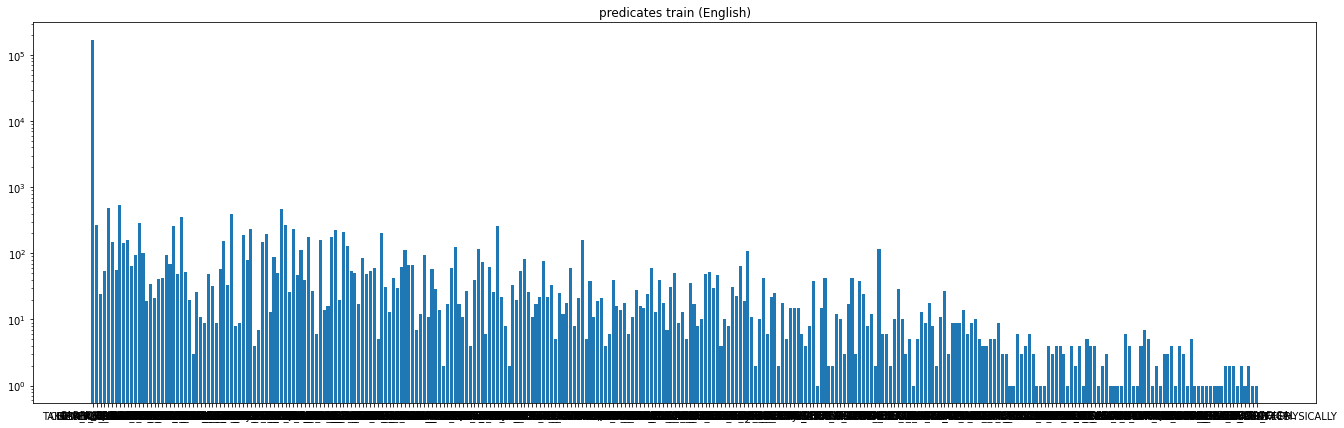

In [ ]:
plot_histogram(pred, "predicates", "predicates train (English)")

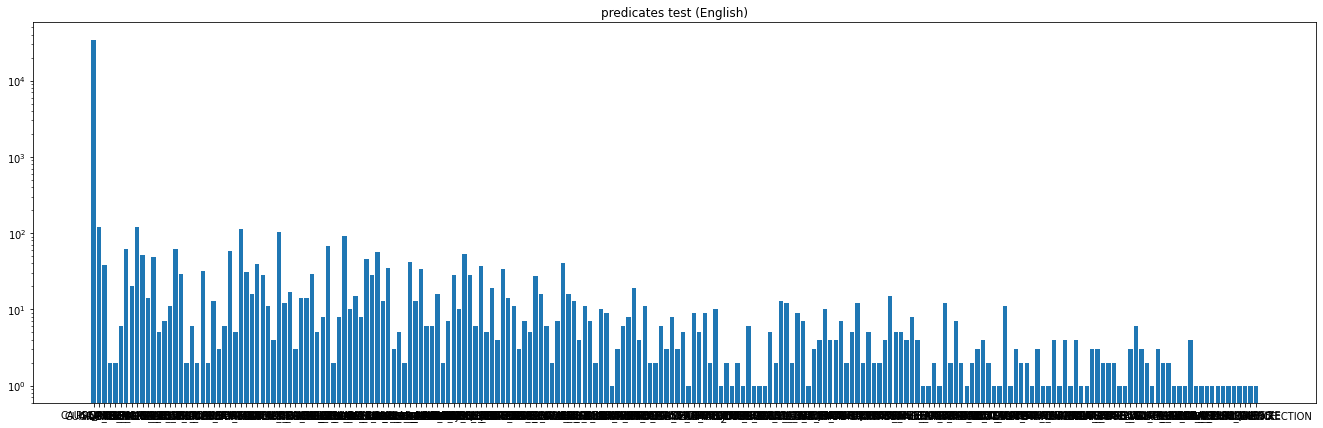

In [ ]:
plot_histogram(pred_dev, "predicates", "predicates test (English)")

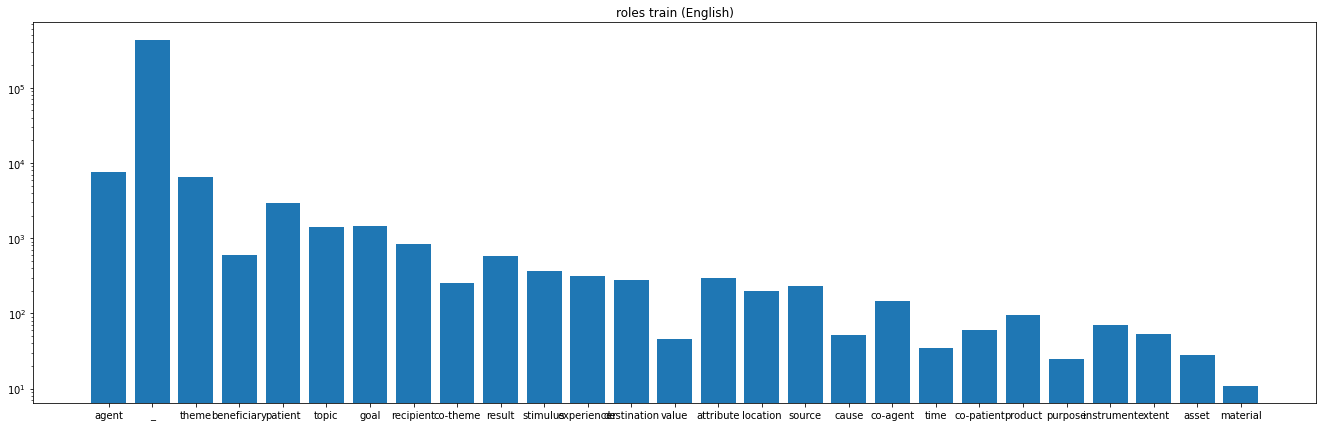

In [ ]:
plot_histogram(rol, "roles", "roles train (English)")

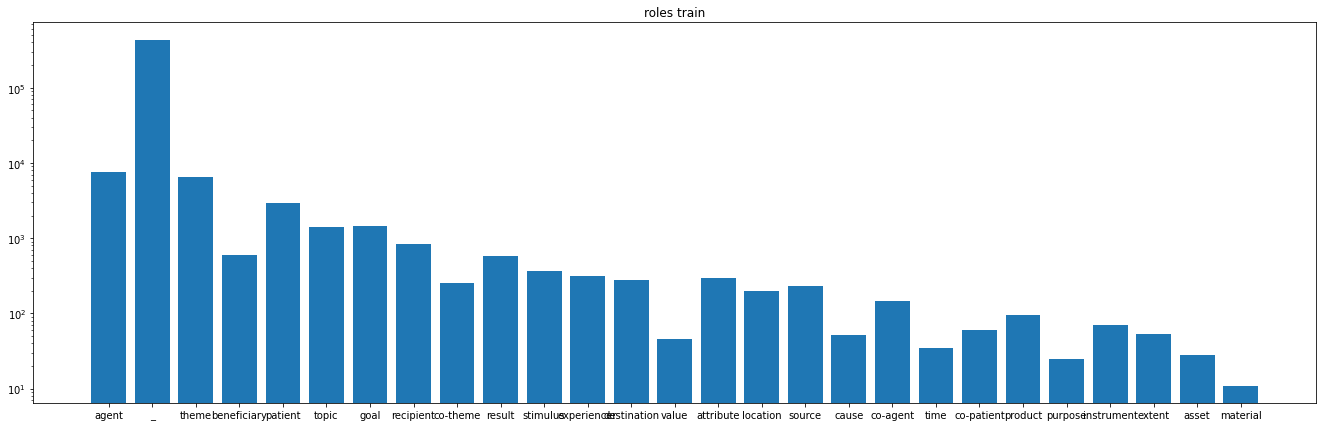

In [ ]:
plot_histogram(rol_dev, "roles", "roles train")

In [ ]:
#read Spanish data with use of words
wordsES, predES, rolES = read_data(pth_train_ES, "words")
words_devES, pred_devES, rol_devES = read_data(pth_dev_ES, "words")

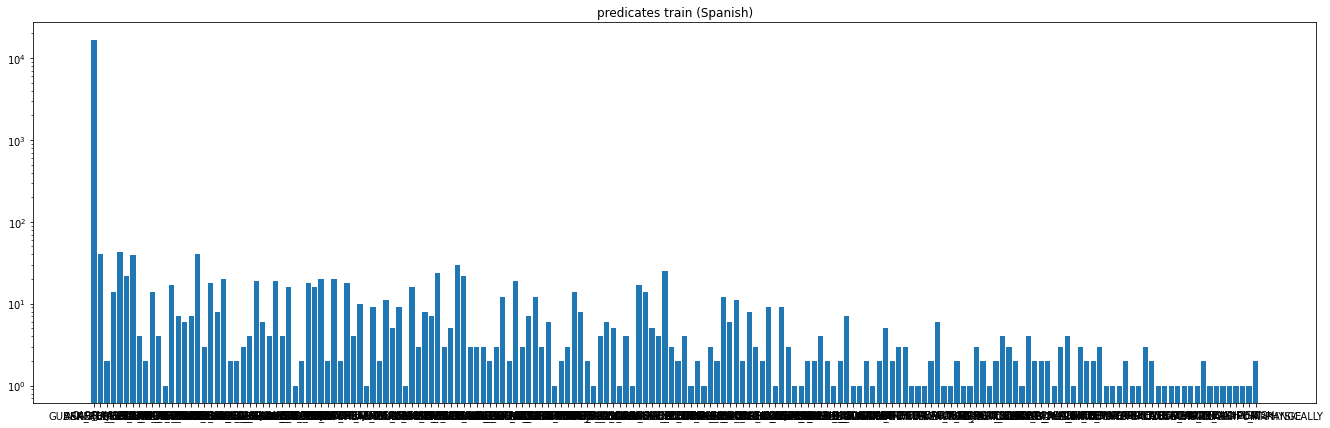

In [ ]:
plot_histogram(predES, "predicates", "predicates train (Spanish)")

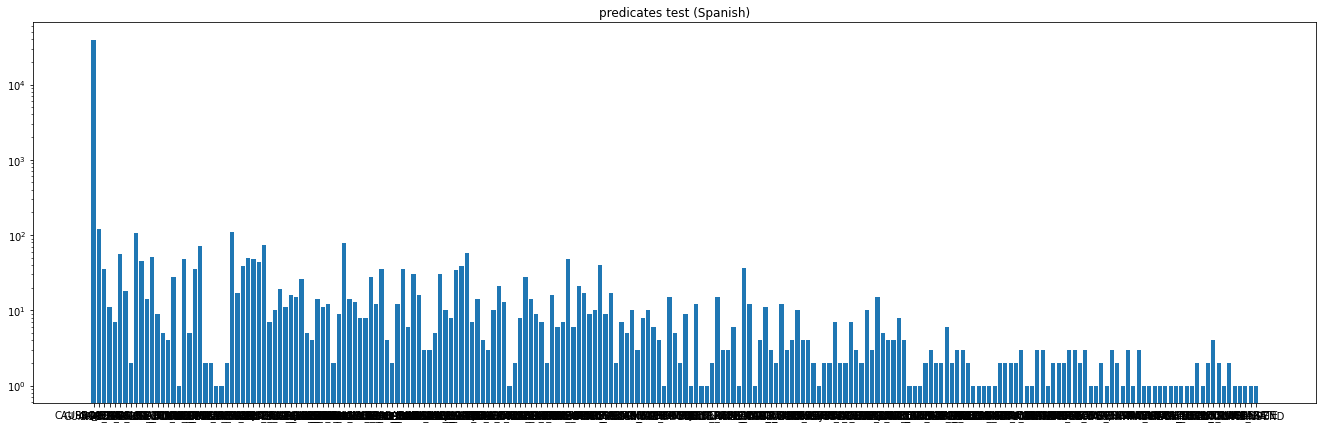

In [ ]:
plot_histogram(pred_devES, "predicates", "predicates test (Spanish)")

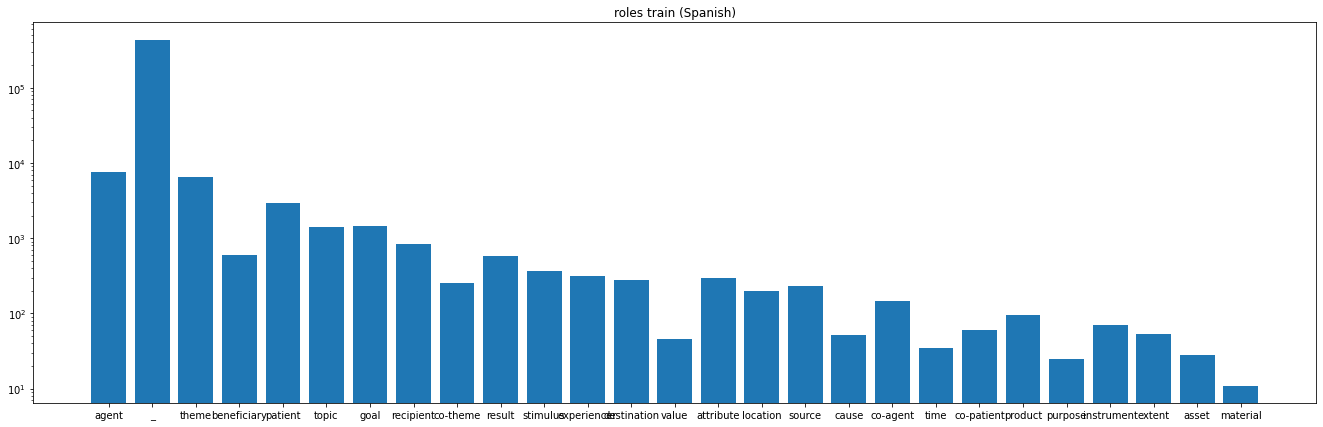

In [ ]:
plot_histogram(rolES, "roles", "roles train (Spanish)")

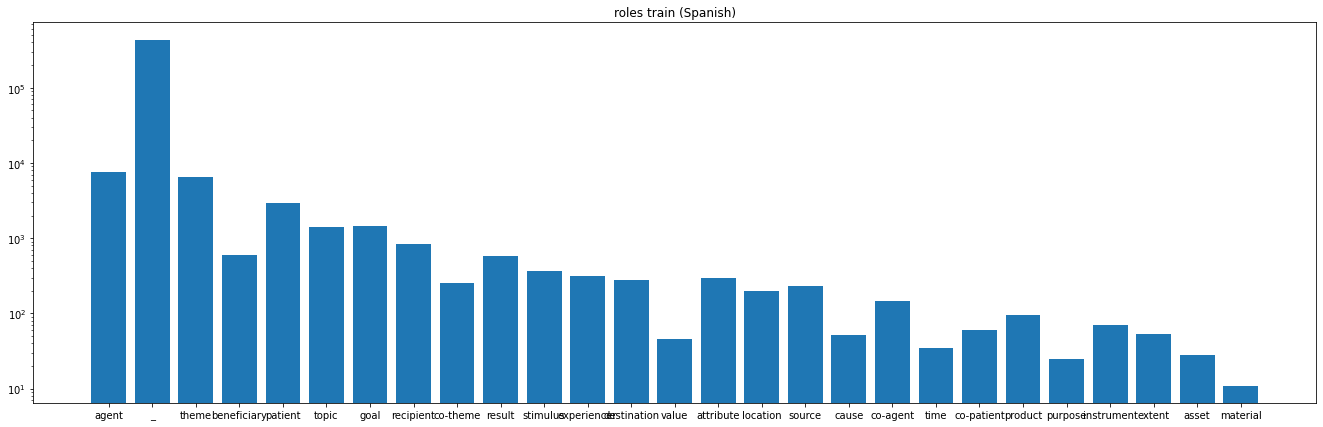

In [ ]:
plot_histogram(rol_devES, "roles", "roles train (Spanish)")

In [ ]:
#read Franch data with use of words
wordsFR, predFR, rolFR = read_data(pth_train_FR, "words")
words_devFR, pred_devFR, rol_devFR = read_data(pth_dev_FR, "words")

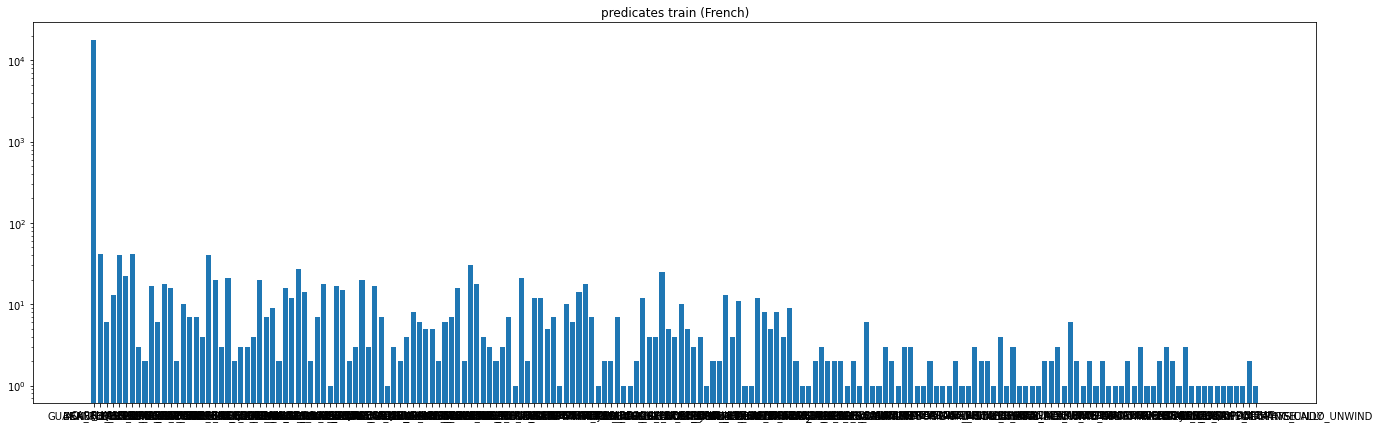

In [ ]:
plot_histogram(predFR, "predicates", "predicates train (French)")

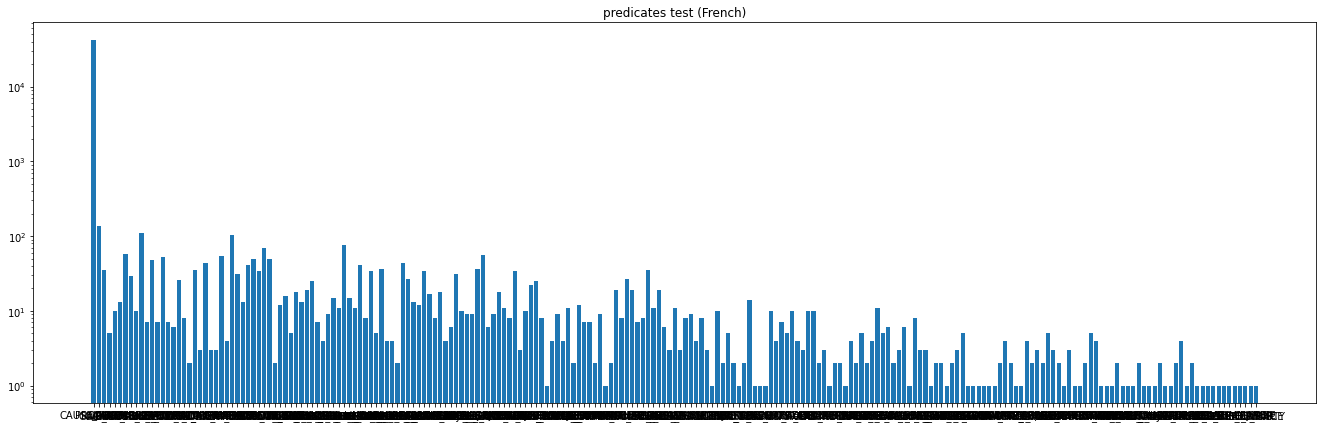

In [ ]:
plot_histogram(pred_devFR, "predicates", "predicates test (French)")

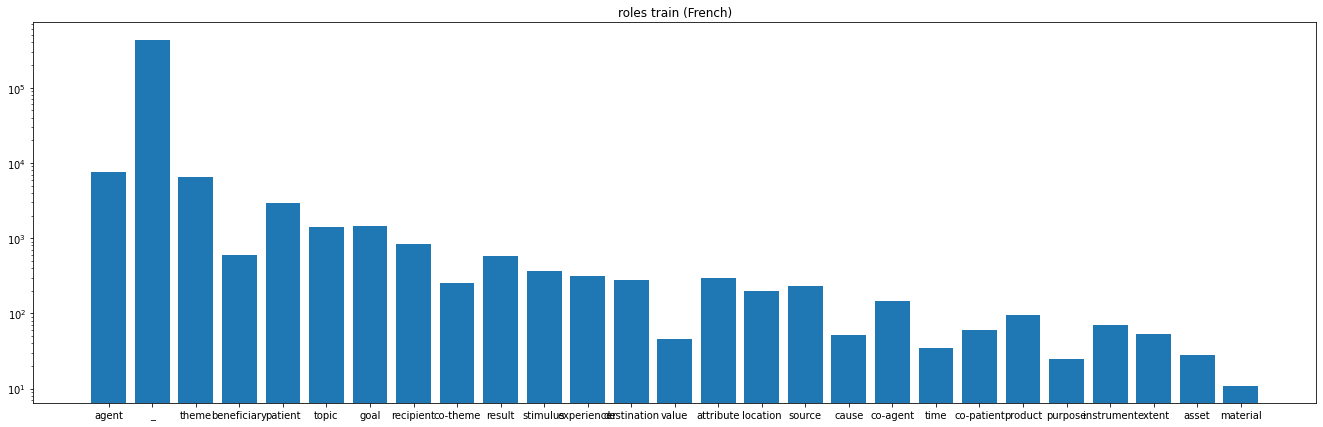

In [ ]:
plot_histogram(rolFR, "roles", "roles train (French)")

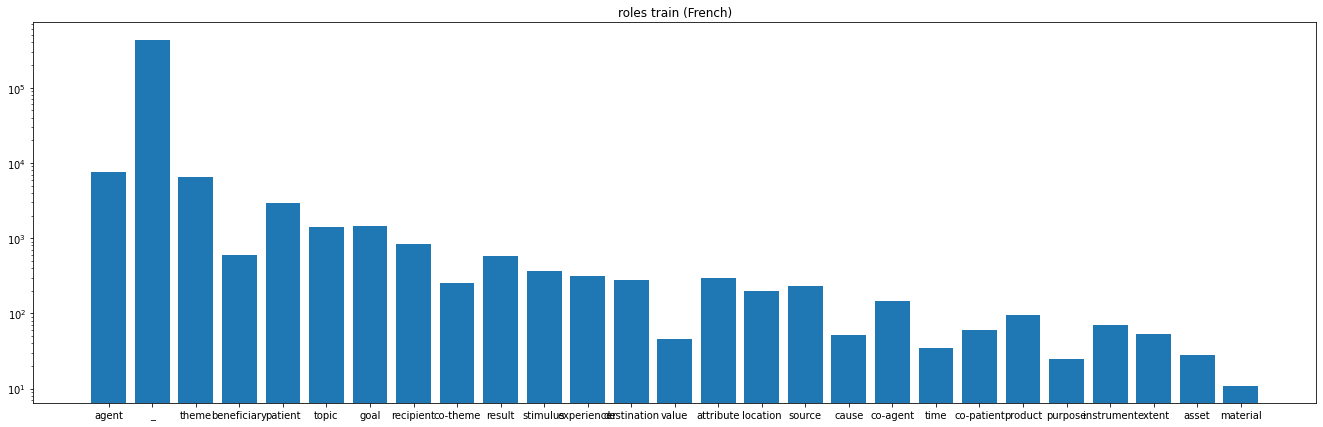

In [ ]:
plot_histogram(rol_devFR, "roles", "roles train (French)")

In [ ]:
#Find all possible classes of predicates between all available data

pred_classes = []
for p in pred:
  for pi in p:
    if pi not in pred_classes:
      pred_classes.append(pi)
      
for p in pred_dev:
  for pi in p:
    if pi not in pred_classes:
      pred_classes.append(pi)
pred_classes.remove("_")

#create a dictionary to associate each class with an integer with two special classes:
# '-100' for padding
# '0' for "_" (not predicate)  

dict_predicate_classes = {}
dict_predicate_classes.update({'PAD':-100})
dict_predicate_classes.update({'_':0})
counter = 1
for pc in pred_classes:
  dict_predicate_classes.update({pc:counter})
  counter=counter+1

In [ ]:
#Find all possible classes of arguments between all available data

roles_list = []

for r in rol:
  for ri in r.values():
    for i in ri:
      if i not in roles_list:
        roles_list.append(i)

for r in rol_dev:
  for ri in r.values():
    for i in ri:
      if i not in roles_list:
        roles_list.append(i)

roles_list.remove("_")

#create a dictionary to associate each class with an integer with two special classes:
# '-100' for padding
# '0' for "_" (not predicate)  

dict_argument_classes = {}
dict_argument_classes.update({'PAD':-100})
dict_argument_classes.update({'_':0})
counter = 1
for r in roles_list:
  dict_argument_classes.update({r:counter})
  counter=counter+1

In [ ]:
for r in rol:
  for ri in list(r.items()):
    i=ri
print(i[1])

['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'experiencer', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'stimulus', '_', '_', '_', '_', '_', '_', '_']


#**Predicate Identification**

##Process data and prepare dataset

In [ ]:
#process data

'''
- args:
  - sentences: list of strings ("lemmas" or "words")
  - predicates: list of string (predicates)
  - language_model: transformer to use to tokenization

-output:
  -sentences_with_mask: list of dictionaries (each element has keys "input_ids" and "attention_mask")
  -labels: list tensor of tensors with all labels
'''

def encode_data(sentences: list, predicates: list, language_model: str):

  #use the transformer tokanizer
  tokenizer = AutoTokenizer.from_pretrained(language_model)

  #copy the input
  sent = sentences.copy()
  predic = predicates.copy()

  #find max lenght between all data in dataset to add padding later
  max_len = 0
  for s in sent:
      max_len = max(max_len, len(s))

  #convert tokens into ids with the tokanizer
  tokens = []
  for s in sent:
    si = s.copy()
    ids = tokenizer.convert_tokens_to_ids(si)
    #add pading
    while len(ids)<max_len:
      ids.append(0)

    tokens.append([id for id in ids])

  #create a mask to divide useful tokens from padding
  masks = []
  for ti in tokens:
    mask = []
    for tj in ti:
      if tj!=0:
        mask.append(1)
      else:
        mask.append(0)
    masks.append(mask)
  
  #store ids and mask into a dictionary (both converted in tensors)
  sentences_with_masks = []
  for t,m in zip(tokens,masks):
    t = torch.tensor(t)
    m = torch.tensor(m)
    sentences_with_masks.append({"input_ids":t,"attention_mask":m})

  #process labels indicating with "1" a predicate and with "0" other words
  labels = []
  for pred in predic:
    p = pred.copy()
    label = []
    for pi in p:
      if pi !="_":
        label.append(1)
      else:
        label.append(0)
    #add padding
    while len(label)<max_len:
      label.append(0)

    labels.append(label)

  labels = torch.tensor(labels)

  return sentences_with_masks, labels

In [ ]:
#process data
data, labels = encode_data(words, pred, BERT)
data_dev, labels_dev = encode_data(words_dev, pred_dev, BERT)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
#define datasets with its batch size
BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

##Train and test functions

In [ ]:
#train function

'''
- args:
  - model: an instance eof the model
  - optimizer: an instance of the optimizer
  - data_train: dataset for train 
  - data_val: dataset for validation
  - loss_f: loss function
  - epochs: (int) numer of epochs (default is 10)
  - train_loss: list of train losses if the training continue from previous one, None otherwise
  - val_loss: list of validation losses if the training continue from previous one, None otherwise

-output:
  - tot_loss_train: list of train losses
  - tot_loss_val: list of validation losses
'''

def train(model, optimizer, data_train, data_val, loss_f, epochs: int = 10, train_loss = None, val_loss = None):

    #To store losses if call the train to continue a previous training or start new one
    if train_loss == None and val_loss == None: 
      tot_loss_train = []
      tot_loss_val = []
      epochs_done = 0
    else:
      tot_loss_train = train_loss
      tot_loss_val = val_loss
      assert len(tot_loss_train) == len(tot_loss_val)
      epochs_done = len(tot_loss_train)

    #Variables for early stopping 
    best_validation_loss = float('inf')
    counter = 0
    patience = 5
    
    #main loop
    for epoch in range(epochs):

        print("\nepoch: "+str(epoch+1+epochs_done)+"/"+str(epochs+epochs_done))

        #training loop
        print("Training...")
        loss_train = []

        #process data
        for x, y in data_train:
            optimizer.zero_grad()
            input = {k: v.to(device) for k, v in x.items()}
            out = model(input)
            out = out.type(torch.float).to(device)
            y = y.type(torch.float).to(device)
            if len(out.shape)==1:
              out = torch.unsqueeze(out, 0)
            loss = loss_f(out, y)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        #loss of a batch
        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        #validation loop
        print("Validating...")
        loss_val = []

        #process data
        for x, y in data_val:
          with torch.no_grad():
            input = {k: v.to(device) for k, v in x.items()}
            out = model(input)
            y = y.type(torch.float).to(device)
            if len(out.shape)==1:
              out = torch.unsqueeze(out, 0)
            loss = loss_f(out, y)
            loss_val.append(loss.item())

        #loss of a batch
        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")
      
        #Early Stopping
        if lv < best_validation_loss:
          best_validation_loss = lv
          counter = 0
        else:
          counter = counter+1
        if counter >= patience:
          break

    return tot_loss_train, tot_loss_val

In [ ]:
#test function

'''
- input:
  - model: an instance of the model
  - dataloader: dataset for test

- output:
  - true: list of true labels (int)
  - pred: list of predictions (int)
'''

def test(model: nn.Module, dataloader: DataLoader):

  num_correctly = 0   #number of correctly predicted
  num_predicted = 0   #number of total predicted
  num_gold = 0        #number of true labels
  pred = []           #list of predictions
  true = []           #list of true labels

  for x, y in dataloader:

      #predict data
      with torch.no_grad():
          input = {k: v.to(device) for k, v in x.items()}
          out = model(input)
          out = torch.round(out)

      #check the predictions with true labels to compute F1 metric
      for elem_pred, elem_true in zip(out, y):

          for e_pred, e_true in zip(elem_pred, elem_true):

            e_pred = e_pred.item()
            e_true = e_true.item()
            
            if e_pred == 1 and e_true == 1: 
              num_correctly += 1
            if e_pred == 1:
              num_predicted +=1
            if e_true == 1:
              num_gold += 1

            true.append(e_true)
            pred.append(e_pred)

  print("Correctly classified: "+str(num_correctly))
  print("Predicted: "+str(num_predicted))
  print("Gold: "+str(num_gold))

  precision = num_correctly/num_predicted
  recall = num_correctly/num_gold
  F1 = 2*(precision*recall)/(precision+recall)

  print(f'# Precision: {precision:.2f}')
  print(f'# Recall: {recall:.2f}')
  print(f'# F1: {F1:.2f}')
  
  return true, pred

##Model

In [ ]:
class PredicateIdentifier(torch.nn.Module):

    def __init__(self, n_hidden, classes, language_model_name="bert-base-cased"):
        super(PredicateIdentifier, self).__init__()

        #Transformer
        self.transformer_model = AutoModel.from_pretrained(language_model_name, output_hidden_states=True)

        #Freeze Transformer
        for param in self.transformer_model.parameters():
          param.requires_grad = False

        #Number of features in output from the transformer
        self.embedding_dim = self.transformer_model.config.hidden_size

        #Linear classifier
        self.hidden1 = torch.nn.Linear(self.embedding_dim, classes)
        #self.hidden2 = torch.nn.Linear(n_hidden, classes)

    def forward(self, sentence):

        out = self.transformer_model(**sentence)
        out = torch.stack(out[-4:-2], dim=0)
        out = torch.sum(out, dim = 0)
        
        out = self.hidden1(out)
        #out = torch.relu(out)
        #out = nn.Dropout(0.5)(out)
        #out = self.hidden2(out)
        out = torch.sigmoid(out)

        return out.squeeze()

###Training and test 1
- Batch size used: 32
- Epochs of training: 10
- Loss function: BinaryCrossEntropy
- Activation function: Sigmoid
- 2 linear layer of the classifier and 1 of Dropout
- Transformer "bert-base-cased" not finetuned
- Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.BCELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PredicateIdentifier(N_HIDDEN, N_CLASSES, BERT)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model.train()
loss_train, loss_val = train(model, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.07005876644003776
Validating...
Validation Loss: 0.03154053187204732


epoch: 2/10
Training...
Train Loss: 0.02751750453345237
Validating...
Validation Loss: 0.024650827153689332


epoch: 3/10
Training...
Train Loss: 0.01768960102851833
Validating...
Validation Loss: 0.013087977732842168


epoch: 4/10
Training...
Train Loss: 0.012039696590434159
Validating...
Validation Loss: 0.011967795435339212


epoch: 5/10
Training...
Train Loss: 0.010852264216349971
Validating...
Validation Loss: 0.011353455690873994


epoch: 6/10
Training...
Train Loss: 0.01002623999130822
Validating...
Validation Loss: 0.010945476539846923


epoch: 7/10
Training...
Train Loss: 0.009318057045100197
Validating...
Validation Loss: 0.01061972789466381


epoch: 8/10
Training...
Train Loss: 0.008691572708888881
Validating...
Validation Loss: 0.010392108233645558


epoch: 9/10
Training...
Train Loss: 0.008114150486465905
Validating...
Validation Loss: 0.010218178206640813


epoch:

In [ ]:
#Test the model
model.eval()
true, predictions = test(model, dataset_dev)

Correctly classified: 2353
Predicted: 2545
Gold: 2553
# Precision: 0.92
# Recall: 0.92
# F1: 0.92


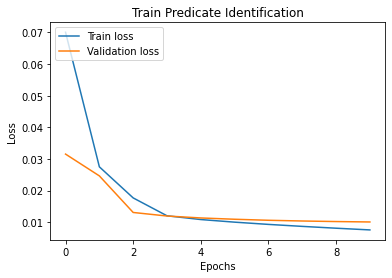

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Identification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelPredIdent.pt"
torch.save(model, pth_model, pickle_protocol=4)

###Training and test 2

- Batch size used: 32
- Epochs of training: 10
- Loss function: Mean Squared Error
- Activation function: Sigmoid
- 2 linear layer of the classifier and 1 of Dropout
- Transformer "bert-base-cased" not finetuned
- Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = PredicateIdentifier(N_HIDDEN, N_CLASSES, BERT)
model2.to(device)
optimizer = torch.optim.Adam(model2.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
loss_train, loss_val = train(model2, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.025870044709694
Validating...
Validation Loss: 0.02146974030054278


epoch: 2/10
Training...
Train Loss: 0.012397838675326877
Validating...
Validation Loss: 0.006730621266696189


epoch: 3/10
Training...
Train Loss: 0.005587110004477924
Validating...
Validation Loss: 0.004861353586117427


epoch: 4/10
Training...
Train Loss: 0.004526373733495993
Validating...
Validation Loss: 0.00439719797577709


epoch: 5/10
Training...
Train Loss: 0.004114612370669361
Validating...
Validation Loss: 0.004229553897554676


epoch: 6/10
Training...
Train Loss: 0.003868820598619359
Validating...
Validation Loss: 0.003854001969254265


epoch: 7/10
Training...
Train Loss: 0.003487693468829797
Validating...
Validation Loss: 0.00369018858893671


epoch: 8/10
Training...
Train Loss: 0.003249052040759594
Validating...
Validation Loss: 0.0036127190364317763


epoch: 9/10
Training...
Train Loss: 0.0030984225435062283
Validating...
Validation Loss: 0.0034080007398087117


epo

In [ ]:
#Test the model
model2.eval()
true, predictions = test(model2, dataset_dev)

Correctly classified: 2268
Predicted: 2435
Gold: 2553
# Precision: 0.93
# Recall: 0.89
# F1: 0.91


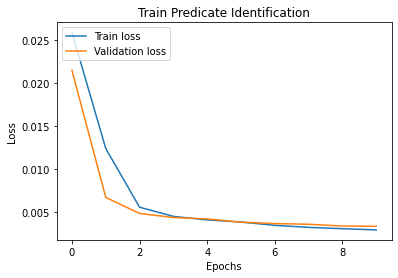

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Identification")

###Training and test 3

- Batch size used: 32
- Epochs of training: 10
- Loss function: Mean Squared Error
- Activation function: Sigmoid
- 1 linear layer of the classifier 
- Transformer "bert-base-cased" not finetuned
- Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = PredicateIdentifier(N_HIDDEN, N_CLASSES, BERT)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters())

In [ ]:
#Train the model
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.0354652788850569
Validating...
Validation Loss: 0.021171654264132183


epoch: 2/10
Training...
Train Loss: 0.02065206112400178
Validating...
Validation Loss: 0.018225562965704337


epoch: 3/10
Training...
Train Loss: 0.01672290736629117
Validating...
Validation Loss: 0.014614229193992086


epoch: 4/10
Training...
Train Loss: 0.013363567283076624
Validating...
Validation Loss: 0.012200264725834131


epoch: 5/10
Training...
Train Loss: 0.011202634222084475
Validating...
Validation Loss: 0.010605965120097002


epoch: 6/10
Training...
Train Loss: 0.009759594713367762
Validating...
Validation Loss: 0.00947762743776871


epoch: 7/10
Training...
Train Loss: 0.008733189956194931
Validating...
Validation Loss: 0.008628432845903767


epoch: 8/10
Training...
Train Loss: 0.00796273746377518
Validating...
Validation Loss: 0.007960803703301482


epoch: 9/10
Training...
Train Loss: 0.007360915169720688
Validating...
Validation Loss: 0.007420143500591318


epoch:

In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev)

Correctly classified: 1955
Predicted: 2118
Gold: 2553
# Precision: 0.92
# Recall: 0.77
# F1: 0.84


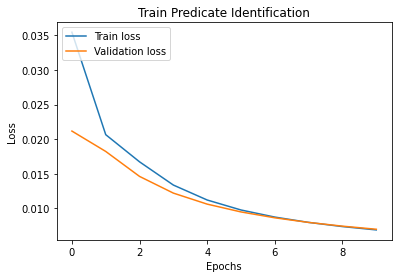

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Identification")

### Training and test 4

* Batch size used: 32
* Epochs of training: 10
* Loss function: Mean Squared Error
* Activation function: Sigmoid
* 1 linear layer of the classifier
* Transformer "bert-base-cased" finetuned
* Adam Optimizer with lr = 0.0001 and weight_decay=0.001

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model4 = PredicateIdentifier(N_HIDDEN, N_CLASSES, BERT)
model4.to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=0.0001, weight_decay=0.001)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model4.train()
loss_train, loss_val = train(model4, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.024327376124358948
Validating...
Validation Loss: 0.013963548518303368


epoch: 2/10
Training...
Train Loss: 0.00374275082121453
Validating...
Validation Loss: 0.0031719490741832284


epoch: 3/10
Training...
Train Loss: 0.0035197961594789257
Validating...
Validation Loss: 0.004039479464861668


epoch: 4/10
Training...
Train Loss: 0.0037765335088836087
Validating...
Validation Loss: 0.0037070801740305293


epoch: 5/10
Training...
Train Loss: 0.0037058043609102887
Validating...
Validation Loss: 0.0044468347009064425


epoch: 6/10
Training...
Train Loss: 0.003756975586856565
Validating...
Validation Loss: 0.004618884374698003


epoch: 7/10
Training...
Train Loss: 0.0039007259247403952
Validating...
Validation Loss: 0.004419852397404611



In [ ]:
#Test the model
model4.eval()
true, predictions = test(model4, dataset_dev)

Correctly classified: 2214
Predicted: 2422
Gold: 2553
# Precision: 0.91
# Recall: 0.87
# F1: 0.89


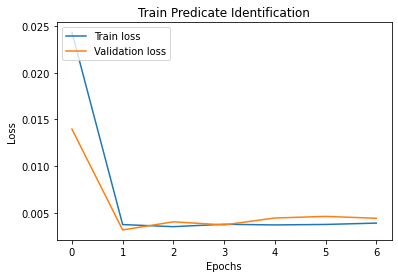

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Identification")

### Training and test 5

* Batch size used: 32
* Epochs of training: 2
* Loss function: Mean Squared Error
* Activation function: Sigmoid
* 1 linear layer of the classifier
* Transformer "bert-base-cased" finetuned
* Adam Optimizer with lr = 0.0001 and weight_decay=0.001

***OSS.:** this section contains a ***confusion matrix***



In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = 1
EPOCHS = 2
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model5 = PredicateIdentifier(N_HIDDEN, N_CLASSES, BERT)
model5.to(device)
optimizer = torch.optim.Adam(model5.parameters(), lr=0.0001, weight_decay=0.001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model5.train()
loss_train, loss_val = train(model5, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/2
Training...
Train Loss: 0.012915153504018822
Validating...
Validation Loss: 0.003036824688832793


epoch: 2/2
Training...
Train Loss: 0.0030406933390505373
Validating...
Validation Loss: 0.0029738451703451574



In [ ]:
#Test the model
model5.eval()
true, predictions = test(model5, dataset_dev)

Correctly classified: 2374
Predicted: 2588
Gold: 2553
# Precision: 0.92
# Recall: 0.93
# F1: 0.92


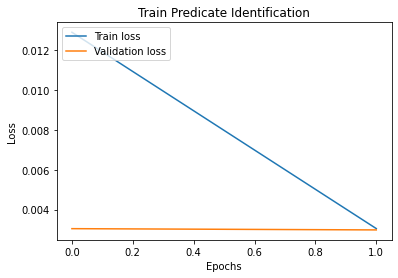

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Identification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelPredIdent.pt"
torch.save(model5, pth_model, pickle_protocol=4)

Confusion Matrix


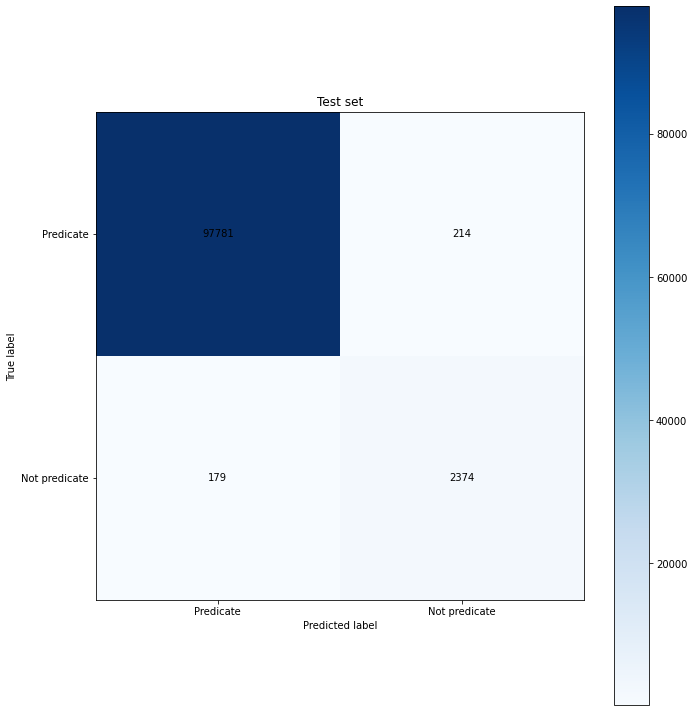

In [ ]:
#confusion matrix
plot_confusion_matrix(np.array(true), np.array(predictions), ['Predicate','Not predicate'])

###Training and test 6

* Batch size used: 32
* Epochs of training: 2
* Loss function: Mean Squared Error
* Activation function: Sigmoid
* 1 linear layer of the classifier
* Transformer "roberta-base"
* Adam Optimizer with lr = 0.0001 and weight_decay=0.001

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

Transformer finetuned

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model6 = PredicateIdentifier(N_HIDDEN, N_CLASSES, RoBERTa)
model6.to(device)
optimizer = torch.optim.Adam(model6.parameters(), lr = 0.0001, weight_decay=0.001)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model6.train()
loss_train, loss_val = train(model6, optimizer, dataset_train, dataset_val, LOSS, 2)


epoch: 1/2
Training...
Train Loss: 0.05905731515057625
Validating...
Validation Loss: 0.018249320642401774


epoch: 2/2
Training...
Train Loss: 0.01593455818872298
Validating...
Validation Loss: 0.01644339459016919



In [ ]:
#Test the model
model6.eval()
true, predictions = test(model6, dataset_dev)

Correctly classified: 2206
Predicted: 2436
Gold: 2553
# Precision: 0.91
# Recall: 0.86
# F1: 0.88


In [ ]:
#Train the model
model6.train()
loss_train, loss_val = train(model6, optimizer, dataset_train, dataset_val, LOSS, 8, loss_train, loss_val)


epoch: 3/10
Training...
Train Loss: 0.016339876505756572
Validating...
Validation Loss: 0.017112968179086845


epoch: 4/10
Training...
Train Loss: 0.01740718662378288
Validating...
Validation Loss: 0.021666833199560642


epoch: 5/10
Training...
Train Loss: 0.018929114751517772
Validating...
Validation Loss: 0.018577783420268033


epoch: 6/10
Training...
Train Loss: 0.01962553606398644
Validating...
Validation Loss: 0.020275766392134957


epoch: 7/10
Training...
Train Loss: 0.020090703876508822
Validating...
Validation Loss: 0.02210600037748615


epoch: 8/10
Training...
Train Loss: 0.02032655637951628
Validating...
Validation Loss: 0.020314121696477134



In [ ]:
#Test the model
model6.eval()
true, predictions = test(model6, dataset_dev)

Correctly classified: 2116
Predicted: 2457
Gold: 2553
# Precision: 0.86
# Recall: 0.83
# F1: 0.84


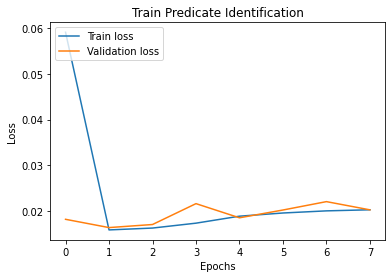

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Identification")

Transformer not finetuned

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model6 = PredicateIdentifier(N_HIDDEN, N_CLASSES, RoBERTa)
model6.to(device)
optimizer = torch.optim.Adam(model6.parameters())

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model6.train()
loss_train, loss_val = train(model6, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.2504015761998392
Validating...
Validation Loss: 0.12667708057496282


epoch: 2/10
Training...
Train Loss: 0.11062889377917012
Validating...
Validation Loss: 0.09416162346800168


epoch: 3/10
Training...
Train Loss: 0.08965504683794513
Validating...
Validation Loss: 0.08134741191234854


epoch: 4/10
Training...
Train Loss: 0.07818930055345258
Validating...
Validation Loss: 0.07263634891973601


epoch: 5/10
Training...
Train Loss: 0.07060009519900046
Validating...
Validation Loss: 0.06880486570298672


epoch: 6/10
Training...
Train Loss: 0.06547609305670185
Validating...
Validation Loss: 0.06270832858151859


epoch: 7/10
Training...
Train Loss: 0.06263516879370136
Validating...
Validation Loss: 0.058863894600007266


epoch: 8/10
Training...
Train Loss: 0.05920536941097629
Validating...
Validation Loss: 0.05706440264152156


epoch: 9/10
Training...
Train Loss: 0.05718242093440025
Validating...
Validation Loss: 0.05529035896890693


epoch: 10/10
Train

In [ ]:
#Test the model
model6.eval()
true, predictions = test(model6, dataset_dev)

Correctly classified: 940
Predicted: 1060
Gold: 2553
# Precision: 0.89
# Recall: 0.37
# F1: 0.52


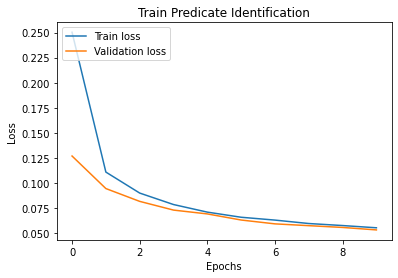

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Identification")

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Identification")

###Training and test 7

* Batch size used: 32
* Epochs of training: 10
* Loss function: Mean Squared Error
* Activation function: Sigmoid
* 1 linear layer of the classifier
* Transformer "albert-base-v2" finetuned
* Adam Optimizer with lr = 0.0001 and weight_decay=0.001


No Transformer fine-tune

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model7 = PredicateIdentifier(N_HIDDEN, N_CLASSES, ALBERT)
model7.to(device)
optimizer = torch.optim.Adam(model7.parameters(), lr=0.0001, weight_decay=0.001)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.09648722674577467
Validating...
Validation Loss: 0.027331845007008977


epoch: 2/10
Training...
Train Loss: 0.02549438404460107
Validating...
Validation Loss: 0.023683824472957186


epoch: 3/10
Training...
Train Loss: 0.023709734865734654
Validating...
Validation Loss: 0.022931980279584725


epoch: 4/10
Training...
Train Loss: 0.023200383602130798
Validating...
Validation Loss: 0.02227974941747056


epoch: 5/10
Training...
Train Loss: 0.02298034583368609
Validating...
Validation Loss: 0.022020112826592393


epoch: 6/10
Training...
Train Loss: 0.022882094847098473
Validating...
Validation Loss: 0.022115894593298435


epoch: 7/10
Training...
Train Loss: 0.022823445667182245
Validating...
Validation Loss: 0.022182912565767765


epoch: 8/10
Training...
Train Loss: 0.02278717630092175
Validating...
Validation Loss: 0.02198585102127658


epoch: 9/10
Training...
Train Loss: 0.022757489642789286
Validating...
Validation Loss: 0.0219098547887471


epoch: 1

In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev)

Correctly classified: 0
Predicted: 0
Gold: 2553


ZeroDivisionError: ignored

In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev)

Correctly classified: 2092
Predicted: 2314
Gold: 2553
# Precision: 0.90
# Recall: 0.82
# F1: 0.86


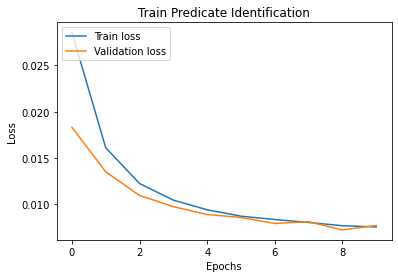

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Identification")

Transformer fine-tune

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model7 = PredicateIdentifier(N_HIDDEN, N_CLASSES, ALBERT)
model7.to(device)
optimizer = torch.optim.Adam(model7.parameters(), lr=0.00001, weight_decay=0.0001)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 3/10
Training...
Train Loss: 0.021484088158655552
Validating...
Validation Loss: 0.019918288259456556


epoch: 4/10
Training...
Train Loss: 0.01796119120572844
Validating...
Validation Loss: 0.013276355703257851


epoch: 5/10
Training...
Train Loss: 0.010880631941460795
Validating...
Validation Loss: 0.008364891736871667


epoch: 6/10
Training...
Train Loss: 0.007317288986016666
Validating...
Validation Loss: 0.0067283025321861105


epoch: 7/10
Training...
Train Loss: 0.006055473390546057
Validating...
Validation Loss: 0.0063902452691561645


epoch: 8/10
Training...
Train Loss: 0.005556715852130325
Validating...
Validation Loss: 0.006026963858554761


epoch: 9/10
Training...
Train Loss: 0.0049680804195363195
Validating...
Validation Loss: 0.00604671969388922


epoch: 10/10
Training...
Train Loss: 0.004464108073302815
Validating...
Validation Loss: 0.0057052389149450594



In [ ]:
model7.eval()
true, predictions = test(model7, dataset_dev)

Correctly classified: 2064
Predicted: 2391
Gold: 2553
# Precision: 0.86
# Recall: 0.81
# F1: 0.83


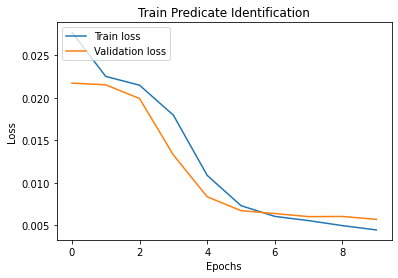

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Identification")

##Transfer learning for Spanish

In [ ]:
#process data
data, labels = encode_data(wordsES, predES, BERT)
data_dev, labels_dev = encode_data(words_devES, pred_devES, BERT)

In [ ]:
#define datasets with its batch size
BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = 1
EPOCHS = 20
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
modelPredIdent = torch.load("/content/drive/MyDrive/modelPredIdent.pt")
modelPredIdent.to(device)
optimizer = torch.optim.Adam(modelPredIdent.parameters(), lr=0.00001, weight_decay=0.00001)

In [ ]:
#Train the model
modelPredIdent.train()
loss_train, loss_val = train(modelPredIdent, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/20
Training...
Train Loss: 0.017185374262875745
Validating...
Validation Loss: 0.01325021218508482


epoch: 2/20
Training...
Train Loss: 0.015387794002890587
Validating...
Validation Loss: 0.011752634774893522


epoch: 3/20
Training...
Train Loss: 0.01388296511556421
Validating...
Validation Loss: 0.010596422012895346


epoch: 4/20
Training...
Train Loss: 0.0131595821252891
Validating...
Validation Loss: 0.011743798851966858


epoch: 5/20
Training...
Train Loss: 0.01312593842989632
Validating...
Validation Loss: 0.011069854255765676


epoch: 6/20
Training...
Train Loss: 0.011285457336011209
Validating...
Validation Loss: 0.009423698764294386


epoch: 7/20
Training...
Train Loss: 0.011061524373612233
Validating...
Validation Loss: 0.008791645057499409


epoch: 8/20
Training...
Train Loss: 0.010762844700366259
Validating...
Validation Loss: 0.00933161098510027


epoch: 9/20
Training...
Train Loss: 0.01031088353400784
Validating...
Validation Loss: 0.009558693505823612


epoch: 

In [ ]:
#Test the model
modelPredIdent.eval()
true, predictions = test(modelPredIdent, dataset_dev)

Correctly classified: 1254
Predicted: 1570
Gold: 2495
# Precision: 0.80
# Recall: 0.50
# F1: 0.62


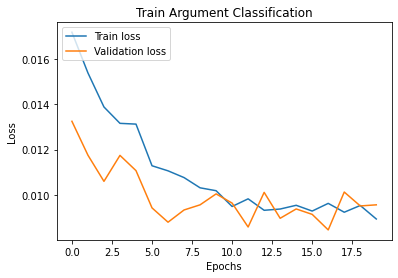

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelPredIdentES.pt"
torch.save(modelPredIdent, pth_model, pickle_protocol=4)

##Transfer learning for French

In [ ]:
#process data
data, labels = encode_data(wordsFR, predFR, BERT)
data_dev, labels_dev = encode_data(words_devFR, pred_devFR, BERT)

In [ ]:
#define datasets with its batch size
BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
modelPredIdent = torch.load("/content/drive/MyDrive/modelPredIdent.pt")
modelPredIdent.to(device)
optimizer = torch.optim.Adam(modelPredIdent.parameters(), lr=0.00001, weight_decay=0.00001)

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = 1
EPOCHS = 20
LOSS = nn.MSELoss()

In [ ]:
#Train the model
modelPredIdent.train()
loss_train, loss_val = train(modelPredIdent, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/20
Training...
Train Loss: 0.01815521697114621
Validating...
Validation Loss: 0.014878141693770885


epoch: 2/20
Training...
Train Loss: 0.016416439786553383
Validating...
Validation Loss: 0.013851318508386612


epoch: 3/20
Training...
Train Loss: 0.01620871327551348
Validating...
Validation Loss: 0.012364999856799841


epoch: 4/20
Training...
Train Loss: 0.014637092993195568
Validating...
Validation Loss: 0.011233911383897066


epoch: 5/20
Training...
Train Loss: 0.013224334788641759
Validating...
Validation Loss: 0.01221252791583538


epoch: 6/20
Training...
Train Loss: 0.013394187271062816
Validating...
Validation Loss: 0.011769779026508331


epoch: 7/20
Training...
Train Loss: 0.01219332923314401
Validating...
Validation Loss: 0.01034930208697915


epoch: 8/20
Training...
Train Loss: 0.01160918126281883
Validating...
Validation Loss: 0.009088574210181832


epoch: 9/20
Training...
Train Loss: 0.011436741399977888
Validating...
Validation Loss: 0.010149439331144094


epoch:

In [ ]:
#Test the model
modelPredIdent.eval()
true, predictions = test(modelPredIdent, dataset_dev)

Correctly classified: 1436
Predicted: 2345
Gold: 2555
# Precision: 0.61
# Recall: 0.56
# F1: 0.59


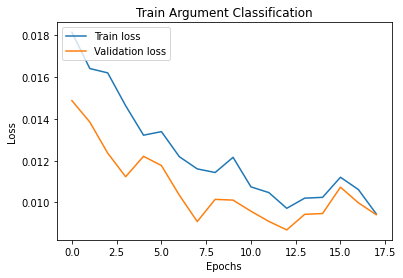

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelPredIdentFR.pt"
torch.save(modelPredIdent, pth_model, pickle_protocol=4)

#**Predicate Disambiguation**

##Process data and prepare dataset

In [ ]:
#process data

'''
- args:
  - sentences: list of strings ("lemmas" or "words")
  - predicates: list of string (predicates)
  - language_model: transformer to use to tokenization

-output:
  -sentences_with_mask: list of dictionaries (each element has keys "input_ids" and "attention_mask")
  -labels: list tensor of tensors with all labels
'''

def encode_data(sentences: list, predicates: list, language_model: str):

  #use the tranformer tokanizer
  tokenizer = AutoTokenizer.from_pretrained(language_model)

  sent = sentences.copy()
  predic = predicates.copy()

  #find max lenght between all data in dataset to add padding later
  max_len = 0
  for s in sent:
      max_len = max(max_len, len(s))

  #convert tokens into ids with the tokanizer
  tokens_list = []
  for s in sent:
    si = s.copy()
    tokens = []
    for i in si:
      tokens.append(tokenizer(i)[0].ids[1])
    #add padding
    while len(tokens)<max_len:
      tokens.append(0)

    tokens_list.append(tokens)

  #create a mask to divide useful tokens from padding
  masks = []
  for ti in tokens_list:
    mask = []
    for tj in ti:
      if tj!=0:
        mask.append(1)
      else:
        mask.append(0)
        
    masks.append(mask)

  assert len(tokens_list)==len(masks)
  
  #store ids and mask into a dictionary
  sentences_with_masks = []
  for t,m in zip(tokens_list,masks):
    ti = torch.tensor(t)
    mi = torch.tensor(m)
    sentences_with_masks.append({"input_ids":ti,"attention_mask":mi})

  #process labels indicating with "1" a predicate and with "0" other words
  labels = []
  for pred in predic:
    p = pred.copy()
    label = []
    for pi in p:
      if pi =="_" or pi not in dict_predicate_classes.keys():
        label.append(dict_predicate_classes['_'])
      else:
        label.append(dict_predicate_classes[pi])
    #add padding
    while len(label)<max_len:
      label.append(dict_predicate_classes['PAD'])
      
    labels.append(label)
  
  labels = torch.tensor(labels)

  return sentences_with_masks, labels

In [ ]:
#process data
data, labels = encode_data(words, pred, BERT)
data_dev, labels_dev = encode_data(words_dev, pred_dev, BERT)

In [ ]:
#organize dataset with batches
BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

##Train and test functions

In [ ]:
#train function

'''
- args:
  - model: an instance eof the model
  - optimizer: an instance of the optimizer
  - data_train: dataset for train 
  - data_val: dataset for validation
  - loss_f: loss function
  - epochs: (int) numer of epochs (default is 10)
  - train_loss: list of train losses if the training continue from previous one, None otherwise
  - val_loss: list of validation losses if the training continue from previous one, None otherwise

-output:
  - tot_loss_train: list of train losses
  - tot_loss_val: list of validation losses
'''

def train(model, optimizer, data_train, data_val, loss_f, n_classes, epochs: int = 10, train_loss = None, val_loss = None):

    #To store losses if call the train to continue a previous training or start new one
    if train_loss == None and val_loss == None: 
      tot_loss_train = []
      tot_loss_val = []
      epochs_done = 0
    else:
      tot_loss_train = train_loss
      tot_loss_val = val_loss
      assert len(tot_loss_train) == len(tot_loss_val)
      epochs_done = len(tot_loss_train)

    #Vriables for early stopping
    best_validation_loss = float('inf')
    counter = 0
    patience = 5
    
    #main loop
    for epoch in range(epochs):

        print("\nepoch: "+str(epoch+1+epochs_done)+"/"+str(epochs+epochs_done))

        #training loop
        print("Training...")
        loss_train = []  
        for x, y in data_train:

            optimizer.zero_grad()
            x.update({"predicates":y})
            input = {k: v.to(device) for k, v in x.items()}
            out = model(**input)
            out = out.to(device)
            y = y.to(device)
            loss = loss_f(out.view(-1, n_classes), y.view(-1), ignore_index=-100)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        #loss of the batch
        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        #validation loop
        print("Validating...")

        loss_val = []

        for x, y in data_val:

          with torch.no_grad():
            x.update({"predicates":y})
            input = {k: v.to(device) for k, v in x.items()}
            out = model(**input)
            out = out.to(device)
            y = y.to(device)
            loss = loss_f(out.view(-1, n_classes), y.view(-1), ignore_index=-100)
            loss_val.append(loss.item())

        #loss of the batch
        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")

        #Early Stopping
        if lv < best_validation_loss:
          best_validation_loss = lv
          counter = 0
        else:
          counter = counter+1
        if counter >= patience:
          break

    return tot_loss_train, tot_loss_val

In [ ]:
def test(model: nn.Module, dataloader: DataLoader):

  num_correctly = 0   #number of correctly predicted (true positives)
  false_positives=0   #number of false positives predicted
  false_negatives=0   #number of false negatives predicted
  pred = []           #list of predictions
  true = []           #list of true labels

  for x, y in dataloader:

      #predict data
      with torch.no_grad():
          x.update({"predicates":y})
          input = {k: v.to(device) for k, v in x.items()}
          out = model(**input)
          out = F.log_softmax(out,-1)
          out = torch.argmax(out, -1)

      #check the predictions with true labels to compute F1 metric
      for elem_pred,elem_true in zip(out, y):

          for e_pred,e_true in zip(elem_pred,elem_true):

              e_pred = e_pred.item()
              e_true = e_true.item()
                  
              if e_pred != 0 and e_true!=0 and e_true!=-100:
                if e_pred == e_true: 
                  num_correctly += 1
                else:
                  false_positives +=1
                  false_negatives +=1
              elif e_pred!=0 and e_true==0:
                  false_positives+=1
              elif e_pred==0 and e_true!=0 and e_true!=-100:
                  false_negatives+=1
              true.append(e_true)
              pred.append(e_pred)

  print("Correctly classified: "+str(num_correctly))
  print("False Positives: "+str(false_positives))
  print("False Negatives: "+str(false_negatives))

  precision = num_correctly/(num_correctly+false_positives)
  recall = num_correctly/(num_correctly+false_negatives)
  F1 = 2*(precision*recall)/(precision+recall)

  print(f'# Precision: {precision:.2f}')
  print(f'# Recall: {recall:.2f}')
  print(f'# F1: {F1:.2f}')
  
  return true, pred

## Model

In [ ]:
class PredicateDisambiguation(torch.nn.Module):

    def __init__(self, n_hidden, classes, device, language_model_name="bert-base-cased"):
        super(PredicateDisambiguation, self).__init__()

        #Transformer model
        self.transformer_model = AutoModel.from_pretrained(language_model_name, output_hidden_states=True)

        #Freeze Transformer
        for param in self.transformer_model.parameters():
          param.requires_grad = False

        #Number of features in output from the transformer
        self.embedding_dim = self.transformer_model.config.hidden_size

        #Additive feature to represent where is a predicate
        self.add_features = 100

        #BiLSTM layer
        self.lstm = nn.LSTM(self.embedding_dim+self.add_features, n_hidden, bidirectional=True, num_layers = 2, dropout=0.3, batch_first = True)

        #Linear classifier
        self.hidden1 = torch.nn.Linear(2*n_hidden, classes)
        #self.hidden2 = torch.nn.Linear(n_hidden, classes)

    def forward(self, 
                input_ids: torch.Tensor = None,
                attention_mask: torch.Tensor = None,
                predicates: torch.Tensor = None):
      
        dict_input = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }

        out = self.transformer_model(**dict_input)
        out = torch.stack(out.hidden_states[-4:], dim=0).mean(dim=0)
        
        #associate a tensor of shape (1) with '1' in correspondence with the predicates and '0' otherwise
        o = []
        for oi,pid in zip(out, predicates):
          new_pred_id = []
          for p in pid:
            p = p.item()
            if p!=0 and p!=-100:
              new_pred_id.append(torch.ones((self.add_features),requires_grad=True))
            else:
              new_pred_id.append(torch.zeros((self.add_features),requires_grad=True))
          new_pred_id = torch.stack(new_pred_id).to(device)
          o.append(torch.cat((oi,new_pred_id),dim=1))
        
        out = torch.stack(o).to(device)
        out, _ = self.lstm(out)
        out = self.hidden1(out)
        #out = torch.relu(out)
        #out = nn.Dropout(0.3)(out)
        #out = self.hidden2(out)

        return out

### Training and test 1

* Batch size used: 32
* Epochs of training: 10
* Loss function: cross_entropy
* Activation function: softmax
* 2 linear layers and 1 Dropout(0.3) layer of the classifier
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = len(pred_classes)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PredicateDisambiguation(N_HIDDEN, N_CLASSES, device, BERT)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model.train()
loss_train, loss_val = train(model, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.5367505067779171
Validating...
Validation Loss: 0.2768477640218205


epoch: 2/10
Training...
Train Loss: 0.22716672564706494
Validating...
Validation Loss: 0.1877141354812516


epoch: 3/10
Training...
Train Loss: 0.16327592172930316
Validating...
Validation Loss: 0.1490408107638359


epoch: 4/10
Training...
Train Loss: 0.13036873085844902
Validating...
Validation Loss: 0.13027175764242807


epoch: 5/10
Training...
Train Loss: 0.11113503642620579
Validating...
Validation Loss: 0.11541207879781723


epoch: 6/10
Training...
Train Loss: 0.09642333097515568
Validating...
Validation Loss: 0.11566092570622762


epoch: 7/10
Training...
Train Loss: 0.08510628695930204
Validating...
Validation Loss: 0.10755905177858141


epoch: 8/10
Training...
Train Loss: 0.07761468255231457
Validating...
Validation Loss: 0.10506640250484149


epoch: 9/10
Training...
Train Loss: 0.07038771689178482
Validating...
Validation Loss: 0.09782468486163351


epoch: 10/10
Training.

In [ ]:
#Test the model
model.eval()
true, predictions = test(model, dataset_dev)

Correctly classified: 1901
False Positives: 540
False Negatives: 652
# Precision: 0.78
# Recall: 0.74
# F1: 0.76


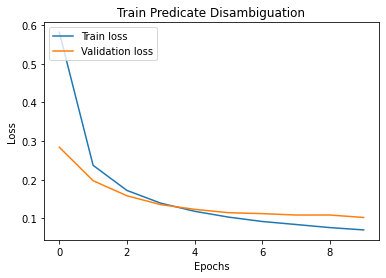

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

### Training and test 2

* Batch size used: 32
* Epochs of training: 10
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* Transformer "bert-base-cased" finetuned
* Adam Optimizer with lr = 0.0001 and weight_decay=0.001

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = len(pred_classes)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = PredicateDisambiguation(N_HIDDEN, N_CLASSES, device, BERT)
model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001, weight_decay=0.001)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model2.train()
loss_train, loss_val = train(model2, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.6100934982299805
Validating...
Validation Loss: 0.35990014837847817


epoch: 2/10
Training...
Train Loss: 0.23506619891812724
Validating...
Validation Loss: 0.13997487434082562


epoch: 3/10
Training...
Train Loss: 0.10845863122132517
Validating...
Validation Loss: 0.10304279666807917


epoch: 4/10
Training...
Train Loss: 0.08645346431482223
Validating...
Validation Loss: 0.09760129782888624


epoch: 5/10
Training...
Train Loss: 0.07661527683657984
Validating...
Validation Loss: 0.09190094533065955


epoch: 6/10
Training...
Train Loss: 0.07131854560106031
Validating...
Validation Loss: 0.1047457539372974


epoch: 7/10
Training...
Train Loss: 0.06882913452723334
Validating...
Validation Loss: 0.10086571901208824


epoch: 8/10
Training...
Train Loss: 0.06411148679833259
Validating...
Validation Loss: 0.10769616439938545


epoch: 9/10
Training...
Train Loss: 0.06250319512140366
Validating...
Validation Loss: 0.11194511006275813


epoch: 10/10
Trainin

In [ ]:
#Test the model
model2.eval()
true, predictions = test(model2, dataset_dev)

Correctly classified: 1964
False Positives: 543
False Negatives: 589
# Precision: 0.78
# Recall: 0.77
# F1: 0.78


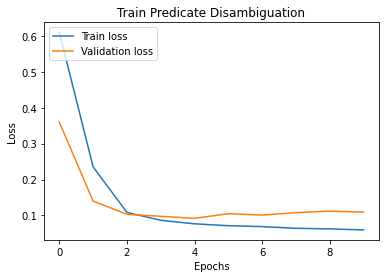

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

###Training and test 3

* Batch size used: 32
* Epochs of training: 10 and 20
* Loss function: cross_entropy
* 2 linear layers and 1 Dropout(0.3) layer of the classifier
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* In the model predicates are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of predicates, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = len(pred_classes)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = PredicateDisambiguation(N_HIDDEN, N_CLASSES, device, BERT)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.417305816469654
Validating...
Validation Loss: 0.219429606364833


epoch: 2/10
Training...
Train Loss: 0.1814223571169761
Validating...
Validation Loss: 0.1483203793565432


epoch: 3/10
Training...
Train Loss: 0.12488721214955853
Validating...
Validation Loss: 0.1111917495727539


epoch: 4/10
Training...
Train Loss: 0.09476906911980722
Validating...
Validation Loss: 0.09796775960259968


epoch: 5/10
Training...
Train Loss: 0.0752146205834804
Validating...
Validation Loss: 0.08387320737044017


epoch: 6/10
Training...
Train Loss: 0.06071579189550492
Validating...
Validation Loss: 0.07966337125334474


epoch: 7/10
Training...
Train Loss: 0.050867683824992946
Validating...
Validation Loss: 0.07289736655851205


epoch: 8/10
Training...
Train Loss: 0.04289162491838778
Validating...
Validation Loss: 0.06920021937953101


epoch: 9/10
Training...
Train Loss: 0.03572017421885844
Validating...
Validation Loss: 0.06548049062904385


epoch: 10/10
Training...


In [ ]:
#Test the model
model.eval()
true, predictions = test(model3, dataset_dev)

Correctly classified: 1991
False Positives: 560
False Negatives: 562
# Precision: 0.78
# Recall: 0.78
# F1: 0.78


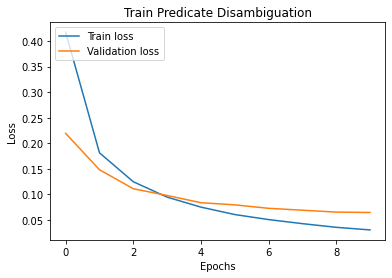

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

Add 10 epochs

In [ ]:
#Train the model
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, 5, loss_train, loss_val)


epoch: 16/20
Training...
Train Loss: 0.01277386828836414
Validating...
Validation Loss: 0.06907686870545149


epoch: 17/20
Training...
Train Loss: 0.011151360936703221
Validating...
Validation Loss: 0.06462485984795624


epoch: 18/20
Training...
Train Loss: 0.009962950966831656
Validating...
Validation Loss: 0.0668417966614167


epoch: 19/20
Training...
Train Loss: 0.008604045512695467
Validating...
Validation Loss: 0.06941069993707868


epoch: 20/20
Training...
Train Loss: 0.007945362163046676
Validating...
Validation Loss: 0.06709626265284088



In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev)

Correctly classified: 2027
False Positives: 526
False Negatives: 526
# Precision: 0.79
# Recall: 0.79
# F1: 0.79


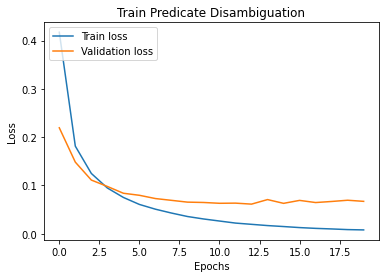

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

### Training and test 4

* Batch size used: 32
* Epochs of training: 10
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* Transformer "bert-base-cased" finetuned
* Adam Optimizer with lr = 0.0001 and weight_decay=0.001
* In the model predicates are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of predicates, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(pred_classes)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model4 = PredicateDisambiguation(N_HIDDEN, N_CLASSES, device, BERT)
model4.to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=0.0001, weight_decay=0.001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model4.train()
loss_train, loss_val = train(model4, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.5709323896515754
Validating...
Validation Loss: 0.34859678314791787


epoch: 2/10
Training...
Train Loss: 0.2103674850636913
Validating...
Validation Loss: 0.11325344070792198


epoch: 3/10
Training...
Train Loss: 0.09654675866326978
Validating...
Validation Loss: 0.09228500289221604


epoch: 4/10
Training...
Train Loss: 0.0775149870063028
Validating...
Validation Loss: 0.08540321720971002


epoch: 5/10
Training...
Train Loss: 0.06892928356124509
Validating...
Validation Loss: 0.08495697689553101


epoch: 6/10
Training...
Train Loss: 0.06246625410933648
Validating...
Validation Loss: 0.08361347599161996


epoch: 7/10
Training...
Train Loss: 0.059450983460391724
Validating...
Validation Loss: 0.08306630907787217


epoch: 8/10
Training...
Train Loss: 0.0561966638771757
Validating...
Validation Loss: 0.08521847468283442


epoch: 9/10
Training...
Train Loss: 0.05339935390699294
Validating...
Validation Loss: 0.08747831359505653


epoch: 10/10
Training

In [ ]:
#Test the model
model4.eval()
true, predictions = test(model4, dataset_dev)

Correctly classified: 2023
False Positives: 390
False Negatives: 530
# Precision: 0.84
# Recall: 0.79
# F1: 0.81


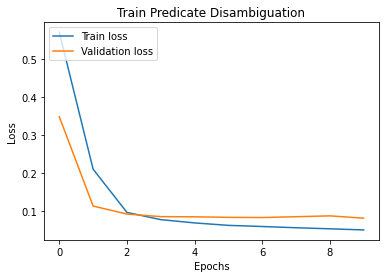

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

In [ ]:
#Train the model
model4.train()
loss_train, loss_val = train(model4, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.5575020117144431
Validating...
Validation Loss: 0.3495652178923289


epoch: 2/10
Training...
Train Loss: 0.20161935177541548
Validating...
Validation Loss: 0.12189202672905392


epoch: 3/10
Training...
Train Loss: 0.10215370229655696
Validating...
Validation Loss: 0.09953775525920922


epoch: 4/10
Training...
Train Loss: 0.08360725006749553
Validating...
Validation Loss: 0.09586483281519678


epoch: 5/10
Training...
Train Loss: 0.07557828782066223
Validating...
Validation Loss: 0.1079475660290983


epoch: 6/10
Training...
Train Loss: 0.07215871253321247
Validating...
Validation Loss: 0.10154373943805695


epoch: 7/10
Training...
Train Loss: 0.06792388829973436
Validating...
Validation Loss: 0.1080961748957634


epoch: 8/10
Training...
Train Loss: 0.06437739852455354
Validating...
Validation Loss: 0.11473590094182226


epoch: 9/10
Training...
Train Loss: 0.06194681001286353
Validating...
Validation Loss: 0.11355254509382778



In [ ]:
#Test the model
model4.eval()
true, predictions = test(model4, dataset_dev)

Correctly classified: 1993
False Positives: 623
False Negatives: 560
# Precision: 0.76
# Recall: 0.78
# F1: 0.77


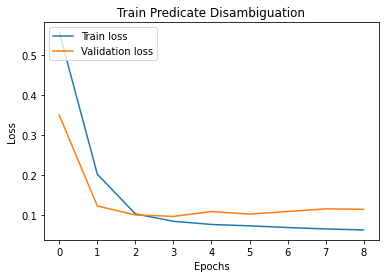

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelPredDisamb.pt"
torch.save(model4, pth_model, pickle_protocol=4)

### Training and test 5

* Batch size used: 32
* Epochs of training: 10 and 20 and 30
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" finetuned
* Adam Optimizer with lr = 0.0001 and weight_decay=0.001
* In the model predicates are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of predicates, '0' otherwise

***OSS.:** this section contains a ***confusion matrix***

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(pred_classes)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model5 = PredicateDisambiguation(N_HIDDEN, N_CLASSES, device, BERT)
model5.to(device)
optimizer = torch.optim.Adam(model5.parameters(), lr=0.0001, weight_decay=0.001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model5.train()
loss_train, loss_val = train(model5, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 1.0036032065268485
Validating...
Validation Loss: 0.5391530444224676


epoch: 2/10
Training...
Train Loss: 0.42178676512933544
Validating...
Validation Loss: 0.3526741746399138


epoch: 3/10
Training...
Train Loss: 0.3507165626172096
Validating...
Validation Loss: 0.3319656766123242


epoch: 4/10
Training...
Train Loss: 0.33787368660972966
Validating...
Validation Loss: 0.32442450192239547


epoch: 5/10
Training...
Train Loss: 0.32682925981860006
Validating...
Validation Loss: 0.3109662069214715


epoch: 6/10
Training...
Train Loss: 0.31253653101382717
Validating...
Validation Loss: 0.29772340423531


epoch: 7/10
Training...
Train Loss: 0.2957076390904765
Validating...
Validation Loss: 0.2826670954624812


epoch: 8/10
Training...
Train Loss: 0.2781038856314075
Validating...
Validation Loss: 0.26793236285448074


epoch: 9/10
Training...
Train Loss: 0.2585891246795654
Validating...
Validation Loss: 0.2506581230296029


epoch: 10/10
Training...
Train L

In [ ]:
#Test the model
model5.eval()
true, predictions = test(model5, dataset_dev)

Correctly classified: 1086
False Positives: 773
False Negatives: 1467
# Precision: 0.58
# Recall: 0.43
# F1: 0.49


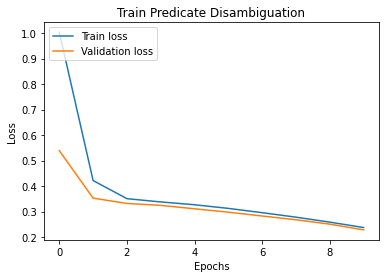

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

Add 10 epochs

In [ ]:
#Train the model
model5.train()
loss_train, loss_val = train(model5, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS, loss_train, loss_val)


epoch: 11/20
Training...
Train Loss: 0.21541944646066236
Validating...
Validation Loss: 0.2086598045296139


epoch: 12/20
Training...
Train Loss: 0.19434631476479192
Validating...
Validation Loss: 0.18965150208936798


epoch: 13/20
Training...
Train Loss: 0.17703869660054483
Validating...
Validation Loss: 0.17864447832107544


epoch: 14/20
Training...
Train Loss: 0.16074636866969447
Validating...
Validation Loss: 0.1699242898159557


epoch: 15/20
Training...
Train Loss: 0.14793229876987396
Validating...
Validation Loss: 0.1577707537346416


epoch: 16/20
Training...
Train Loss: 0.13617474210839117
Validating...
Validation Loss: 0.1565887038078573


epoch: 17/20
Training...
Train Loss: 0.1258026058635404
Validating...
Validation Loss: 0.14734545350074768


epoch: 18/20
Training...
Train Loss: 0.11689353883266448
Validating...
Validation Loss: 0.13580268911189503


epoch: 19/20
Training...
Train Loss: 0.10978035994114414
Validating...
Validation Loss: 0.13337284036808544


epoch: 20/20
T

In [ ]:
#Test the model
model5.eval()
true, predictions = test(model5, dataset_dev)

Correctly classified: 1820
False Positives: 586
False Negatives: 733
# Precision: 0.76
# Recall: 0.71
# F1: 0.73


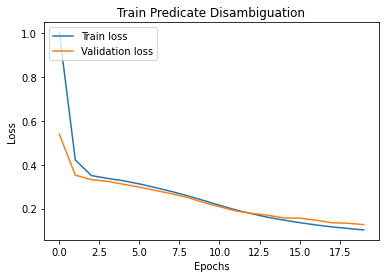

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

Add 10 epochs

In [ ]:
#Train the model
model5.train()
loss_train, loss_val = train(model5, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, 30)


epoch: 1/30
Training...
Train Loss: 1.0517439946051568
Validating...
Validation Loss: 0.5097052653630575


epoch: 2/30
Training...
Train Loss: 0.39837412372712167
Validating...
Validation Loss: 0.3458610392279095


epoch: 3/30
Training...
Train Loss: 0.3471828834664437
Validating...
Validation Loss: 0.3301002201106813


epoch: 4/30
Training...
Train Loss: 0.3351742119558396
Validating...
Validation Loss: 0.32164645360575783


epoch: 5/30
Training...
Train Loss: 0.32195956101340634
Validating...
Validation Loss: 0.3082823654015859


epoch: 6/30
Training...
Train Loss: 0.30520835009313396
Validating...
Validation Loss: 0.2939707264304161


epoch: 7/30
Training...
Train Loss: 0.2865401814060827
Validating...
Validation Loss: 0.2809248028530015


epoch: 8/30
Training...
Train Loss: 0.26578814598821826
Validating...
Validation Loss: 0.2529922616150644


epoch: 9/30
Training...
Train Loss: 0.24547318595070994
Validating...
Validation Loss: 0.23117550710837045


epoch: 10/30
Training...
Trai

In [ ]:
#Test the model
model5.eval()
true, predictions = test(model5, dataset_dev)

Correctly classified: 1896
False Positives: 561
False Negatives: 657
# Precision: 0.77
# Recall: 0.74
# F1: 0.76


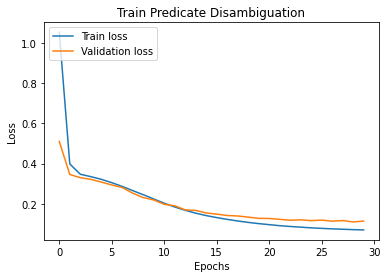

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

Transformer not finetuned

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model5 = PredicateDisambiguation(N_HIDDEN, N_CLASSES, device, BERT)
model5.to(device)
optimizer = torch.optim.Adam(model5.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model5.train()
loss_train, loss_val = train(model5, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.5407569187302743
Validating...
Validation Loss: 0.3449115835958057


epoch: 2/10
Training...
Train Loss: 0.33688157623813997
Validating...
Validation Loss: 0.29832076612446046


epoch: 3/10
Training...
Train Loss: 0.26228479704549235
Validating...
Validation Loss: 0.2235005588995086


epoch: 4/10
Training...
Train Loss: 0.18991481479137173
Validating...
Validation Loss: 0.16121728387143877


epoch: 5/10
Training...
Train Loss: 0.13745642371716038
Validating...
Validation Loss: 0.12376955565479067


epoch: 6/10
Training...
Train Loss: 0.1044666816630671
Validating...
Validation Loss: 0.10110898481474982


epoch: 7/10
Training...
Train Loss: 0.08276212753788117
Validating...
Validation Loss: 0.09410075491501226


epoch: 8/10
Training...
Train Loss: 0.06825915728845904
Validating...
Validation Loss: 0.08366314011315505


epoch: 9/10
Training...
Train Loss: 0.056101147241650086
Validating...
Validation Loss: 0.07693249545991421


epoch: 10/10
Training

In [ ]:
#Test the model
model5.eval()
true, predictions = test(model5, dataset_dev)

Correctly classified: 2008
False Positives: 539
False Negatives: 545
# Precision: 0.79
# Recall: 0.79
# F1: 0.79


Add 20 epochs

In [ ]:
#Train the model
model5.train()
loss_train, loss_val = train(model5, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, 20, loss_train, loss_val)


epoch: 1/30
Training...
Train Loss: 0.5278886681602847
Validating...
Validation Loss: 0.342253726389673


epoch: 2/30
Training...
Train Loss: 0.32980559410587434
Validating...
Validation Loss: 0.2934830461939176


epoch: 3/30
Training...
Train Loss: 0.25471936108604554
Validating...
Validation Loss: 0.20972461915678448


epoch: 4/30
Training...
Train Loss: 0.1833798192201122
Validating...
Validation Loss: 0.15633276229103407


epoch: 5/30
Training...
Train Loss: 0.13617325876989672
Validating...
Validation Loss: 0.12248611657155885


epoch: 6/30
Training...
Train Loss: 0.10523669388025038
Validating...
Validation Loss: 0.10230979323387146


epoch: 7/30
Training...
Train Loss: 0.08496038010043483
Validating...
Validation Loss: 0.09688454783625072


epoch: 8/30
Training...
Train Loss: 0.07026418144664456
Validating...
Validation Loss: 0.08374696990682019


epoch: 9/30
Training...
Train Loss: 0.05826592116105941
Validating...
Validation Loss: 0.07968893585105737


epoch: 10/30
Training..

In [ ]:
#Test the model
model5.eval()
true, predictions = test(model5, dataset_dev)

Correctly classified: 2060
False Positives: 486
False Negatives: 493
# Precision: 0.81
# Recall: 0.81
# F1: 0.81


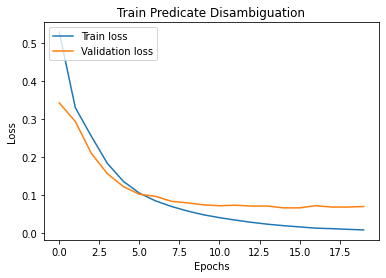

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelPredDisamb.pt"
torch.save(model5, pth_model, pickle_protocol=4)

In [ ]:
with open("/content/drive/MyDrive/predicateclasses.json", "r") as input_file:
  predicate_classes = json.load(input_file)

In [ ]:
new_predictions = []
new_true = []
for p,t in zip(predictions,true):
  new_predictions.append(predicate_classes[str(p)])
  new_true.append(predicate_classes[str(t)])

Confusion Matrix


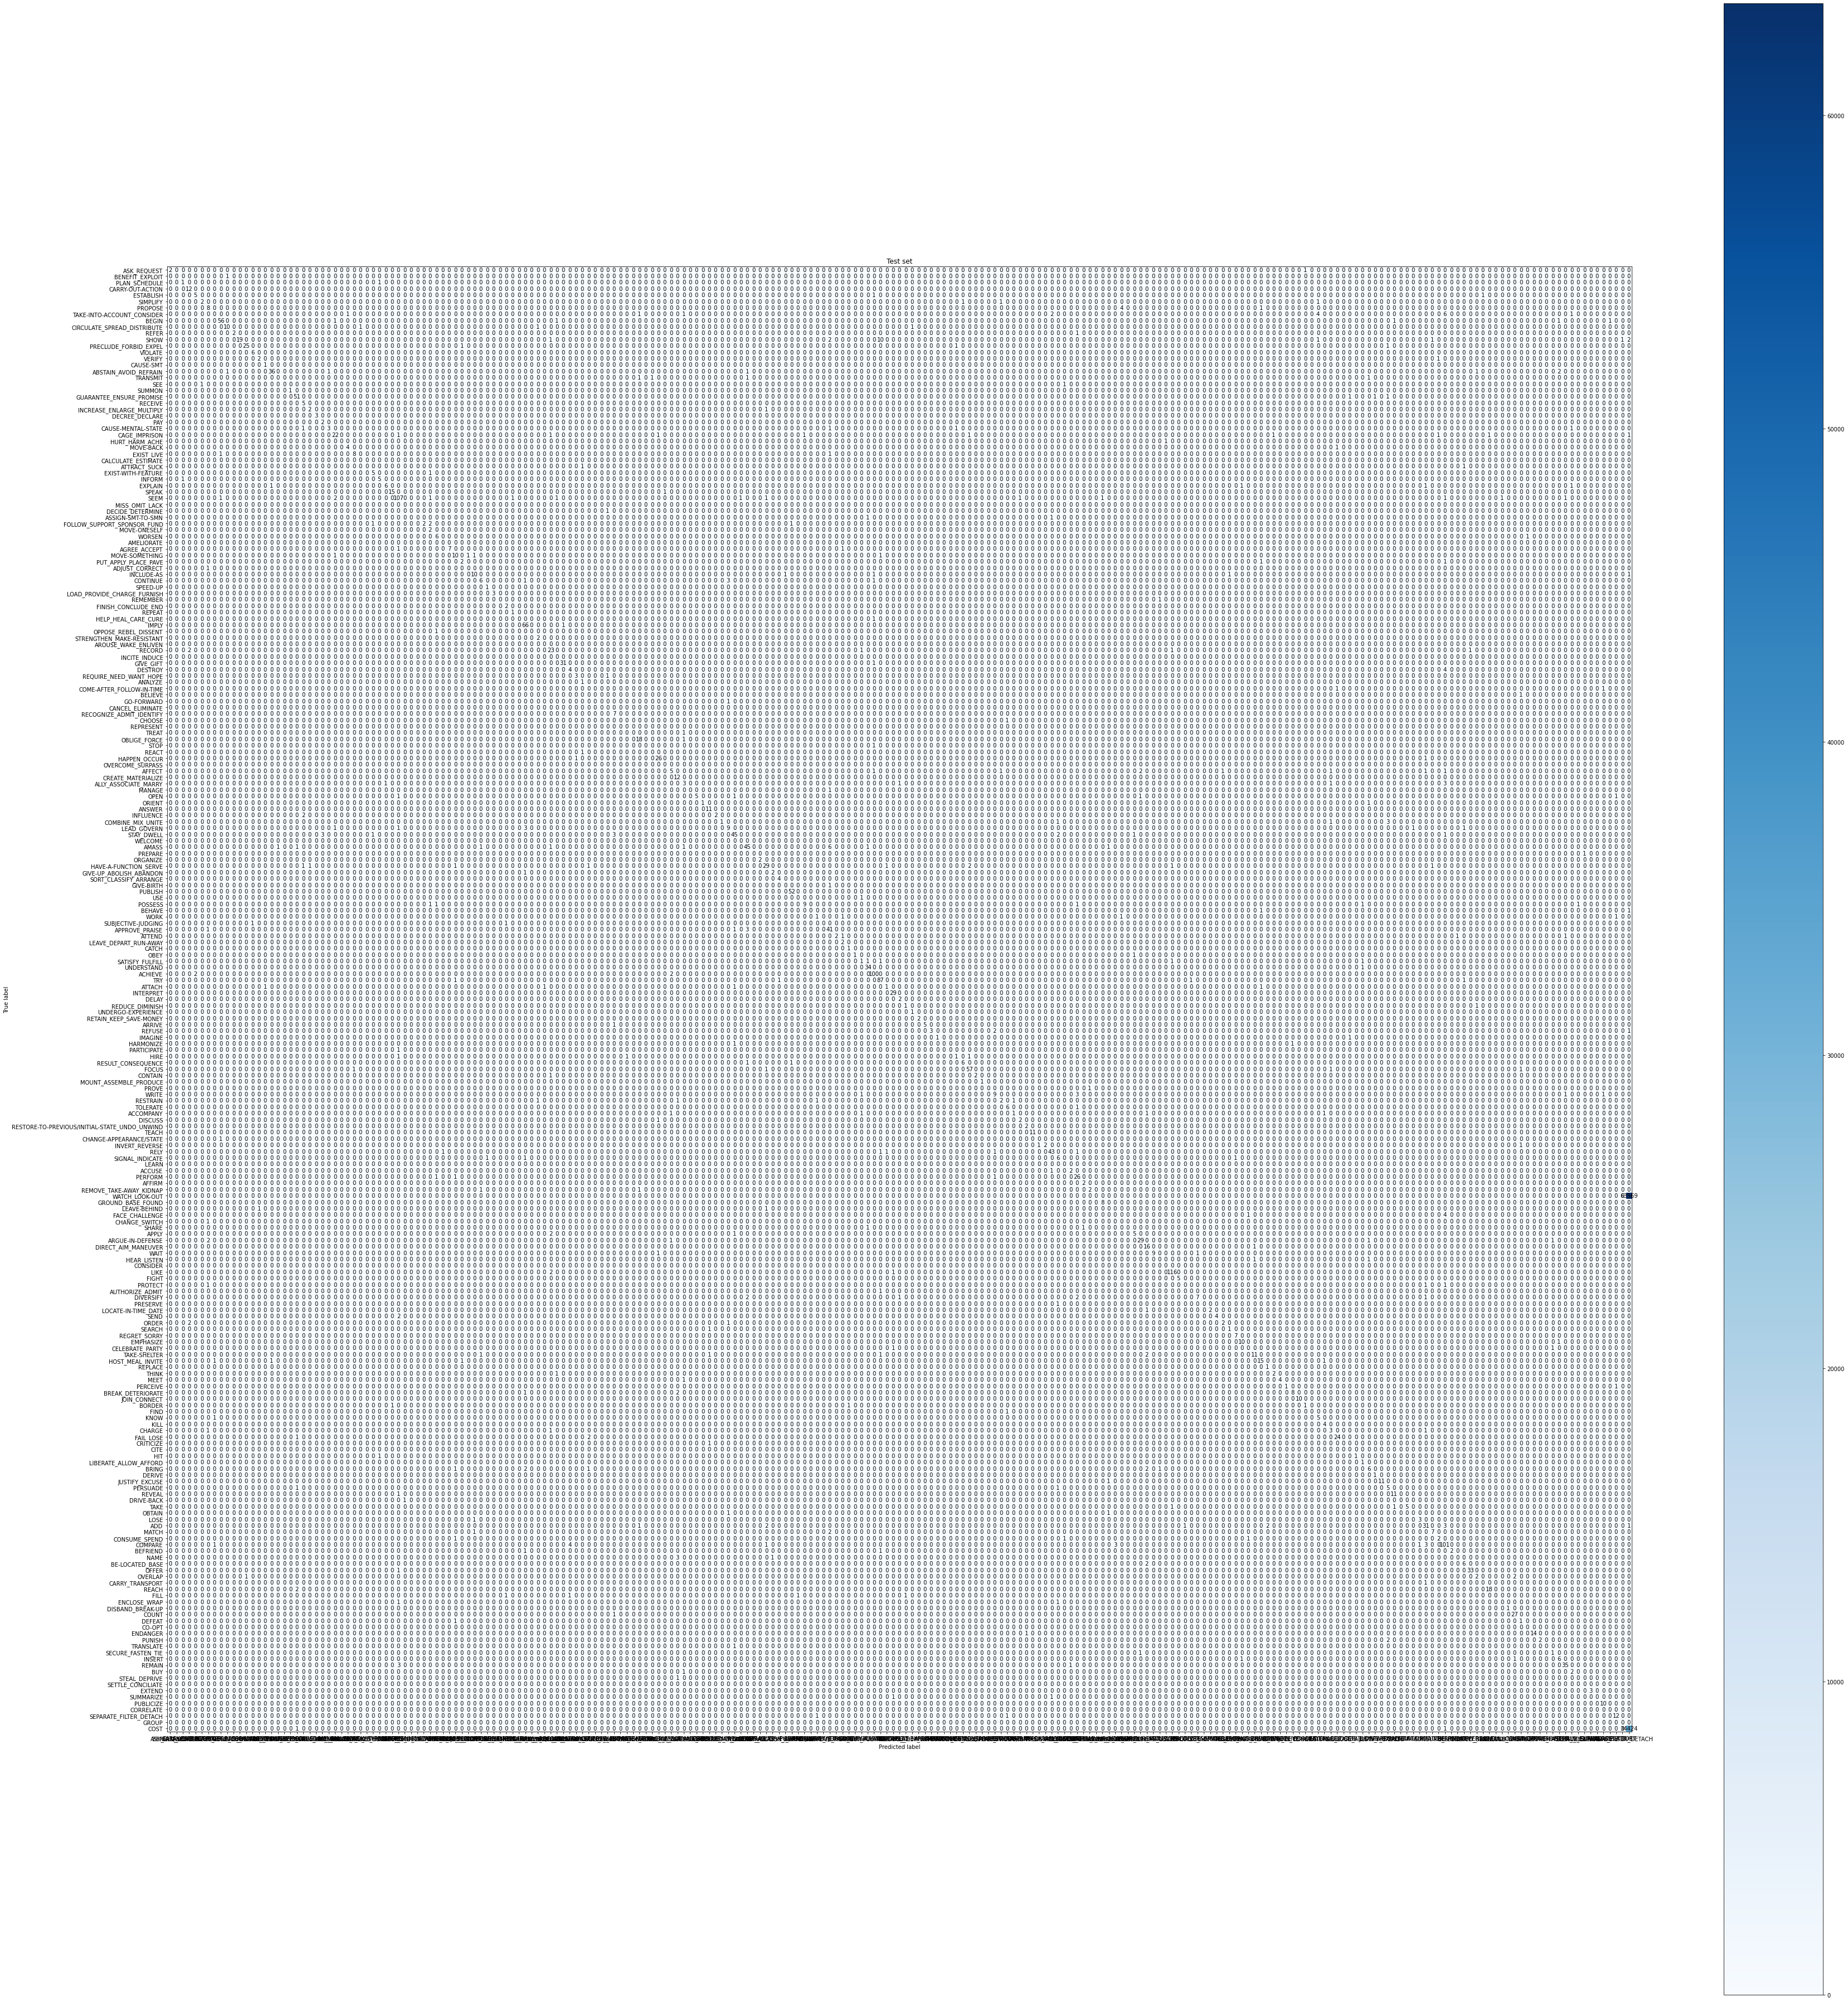

In [ ]:
#confusion matrix
plot_confusion_matrix(np.array(new_true), np.array(new_predictions), pred_classes)

###Training and test 6

* Batch size used: 32
* Epochs of training: 10
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* Transformer "albert-base-v2" finetuned
* Adam Optimizer with lr = 0.0001 and weight_decay=0.001
* In the model predicates are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of predicates, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = len(pred_classes)+2
EPOCHS = 10
LOSS = F.cross_entropy

With transformer fine-tuning


In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model6 = PredicateDisambiguation(N_HIDDEN, N_CLASSES, device, ALBERT)
model6.to(device)
optimizer = torch.optim.Adam(model6.parameters(), lr=0.0001, weight_decay=0.001)

Downloading:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


With a BiLSTM layer

In [ ]:
#Train the model
model6.train()
loss_train, loss_val = train(model6, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.6541826075123203
Validating...
Validation Loss: 0.5614750352170732


epoch: 2/10
Training...
Train Loss: 0.5690101083247893
Validating...
Validation Loss: 0.5265535795026355


epoch: 3/10
Training...
Train Loss: 0.5293424340986437
Validating...
Validation Loss: 0.5511677977111604


epoch: 4/10
Training...
Train Loss: 0.44090266093131036
Validating...
Validation Loss: 0.39208075569735634


epoch: 5/10
Training...
Train Loss: 0.3654903821406826
Validating...
Validation Loss: 0.34093935125403935


epoch: 6/10
Training...
Train Loss: 0.2992587448127808
Validating...
Validation Loss: 0.2353505848182572


epoch: 7/10
Training...
Train Loss: 0.1638692331890906
Validating...
Validation Loss: 0.13146989502840573


epoch: 8/10
Training...
Train Loss: 0.09480561034814004
Validating...
Validation Loss: 0.11170096240109867


epoch: 9/10
Training...
Train Loss: 0.06856181562667893
Validating...
Validation Loss: 0.10737595334649086


epoch: 10/10
Training...
Tra

In [ ]:
#Test the model
model6.eval()
true, predictions = test(model6, dataset_dev)

Correctly classified: 1961
False Positives: 502
False Negatives: 592
# Precision: 0.80
# Recall: 0.77
# F1: 0.78


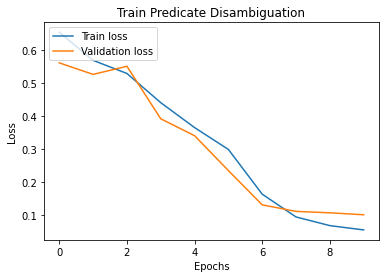

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

Without a BiLSTM layer

In [ ]:
#Train the model
model6.train()
loss_train, loss_val = train(model6, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.6933658438344156
Validating...
Validation Loss: 0.5579937795797983


epoch: 2/10
Training...
Train Loss: 0.5697683384341579
Validating...
Validation Loss: 0.5515268395344416


epoch: 3/10
Training...
Train Loss: 0.5526597920925387
Validating...
Validation Loss: 0.532752063539293


epoch: 4/10
Training...
Train Loss: 0.45935618089091396
Validating...
Validation Loss: 0.34636731776926255


epoch: 5/10
Training...
Train Loss: 0.2764064824388873
Validating...
Validation Loss: 0.1989167051182853


epoch: 6/10
Training...
Train Loss: 0.1423576906323433
Validating...
Validation Loss: 0.12270613552795516


epoch: 7/10
Training...
Train Loss: 0.08334228853064199
Validating...
Validation Loss: 0.1021377042763763


epoch: 8/10
Training...
Train Loss: 0.058844637257918234
Validating...
Validation Loss: 0.09610908602674802


epoch: 9/10
Training...
Train Loss: 0.04750594223939603
Validating...
Validation Loss: 0.11206247471272945


epoch: 10/10
Training...
Tra

In [ ]:
#Test the model
model6.eval()
true, predictions = test(model6, dataset_dev)

Correctly classified: 2032
False Positives: 535
False Negatives: 521
# Precision: 0.79
# Recall: 0.80
# F1: 0.79


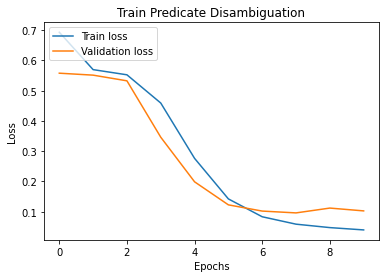

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

No transformer fine-tuning

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model6 = PredicateDisambiguation(N_HIDDEN, N_CLASSES, device, ALBERT)
model6.to(device)
optimizer = torch.optim.Adam(model6.parameters())

Downloading:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.weight', 'predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Without BiLSTM layer 

In [ ]:
#Train the model
model6.train()
loss_train, loss_val = train(model6, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.6421431945216272
Validating...
Validation Loss: 0.3991221934556961


epoch: 2/10
Training...
Train Loss: 0.34544332565799835
Validating...
Validation Loss: 0.31244295338789624


epoch: 3/10
Training...
Train Loss: 0.27234035643839066
Validating...
Validation Loss: 0.26761006977823043


epoch: 4/10
Training...
Train Loss: 0.22512467368956535
Validating...
Validation Loss: 0.23740698314375347


epoch: 5/10
Training...
Train Loss: 0.19287846386432647
Validating...
Validation Loss: 0.22651311341259214


epoch: 6/10
Training...
Train Loss: 0.16862476881473296
Validating...
Validation Loss: 0.20561622414324018


epoch: 7/10
Training...
Train Loss: 0.14861765994179632
Validating...
Validation Loss: 0.19465967350535923


epoch: 8/10
Training...
Train Loss: 0.13289163016503858
Validating...
Validation Loss: 0.1786606895426909


epoch: 9/10
Training...
Train Loss: 0.12014712354829235
Validating...
Validation Loss: 0.17928879294130537


epoch: 10/10
Training

In [ ]:
#Test the model
model6.eval()
true, predictions = test(model6, dataset_dev)

Correctly classified: 1369
False Positives: 338
False Negatives: 1184
# Precision: 0.80
# Recall: 0.54
# F1: 0.64


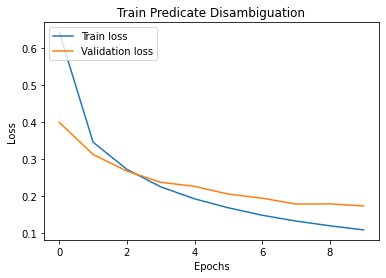

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

With BiLSTM layer

In [ ]:
#Train the model
model6.train()
loss_train, loss_val = train(model6, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.6298194939090359
Validating...
Validation Loss: 0.43789192537466687


epoch: 2/10
Training...
Train Loss: 0.37928874819509445
Validating...
Validation Loss: 0.3355590949455897


epoch: 3/10
Training...
Train Loss: 0.3325839690623745
Validating...
Validation Loss: 0.3096881823407279


epoch: 4/10
Training...
Train Loss: 0.2945331731150227
Validating...
Validation Loss: 0.271143919063939


epoch: 5/10
Training...
Train Loss: 0.24958579646002862
Validating...
Validation Loss: 0.22697737647427452


epoch: 6/10
Training...
Train Loss: 0.2101419904539662
Validating...
Validation Loss: 0.19200523528787825


epoch: 7/10
Training...
Train Loss: 0.17715984741526267
Validating...
Validation Loss: 0.17034993196527162


epoch: 8/10
Training...
Train Loss: 0.15033900665660058
Validating...
Validation Loss: 0.1449263696041372


epoch: 9/10
Training...
Train Loss: 0.12716952778639332
Validating...
Validation Loss: 0.13340615729490915


epoch: 10/10
Training...
Tr

In [ ]:
#Test the model
model6.eval()
true, predictions = test(model6, dataset_dev)

Correctly classified: 1682
False Positives: 810
False Negatives: 871
# Precision: 0.67
# Recall: 0.66
# F1: 0.67


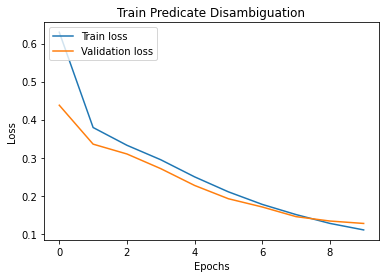

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

###Training and test 7

* Batch size used: 32
* Epochs of training: 10
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* Transformer "roberta-base" finetuned
* Adam Optimizer with lr = 0.0001 and weight_decay=0.001
* In the model predicates are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of predicates, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = len(pred_classes)+2
EPOCHS = 10
LOSS = F.cross_entropy

Transformer not fine-tuned

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model7 = PredicateDisambiguation(N_HIDDEN, N_CLASSES, device, RoBERTa)
model7.to(device)
optimizer = torch.optim.Adam(model7.parameters())

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


With BiLSTM layer

In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.5599747617398539
Validating...
Validation Loss: 0.36628854771455127


epoch: 2/10
Training...
Train Loss: 0.33958503642389853
Validating...
Validation Loss: 0.3058600632680787


epoch: 3/10
Training...
Train Loss: 0.2725639124070444
Validating...
Validation Loss: 0.23119128826591703


epoch: 4/10
Training...
Train Loss: 0.205267354173045
Validating...
Validation Loss: 0.17946376320388582


epoch: 5/10
Training...
Train Loss: 0.1575588937247953
Validating...
Validation Loss: 0.14118947999344933


epoch: 6/10
Training...
Train Loss: 0.12668148115757974
Validating...
Validation Loss: 0.12866605983840096


epoch: 7/10
Training...
Train Loss: 0.10762373930023562
Validating...
Validation Loss: 0.1168788547317187


epoch: 8/10
Training...
Train Loss: 0.09078861660053653
Validating...
Validation Loss: 0.10801812302735117


epoch: 9/10
Training...
Train Loss: 0.0782962272244115
Validating...
Validation Loss: 0.10275051556527615


epoch: 10/10
Training...
T

In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev)

Correctly classified: 1918
False Positives: 631
False Negatives: 635
# Precision: 0.75
# Recall: 0.75
# F1: 0.75


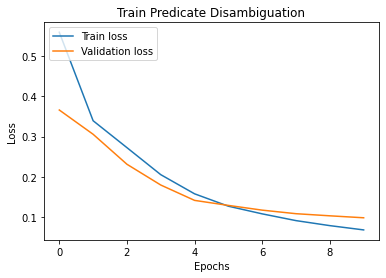

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

Without BiLSTM layer

In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 1.070475628491371
Validating...
Validation Loss: 0.4212634977367189


epoch: 2/10
Training...
Train Loss: 0.32397261550349576
Validating...
Validation Loss: 0.2628685459494591


epoch: 3/10
Training...
Train Loss: 0.22522092000130683
Validating...
Validation Loss: 0.20703294624884924


epoch: 4/10
Training...
Train Loss: 0.17908119424696892
Validating...
Validation Loss: 0.17821019887924194


epoch: 5/10
Training...
Train Loss: 0.15218873163384775
Validating...
Validation Loss: 0.15891972680886587


epoch: 6/10
Training...
Train Loss: 0.13249522976336942
Validating...
Validation Loss: 0.14867700926131672


epoch: 7/10
Training...
Train Loss: 0.11797069450539928
Validating...
Validation Loss: 0.1397844341893991


epoch: 8/10
Training...
Train Loss: 0.10693420243840064
Validating...
Validation Loss: 0.13213873364859158


epoch: 9/10
Training...
Train Loss: 0.09707854063280168
Validating...
Validation Loss: 0.12365254428651598


epoch: 10/10
Training..

In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev)

Correctly classified: 1840
False Positives: 452
False Negatives: 713
# Precision: 0.80
# Recall: 0.72
# F1: 0.76


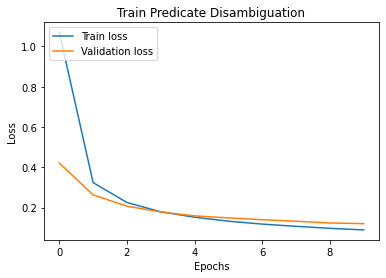

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

Transformer fine-tuned

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model7 = PredicateDisambiguation(N_HIDDEN, N_CLASSES, device, RoBERTa)
model7.to(device)
optimizer = torch.optim.Adam(model7.parameters(), lr=0.0001, weight_decay=0.001)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Without BiLSTM layer

In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.624145354570881
Validating...
Validation Loss: 0.3674016131295098


epoch: 2/10
Training...
Train Loss: 0.27739018942079235
Validating...
Validation Loss: 0.20542862763007483


epoch: 3/10
Training...
Train Loss: 0.17932656263151475
Validating...
Validation Loss: 0.16138140194945866


epoch: 4/10
Training...
Train Loss: 0.14896724541341105
Validating...
Validation Loss: 0.15229638210601276


epoch: 5/10
Training...
Train Loss: 0.13807796951263182
Validating...
Validation Loss: 0.14766524359583855


epoch: 6/10
Training...
Train Loss: 0.13073435401724232
Validating...
Validation Loss: 0.14504538103938103


epoch: 7/10
Training...
Train Loss: 0.1293960468422982
Validating...
Validation Loss: 0.14288991482721436


epoch: 8/10
Training...
Train Loss: 0.12837838573801902
Validating...
Validation Loss: 0.14253457801209557


epoch: 9/10
Training...
Train Loss: 0.125431449567118
Validating...
Validation Loss: 0.14537754365139538


epoch: 10/10
Training...

In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev)

Correctly classified: 1776
False Positives: 676
False Negatives: 777
# Precision: 0.72
# Recall: 0.70
# F1: 0.71


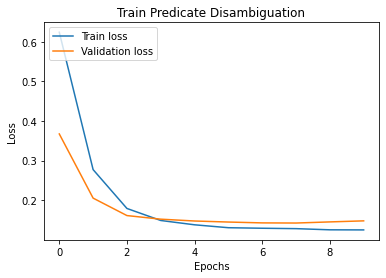

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

With BiLSTM layer

In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.8589136538967009
Validating...
Validation Loss: 0.5738648490773307


epoch: 2/10
Training...
Train Loss: 0.486972951504492
Validating...
Validation Loss: 0.3858877652221256


epoch: 3/10
Training...
Train Loss: 0.3809910568498796
Validating...
Validation Loss: 0.36942847238646614


epoch: 4/10
Training...
Train Loss: 0.36971129717365386
Validating...
Validation Loss: 0.36021366384294295


epoch: 5/10
Training...
Train Loss: 0.36236122692784956
Validating...
Validation Loss: 0.35474594434102374


epoch: 6/10
Training...
Train Loss: 0.35442709903563224
Validating...
Validation Loss: 0.3458821740415361


epoch: 7/10
Training...
Train Loss: 0.34395061231428575
Validating...
Validation Loss: 0.33815564546320176


epoch: 8/10
Training...
Train Loss: 0.3241012090636838
Validating...
Validation Loss: 0.31180624415477115


epoch: 9/10
Training...
Train Loss: 0.30702780956222164
Validating...
Validation Loss: 0.29678843584325576


epoch: 10/10
Training...
T

In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev)

Correctly classified: 536
False Positives: 1593
False Negatives: 2017
# Precision: 0.25
# Recall: 0.21
# F1: 0.23


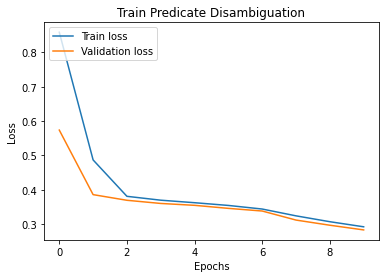

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

##Transfer learning for Spanish

In [ ]:
#process data
data, labels = encode_data(wordsES, predES, BERT)
data_dev, labels_dev = encode_data(words_devES, pred_devES, BERT)

In [ ]:
#define datasets with its batch size

BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = len(pred_classes)+2
EPOCHS = 20
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
modelPredDisamb = torch.load("/content/drive/MyDrive/modelPredDisamb.pt")
modelPredDisamb.to(device)
optimizer = torch.optim.Adam(modelPredDisamb.parameters())

In [ ]:
#Train the model
modelPredDisamb.train()
loss_train, loss_val = train(modelPredDisamb, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/20
Training...
Train Loss: 0.46476829051971436
Validating...
Validation Loss: 0.2849656194448471


epoch: 2/20
Training...
Train Loss: 0.3325288700205939
Validating...
Validation Loss: 0.2469930425286293


epoch: 3/20
Training...
Train Loss: 0.26961677574685644
Validating...
Validation Loss: 0.24211004376411438


epoch: 4/20
Training...
Train Loss: 0.25307975869093624
Validating...
Validation Loss: 0.22129252552986145


epoch: 5/20
Training...
Train Loss: 0.2628410192472594
Validating...
Validation Loss: 0.2148110643029213


epoch: 6/20
Training...
Train Loss: 0.2417501455971173
Validating...
Validation Loss: 0.23021035641431808


epoch: 7/20
Training...
Train Loss: 0.25501993617841173
Validating...
Validation Loss: 0.22887657582759857


epoch: 8/20
Training...
Train Loss: 0.2266954407095909
Validating...
Validation Loss: 0.2274247407913208


epoch: 9/20
Training...
Train Loss: 0.23421304672956467
Validating...
Validation Loss: 0.2325332686305046


epoch: 10/20
Training...
Tr

In [ ]:
#Test the model
modelPredDisamb.eval()
true, predictions = test(modelPredDisamb, dataset_dev)

Correctly classified: 658
False Positives: 1817
False Negatives: 1832
# Precision: 0.27
# Recall: 0.26
# F1: 0.27


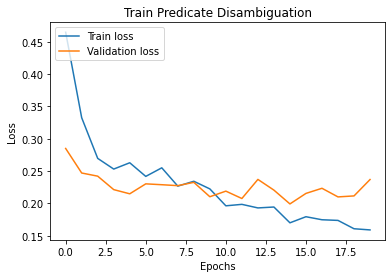

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelPredDisambES.pt"
torch.save(modelPredDisamb, pth_model, pickle_protocol=4)

##Transfer learning for French

In [ ]:
#process data
data, labels = encode_data(wordsFR, predFR, BERT)
data_dev, labels_dev = encode_data(words_devFR, pred_devFR, BERT)

In [ ]:
#define datasets with its batch size

BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 400
N_CLASSES = len(pred_classes)+2
EPOCHS = 20
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
modelPredDisamb = torch.load("/content/drive/MyDrive/modelPredDisamb.pt")
modelPredDisamb.to(device)
optimizer = torch.optim.Adam(modelPredDisamb.parameters())

In [ ]:
#Train the model
modelPredDisamb.train()
loss_train, loss_val = train(modelPredDisamb, optimizer, dataset_train, dataset_val, LOSS, N_CLASSES, EPOCHS)


epoch: 1/20
Training...
Train Loss: 0.42408881336450577
Validating...
Validation Loss: 0.3225734829902649


epoch: 2/20
Training...
Train Loss: 0.2902171877878053
Validating...
Validation Loss: 0.2765326052904129


epoch: 3/20
Training...
Train Loss: 0.252856477030686
Validating...
Validation Loss: 0.24483878165483475


epoch: 4/20
Training...
Train Loss: 0.2567165195941925
Validating...
Validation Loss: 0.2380107194185257


epoch: 5/20
Training...
Train Loss: 0.22396372790847505
Validating...
Validation Loss: 0.21674606949090958


epoch: 6/20
Training...
Train Loss: 0.21977230267865316
Validating...
Validation Loss: 0.24014510214328766


epoch: 7/20
Training...
Train Loss: 0.20720353722572327
Validating...
Validation Loss: 0.21725952625274658


epoch: 8/20
Training...
Train Loss: 0.2092198378273419
Validating...
Validation Loss: 0.22242844849824905


epoch: 9/20
Training...
Train Loss: 0.2065673087324415
Validating...
Validation Loss: 0.23072876781225204


epoch: 10/20
Training...
Tr

In [ ]:
#Test the model
modelPredDisamb.eval()
true, predictions = test(modelPredDisamb, dataset_dev)

Correctly classified: 695
False Positives: 1854
False Negatives: 1854
# Precision: 0.27
# Recall: 0.27
# F1: 0.27


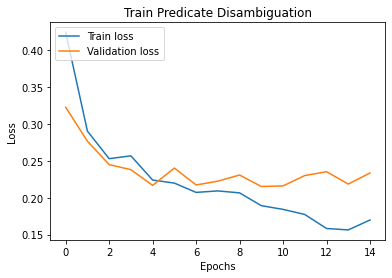

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelPredDisambFR.pt"
torch.save(modelPredDisamb, pth_model, pickle_protocol=4)

#**Argument Identification**

##Process data and prepare dataset

In [ ]:
#process data

'''
- args:
  - sentences: list of strings ("lemmas" or "words")
  - roles: list of strings (roles)
  - predicates: list of string (predicates)
  - languages_model: transformer to use to tokenization

-output:
  -sentences_with_mask: list of dictionaries (each element has keys "input_ids" and "attention_mask")
  -labels: list tensor of tensors with all labels
'''

def encode_data(sentences: list, roles: list, predicates: list, language_model: str):

  #use the transformer tokanizer
  tokenizer = AutoTokenizer.from_pretrained(language_model)

  sent = sentences.copy()
  rol = roles.copy()
  pred = predicates.copy()

  #find max lenght between all data in dataset to add padding later
  max_len = 0
  for s in sent:
      max_len = max(max_len, len(s))

  #convert tokens into ids with the tokanizer
  tokens_list = []
  for s in sent:
    si = s.copy()
    tokens = []
    for i in si:
      tokens.append(tokenizer(i)[0].ids[1])
    #add padding
    while len(tokens)<max_len:
      tokens.append(0)

    tokens_list.append(tokens)

  #create a mask to divide useful tokens from padding
  masks = []
  for ti in tokens_list:
    mask = []
    for tj in ti:
      if tj!=0:
        mask.append(1)
      else:
        mask.append(0)
        
    masks.append(mask)

  assert len(tokens_list)==len(masks)

  #create a list of predicates with "0" if there are not predicate, "1" otherwise
  new_pred = []
  for p in pred:
    l = []
    for pi in p:
      if pi=="_":
        l.append(0)
      else:
        l.append(1)
    #add padding
    while len(l)<max_len:
      l.append(0)
    new_pred.append(l)

  new_pred = torch.tensor(new_pred)
  
  #store ids and mask into a dictionary
  sentences_with_masks = []
  for t,m,p in zip(tokens_list,masks,new_pred):
    ti = torch.tensor(t)
    mi = torch.tensor(m)
    sentences_with_masks.append({"input_ids":ti,"attention_mask":mi,"predicates":p})

  #process labels indicating with "1" a predicate and with "0" other words
  labels = []

  for role in rol:
    r = role.copy()
    label = []
    for _ in range(max_len):
      label.append(0)
    for ri in r.values():
      for i in range(len(ri)):
        if ri[i] !="_":
          label[i] = 1

    labels.append(label)

  labels = torch.tensor(labels)

  return sentences_with_masks, labels

In [ ]:
#process data
data, labels = encode_data(words, rol, pred, BERT)
data_dev, labels_dev = encode_data(words_dev, rol_dev, pred_dev, BERT)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
#organize dataset with batches

BATCH = 32
#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

In [ ]:
#Duplicate data for each predciate in every sentence
new_words, new_pred, new_roles = duplicate_data(words, pred, rol)
new_words_dev, new_pred_dev, new_roles_dev = duplicate_data(words_dev, pred_dev, rol_dev)

In [ ]:
#process data duplicated
data2, labels2 = encode_data(new_words, new_roles, new_pred, BERT)
data_dev2, labels_dev2 = encode_data(new_words_dev, new_roles_dev, new_pred_dev, BERT)

In [ ]:
#organize dataset with batches (for duplicated data)
BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data2, labels2, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train2 = create_dataset(x_train, y_train, BATCH)
dataset_val2 = create_dataset(x_val, y_val, BATCH)
dataset_dev2 = create_dataset(data_dev2, labels_dev2, BATCH)

##Train and test function

In [ ]:
#train function

'''
- args:
  - model: an instance eof the model
  - optimizer: an instance of the optimizer
  - data_train: dataset for train 
  - data_val: dataset for validation
  - loss_f: loss function
  - epochs: (int) numer of epochs (default is 10)
  - train_loss: list of train losses if the training continue from previous one, None otherwise
  - val_loss: list of validation losses if the training continue from previous one, None otherwise

-output:
  - tot_loss_train: list of train losses
  - tot_loss_val: list of validation losses
'''

def train(model, optimizer, data_train, data_val, loss_f, epochs: int = 10, train_loss = None, val_loss = None):

    #To store losses if call the train to continue a previous training or start new one
    if train_loss == None and val_loss == None: 
      tot_loss_train = []
      tot_loss_val = []
      epochs_done = 0
    else:
      tot_loss_train = train_loss
      tot_loss_val = val_loss
      assert len(tot_loss_train) == len(tot_loss_val)
      epochs_done = len(tot_loss_train)

    #Variables for early stopping
    best_validation_loss = float('inf')
    counter = 0
    patience = 5
    
    #main loop
    for epoch in range(epochs):

        print("\nepoch: "+str(epoch+1+epochs_done)+"/"+str(epochs+epochs_done))

        #training loop
        print("Training...")
        loss_train = []

        #process data
        for x, y in data_train:
            optimizer.zero_grad()
            input = {k: v.to(device) for k, v in x.items()}
            out = model(**input)
            out = out.type(torch.float).to(device)
            y = y.type(torch.float).to(device)
            loss = loss_f(out, y)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        #loss of the batch
        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        #validation loop
        print("Validating...")
        loss_val = []

        #process data
        for x, y in data_val:
          with torch.no_grad():
            input = {k: v.to(device) for k, v in x.items()}
            out = model(**input)
            y = y.type(torch.float).to(device)
            loss = loss_f(out, y)
            loss_val.append(loss.item())

        #loss of the batch
        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")

        #Early Stopping
        if lv < best_validation_loss:
          best_validation_loss = lv
          counter = 0
        else:
          counter = counter+1
        if counter >= patience:
          break

    return tot_loss_train, tot_loss_val

In [ ]:
#test function

'''
- input:
  - model: an instance of the model
  - dataloader: dataset for test

- output:
  - true: list of true labels (int)
  - pred: list of predictions (int)
'''

def test(model: nn.Module, dataloader: DataLoader):

  num_correctly = 0   #number of correctly predicted
  num_predicted = 0   #number of total predicted
  num_gold = 0        #number of true labels
  pred = []           #list of predictions
  true = []           #list of true labels

  for x, y in dataloader:

      #predict data
      with torch.no_grad():
          input = {k: v.to(device) for k, v in x.items()}
          out = model(**input)
          out = torch.round(out)

      #check the predictions with true labels to compute F1 metric
      for elem_pred, elem_true in zip(out, y):

          for e_pred, e_true in zip(elem_pred, elem_true):

            e_pred = e_pred.item()
            e_true = e_true.item()
            
            if e_pred == 1 and e_true == 1: 
              num_correctly += 1
            if e_pred == 1:
              num_predicted +=1
            if e_true == 1:
              num_gold += 1

            true.append(e_true)
            pred.append(e_pred)

  print("Correctly classified: "+str(num_correctly))
  print("Predicted: "+str(num_predicted))
  print("Gold: "+str(num_gold))

  precision = num_correctly/num_predicted
  recall = num_correctly/num_gold
  F1 = 2*(precision*recall)/(precision+recall)

  print(f'# Precision: {precision:.2f}')
  print(f'# Recall: {recall:.2f}')
  print(f'# F1: {F1:.2f}')
  
  return true, pred

##Model

In [ ]:
class ArgumentIdentifier(torch.nn.Module):

    def __init__(self, n_hidden, classes, device, language_model_name="bert-base-cased"):
        super(ArgumentIdentifier, self).__init__()

        #Transformer
        self.transformer_model = AutoModel.from_pretrained(language_model_name, output_hidden_states=True)

        #Freeze transformer
        for param in self.transformer_model.parameters():
          param.requires_grad = False

        #Number of features in output from the transformer
        self.embedding_dim = self.transformer_model.config.hidden_size

        #Additive feature to represent where is a predicate
        self.add_features = 1

        #BiLSTM layer
        self.lstm = nn.LSTM(self.embedding_dim+self.add_features, n_hidden, bidirectional = True, num_layers = 2, dropout=0.3, batch_first = True)

        #Linear classifier
        self.hidden1 = torch.nn.Linear(2*n_hidden, classes)
        #self.hidden2 = torch.nn.Linear(n_hidden, classes)

    def forward(self, 
                input_ids: torch.Tensor = None,
                attention_mask: torch.Tensor = None,
                predicates: torch.Tensor = None):
      
        dict_input = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }

        out = self.transformer_model(**dict_input)

        out = torch.stack(out[-4:-2], dim=0)
        out = torch.sum(out, dim = 0)

        #associate a tensor of shape (1) with '1' in correspondence with the predicates and '0' otherwise
        o = []

        for oi,pid in zip(out, predicates):
          new_pred_id = []
          for p in pid:
            p = p.item()
            if p!=0 and p!=-100:
              new_pred_id.append(torch.ones(self.add_features))
            else:
              new_pred_id.append(torch.zeros(self.add_features))
          new_pred_id = torch.stack(new_pred_id).to(device)
          o.append(torch.cat((oi,new_pred_id),dim=1))

        out = torch.stack(o).to(device)

        out, _ = self.lstm(out)
        out = self.hidden1(out)
        #out = torch.relu(out)
        #out = self.hidden2(out)
        out = torch.sigmoid(out)

        return out.squeeze()

###Training and test 1

* Batch size used: 32
* Epochs of training: 10
* Loss function: Mean Squared Error
* Activation function: sigmoid
* 2 linear layer of the classifier
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ArgumentIdentifier(N_HIDDEN, N_CLASSES, device, BERT)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model.train()
loss_train, loss_val = train(model, optimizer, dataset_train2, dataset_val2, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.02117907043841094
Validating...
Validation Loss: 0.019387274072505532


epoch: 2/10
Training...
Train Loss: 0.0168324946899409
Validating...
Validation Loss: 0.014937869203276933


epoch: 3/10
Training...
Train Loss: 0.014837575897490237
Validating...
Validation Loss: 0.014444556343369186


epoch: 4/10
Training...
Train Loss: 0.014460064220836776
Validating...
Validation Loss: 0.014234061329625547


epoch: 5/10
Training...
Train Loss: 0.014157972369595604
Validating...
Validation Loss: 0.013917375938035548


epoch: 6/10
Training...
Train Loss: 0.013949194167987943
Validating...
Validation Loss: 0.013729187427088618


epoch: 7/10
Training...
Train Loss: 0.013821470806385669
Validating...
Validation Loss: 0.013816877687349915


epoch: 8/10
Training...
Train Loss: 0.013695418505829438
Validating...
Validation Loss: 0.01357590607367456


epoch: 9/10
Training...
Train Loss: 0.013586531335351157
Validating...
Validation Loss: 0.013565845182165503


epoc

In [ ]:
#Test the model
model.eval()
true, predictions = test(model2, dataset_dev2)

Correctly classified: 922
Predicted: 1412
Gold: 5013
# Precision: 0.65
# Recall: 0.18
# F1: 0.29


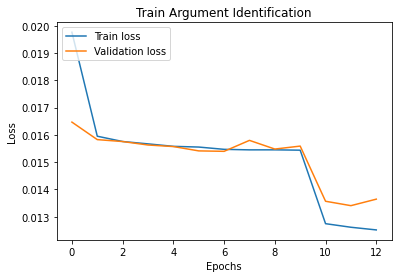

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Identification")

###Training and test 2

* Batch size used: 32
* Epochs of training: 10
* Loss function: Mean Squared Error
* Activation function: sigmoid
* 2 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer with lr = 0.0001

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = ArgumentIdentifier(N_HIDDEN, N_CLASSES, device, BERT)
model2.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model2.train()
loss_train, loss_val = train(model2, optimizer, dataset_train2, dataset_val2, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.025223178904777193
Validating...
Validation Loss: 0.018331745825707912


epoch: 2/10
Training...
Train Loss: 0.017937970466090965
Validating...
Validation Loss: 0.01739629087969661


epoch: 3/10
Training...
Train Loss: 0.01643023775143307
Validating...
Validation Loss: 0.014786605210974812


epoch: 4/10
Training...
Train Loss: 0.014340154126833725
Validating...
Validation Loss: 0.013840058399364353


epoch: 5/10
Training...
Train Loss: 0.01369486936225982
Validating...
Validation Loss: 0.013434101920574903


epoch: 6/10
Training...
Train Loss: 0.013334726454363873
Validating...
Validation Loss: 0.013256841572001576


epoch: 7/10
Training...
Train Loss: 0.013052731826059562
Validating...
Validation Loss: 0.013179527455940842


epoch: 8/10
Training...
Train Loss: 0.01288235705545814
Validating...
Validation Loss: 0.013015853776596486


epoch: 9/10
Training...
Train Loss: 0.012687041592589543
Validating...
Validation Loss: 0.012886091344989836


epoc

In [ ]:
#Test the model
model2.eval()
true, predictions = test(model2, dataset_dev2)

Correctly classified: 1814
Predicted: 3156
Gold: 5013
# Precision: 0.57
# Recall: 0.36
# F1: 0.44


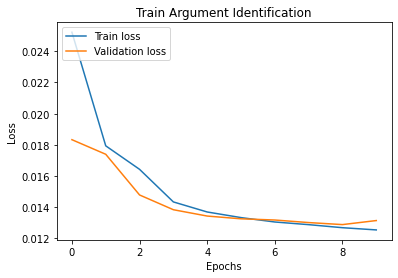

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Identification")

###Training and test 3

* Batch size used: 32
* Epochs of training: 10
* Loss function: Mean Squared Error
* Activation function: sigmoid
* 1 linear layer of the classifier
* 2 BiLSTM layer
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* In the model predicates are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of predicates, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 10
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = ArgumentIdentifier(N_HIDDEN, N_CLASSES, device, BERT)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train2, dataset_val2, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.017783644940640966
Validating...
Validation Loss: 0.007769423990976065


epoch: 2/10
Training...
Train Loss: 0.006065346424909845
Validating...
Validation Loss: 0.004976253397762776


epoch: 3/10
Training...
Train Loss: 0.004802188830776403
Validating...
Validation Loss: 0.0045902167679741975


epoch: 4/10
Training...
Train Loss: 0.004178392979063851
Validating...
Validation Loss: 0.004130749512114562


epoch: 5/10
Training...
Train Loss: 0.0037377563737317036
Validating...
Validation Loss: 0.0041206763562513515


epoch: 6/10
Training...
Train Loss: 0.003440656117821312
Validating...
Validation Loss: 0.0039617688191356136


epoch: 7/10
Training...
Train Loss: 0.003202456862884074
Validating...
Validation Loss: 0.003824748779879883


epoch: 8/10
Training...
Train Loss: 0.0030325804355272783
Validating...
Validation Loss: 0.003812306898180395


epoch: 9/10
Training...
Train Loss: 0.002875773539525946
Validating...
Validation Loss: 0.0037305806268705

In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev2)

Correctly classified: 4225
Predicted: 4724
Gold: 4842
# Precision: 0.89
# Recall: 0.87
# F1: 0.88


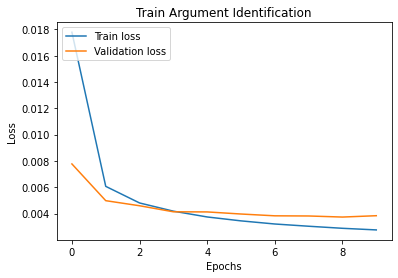

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Identification")

With transformer fine-tune

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = ArgumentIdentifier(N_HIDDEN, N_CLASSES, device, BERT)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train2, dataset_val2, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.02083389457883471
Validating...
Validation Loss: 0.01828739121556282


epoch: 2/10
Training...
Train Loss: 0.01821814440874814
Validating...
Validation Loss: 0.018076027766801415


epoch: 3/10
Training...
Train Loss: 0.01812491257080419
Validating...
Validation Loss: 0.018081683898344636


epoch: 4/10
Training...
Train Loss: 0.018093560048836773
Validating...
Validation Loss: 0.01825845814310014


epoch: 5/10
Training...
Train Loss: 0.018193714252257416
Validating...
Validation Loss: 0.018052046420052648


epoch: 6/10
Training...
Train Loss: 0.01731672683088793
Validating...
Validation Loss: 0.016466827830299735


epoch: 7/10
Training...
Train Loss: 0.01624961470195887
Validating...
Validation Loss: 0.016269795829430223


epoch: 8/10
Training...
Train Loss: 0.015662229446283843
Validating...
Validation Loss: 0.015531801083125175


epoch: 9/10
Training...
Train Loss: 0.015460095215736136
Validating...
Validation Loss: 0.01538160287309438


epoch: 1

In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev2)

Correctly classified: 230
Predicted: 291
Gold: 4842
# Precision: 0.79
# Recall: 0.05
# F1: 0.09


Without BiLSTM layer and not transformer finetuning




In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = ArgumentIdentifier(N_HIDDEN, N_CLASSES, device, BERT)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train2, dataset_val2, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.029765684820585333
Validating...
Validation Loss: 0.018677486432716252


epoch: 2/10
Training...
Train Loss: 0.018024944589804796
Validating...
Validation Loss: 0.017521451553329827


epoch: 3/10
Training...
Train Loss: 0.016936642928101587
Validating...
Validation Loss: 0.01651459888089448


epoch: 4/10
Training...
Train Loss: 0.016199628354213333
Validating...
Validation Loss: 0.015832338389009236


epoch: 5/10
Training...
Train Loss: 0.015675070629807684
Validating...
Validation Loss: 0.015398788102902471


epoch: 6/10
Training...
Train Loss: 0.01526367095809451
Validating...
Validation Loss: 0.015023666922934354


epoch: 7/10
Training...
Train Loss: 0.014948605749187834
Validating...
Validation Loss: 0.014726058254018426


epoch: 8/10
Training...
Train Loss: 0.014686796424836761
Validating...
Validation Loss: 0.014520383509807288


epoch: 9/10
Training...
Train Loss: 0.014456594055044954
Validating...
Validation Loss: 0.014291019761003554


ep

In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev2)

Correctly classified: 830
Predicted: 1164
Gold: 4842
# Precision: 0.71
# Recall: 0.17
# F1: 0.28


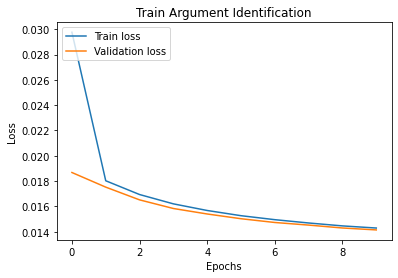

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Identification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelArgIdent.pt"
torch.save(model3, pth_model, pickle_protocol=4)

###Training and test 4

* Batch size used: 32
* Epochs of training: 10 (5 epochs with data not duplicated and 5 epochs with data duplicated)
* Loss function: Mean Squared Error
* Activation function: sigmoid
* 1 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* In the model predicates are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of predicates, '0' otherwise
***OSS.:** this section contains a ***confusion matrix***

**OSS:** duplicated data means that if a sentence contains more than one predicated, it is duplicated as many time as the number of predicates


In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 5
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model4 = ArgumentIdentifier(N_HIDDEN, N_CLASSES, device, BERT)
model4.to(device)
optimizer = torch.optim.Adam(model4.parameters())

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model4.train()
loss_train, loss_val = train(model4, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/5
Training...
Train Loss: 0.03847891789290213
Validating...
Validation Loss: 0.026563218380841944


epoch: 2/5
Training...
Train Loss: 0.016492758529080498
Validating...
Validation Loss: 0.01174300236420499


epoch: 3/5
Training...
Train Loss: 0.011021848040963372
Validating...
Validation Loss: 0.009836965706199408


epoch: 4/5
Training...
Train Loss: 0.00933548930071054
Validating...
Validation Loss: 0.008374742025302516


epoch: 5/5
Training...
Train Loss: 0.008181353844702244
Validating...
Validation Loss: 0.007795685229616033



In [ ]:
#Test the model
model4.eval()
true, predictions = test(model4, dataset_dev)

Correctly classified: 3482
Predicted: 3886
Gold: 4068
# Precision: 0.90
# Recall: 0.86
# F1: 0.88


In [ ]:
#Train the model
model4.train()
loss_train, loss_val = train(model4, optimizer, dataset_train2, dataset_val2, LOSS, EPOCHS, loss_train, loss_val)


epoch: 6/10
Training...
Train Loss: 0.0068672335697443215
Validating...
Validation Loss: 0.00528996093198657


epoch: 7/10
Training...
Train Loss: 0.004682381597273894
Validating...
Validation Loss: 0.004515234805876389


epoch: 8/10
Training...
Train Loss: 0.004147505650420457
Validating...
Validation Loss: 0.004312337265582755


epoch: 9/10
Training...
Train Loss: 0.003683856752895787
Validating...
Validation Loss: 0.004138809500727802


epoch: 10/10
Training...
Train Loss: 0.0034722766706109637
Validating...
Validation Loss: 0.003855303849559277



In [ ]:
#Test the model
model4.eval()
true, predictions = test(model4, dataset_dev2)

Correctly classified: 4166
Predicted: 4632
Gold: 4842
# Precision: 0.90
# Recall: 0.86
# F1: 0.88


In [ ]:
#Train the model
model4.train()
loss_train, loss_val = train(model4, optimizer, dataset_train2, dataset_val2, LOSS, 20, loss_train, loss_val)


epoch: 11/30
Training...
Train Loss: 0.0032107707203134347
Validating...
Validation Loss: 0.004058686952339486


epoch: 12/30
Training...
Train Loss: 0.0030885188354279236
Validating...
Validation Loss: 0.003842223872197792


epoch: 13/30
Training...
Train Loss: 0.002873631262389475
Validating...
Validation Loss: 0.004185413804952987


epoch: 14/30
Training...
Train Loss: 0.002694866221265257
Validating...
Validation Loss: 0.0036344733176520093


epoch: 15/30
Training...
Train Loss: 0.002618047965760869
Validating...
Validation Loss: 0.0038002903282176705


epoch: 16/30
Training...
Train Loss: 0.002521928109585092
Validating...
Validation Loss: 0.004000093269860372


epoch: 17/30
Training...
Train Loss: 0.0023738560027549423
Validating...
Validation Loss: 0.0038955443043960257


epoch: 18/30
Training...
Train Loss: 0.002333836776492486
Validating...
Validation Loss: 0.00387047976400936


epoch: 19/30
Training...
Train Loss: 0.002260496881974619
Validating...
Validation Loss: 0.0036991

In [ ]:
#Test the model
model4.eval()
true, predictions = test(model4, dataset_dev2)

Correctly classified: 4269
Predicted: 4768
Gold: 4842
# Precision: 0.90
# Recall: 0.88
# F1: 0.89


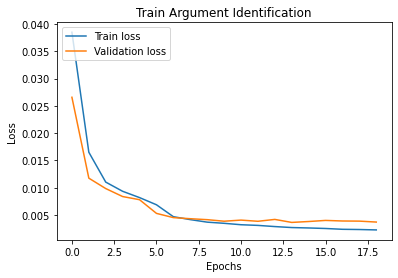

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Identification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelArgIdent.pt"
torch.save(model4, pth_model, pickle_protocol=4)

Confusion Matrix


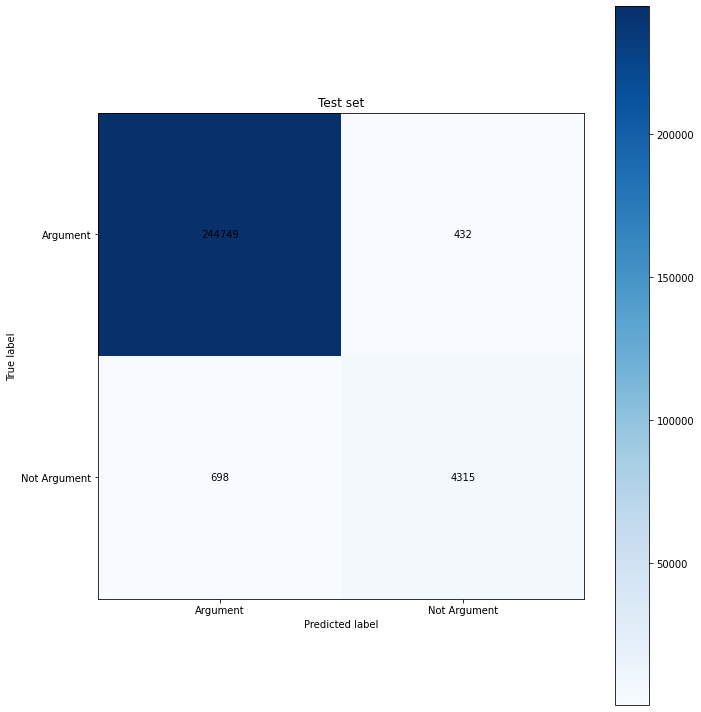

In [ ]:
#confusion matrix
plot_confusion_matrix(np.array(true), np.array(predictions), ['Argument','Not Argument'])

###Training and test 5
(As 'training and test 4' but with Tranformer finetune)

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 5
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model5 = ArgumentIdentifier(N_HIDDEN, N_CLASSES, device, BERT)
model5.to(device)
optimizer = torch.optim.Adam(model5.parameters(), lr=0.0001,weight_decay=0.001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model5.train()
loss_train, loss_val = train(model5, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/5
Training...
Train Loss: 0.03903116200479769
Validating...
Validation Loss: 0.02936191763728857


epoch: 2/5
Training...
Train Loss: 0.02573200966561994
Validating...
Validation Loss: 0.020071636678444013


epoch: 3/5
Training...
Train Loss: 0.01970969987732749
Validating...
Validation Loss: 0.017302548719777003


epoch: 4/5
Training...
Train Loss: 0.016909758001565932
Validating...
Validation Loss: 0.015961296080301206


epoch: 5/5
Training...
Train Loss: 0.015512696413263197
Validating...
Validation Loss: 0.014644773056109747



In [ ]:
#Test the model
model5.eval()
true, predictions = test(model5, dataset_dev)

Correctly classified: 2743
Predicted: 3312
Gold: 4068
# Precision: 0.83
# Recall: 0.67
# F1: 0.74


In [ ]:
#Train the model
model5.train()
loss_train, loss_val = train(model5, optimizer, dataset_train2, dataset_val2, LOSS, EPOCHS, loss_train, loss_val)


epoch: 11/15
Training...
Train Loss: 0.015273922622877325
Validating...
Validation Loss: 0.012194996397010983


epoch: 12/15
Training...
Train Loss: 0.011259805192739445
Validating...
Validation Loss: 0.010678290785290302


epoch: 13/15
Training...
Train Loss: 0.010364094249230658
Validating...
Validation Loss: 0.01140393428504467


epoch: 14/15
Training...
Train Loss: 0.010047401910605656
Validating...
Validation Loss: 0.010258899535983801


epoch: 15/15
Training...
Train Loss: 0.009983020963536648
Validating...
Validation Loss: 0.010201311553828418



In [ ]:
#Test the model
model5.eval()
true, predictions = test(model5, dataset_dev2)

Correctly classified: 1885
Predicted: 2043
Gold: 4842
# Precision: 0.92
# Recall: 0.39
# F1: 0.55


In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Identification")

###Training and test 6

* Batch size used: 32
* Epochs of training: 20 (5 with not duplicated data and 15 with duplicated data)
* Loss function: Mean Squared Error
* Activation function: sigmoid
* 2 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "albert-base-v2" not finetuned
* Adam Optimizer with lr = 0.0001
* In the model predicates are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of predicates, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 5
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model6 = ArgumentIdentifier(N_HIDDEN, N_CLASSES, device, ALBERT)
model6.to(device)
optimizer = torch.optim.Adam(model6.parameters())

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.weight', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model6.train()
loss_train, loss_val = train(model6, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/5
Training...
Train Loss: 0.03828785879717719
Validating...
Validation Loss: 0.03161516526920928


epoch: 2/5
Training...
Train Loss: 0.030136233796515772
Validating...
Validation Loss: 0.025927066078616515


epoch: 3/5
Training...
Train Loss: 0.023853593668149365
Validating...
Validation Loss: 0.021259692704512015


epoch: 4/5
Training...
Train Loss: 0.01960713738996175
Validating...
Validation Loss: 0.017463907237268157


epoch: 5/5
Training...
Train Loss: 0.01691722880688406
Validating...
Validation Loss: 0.016825789585709572



In [ ]:
#Test the model
model6.eval()
true, predictions = test(model6, dataset_dev)

Correctly classified: 2558
Predicted: 3209
Gold: 4068
# Precision: 0.80
# Recall: 0.63
# F1: 0.70


In [ ]:
#Train the model
model6.train()
loss_train, loss_val = train(model6, optimizer, dataset_train2, dataset_val2, LOSS, 15, loss_train, loss_val)


epoch: 6/20
Training...
Train Loss: 0.010718219422887863
Validating...
Validation Loss: 0.009577477024868131


epoch: 7/20
Training...
Train Loss: 0.009099442838022938
Validating...
Validation Loss: 0.008906447305344045


epoch: 8/20
Training...
Train Loss: 0.008413927333618877
Validating...
Validation Loss: 0.008808706072159111


epoch: 9/20
Training...
Train Loss: 0.007982222027918798
Validating...
Validation Loss: 0.00841038660146296


epoch: 10/20
Training...
Train Loss: 0.007509015763630974
Validating...
Validation Loss: 0.00799978586146608


epoch: 11/20
Training...
Train Loss: 0.007125610925683404
Validating...
Validation Loss: 0.007917010120581835


epoch: 12/20
Training...
Train Loss: 0.006911202862669351
Validating...
Validation Loss: 0.007852331909816712


epoch: 13/20
Training...
Train Loss: 0.0065571516798283
Validating...
Validation Loss: 0.007952419167850167


epoch: 14/20
Training...
Train Loss: 0.006328466379262591
Validating...
Validation Loss: 0.0077657406567595896


In [ ]:
#Test the model
model6.eval()
true, predictions = test(model6, dataset_dev2)

Correctly classified: 3233
Predicted: 4018
Gold: 4842
# Precision: 0.80
# Recall: 0.67
# F1: 0.73


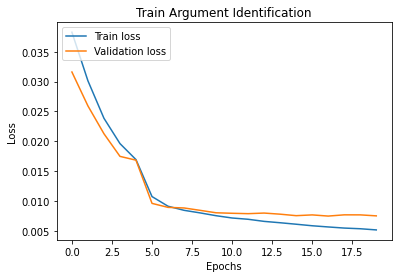

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Identification")

###Test and training 7

* Batch size used: 32
* Epochs of training: 20 (5 with not duplicated data and 15 with duplicated data)
* Loss function: Mean Squared Error
* Activation function: sigmoid
* 2 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "roberta-base" not finetuned
* Adam Optimizer with lr = 0.0001
* In the model predicates are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of predicates, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 5
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model7 = ArgumentIdentifier(N_HIDDEN, N_CLASSES, device, RoBERTa)
model7.to(device)
optimizer = torch.optim.Adam(model7.parameters(), lr=0.0001)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/5
Training...
Train Loss: 0.048235317223495056
Validating...
Validation Loss: 0.02881628078305059


epoch: 2/5
Training...
Train Loss: 0.02896027239339967
Validating...
Validation Loss: 0.02559877797547314


epoch: 3/5
Training...
Train Loss: 0.023104385094296548
Validating...
Validation Loss: 0.017495215301298432


epoch: 4/5
Training...
Train Loss: 0.01608095452670128
Validating...
Validation Loss: 0.013851116825309064


epoch: 5/5
Training...
Train Loss: 0.013536894267364855
Validating...
Validation Loss: 0.012113627718968524



In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev)

Correctly classified: 3186
Predicted: 3774
Gold: 4200
# Precision: 0.84
# Recall: 0.76
# F1: 0.80


In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train2, dataset_val2, LOSS, 15, loss_train, loss_val)


epoch: 11/20
Training...
Train Loss: 0.005974655267177413
Validating...
Validation Loss: 0.005964314757147804


epoch: 12/20
Training...
Train Loss: 0.005844989142349085
Validating...
Validation Loss: 0.005832717439625412


epoch: 13/20
Training...
Train Loss: 0.005681460229995645
Validating...
Validation Loss: 0.005707042064750567


epoch: 14/20
Training...
Train Loss: 0.005497249050492073
Validating...
Validation Loss: 0.0057888917159289125


epoch: 15/20
Training...
Train Loss: 0.00537195266421758
Validating...
Validation Loss: 0.005641548748826608


epoch: 16/20
Training...
Train Loss: 0.005214152737957357
Validating...
Validation Loss: 0.005560132506070658


epoch: 17/20
Training...
Train Loss: 0.005210334065470234
Validating...
Validation Loss: 0.005426057957811281


epoch: 18/20
Training...
Train Loss: 0.005039156254744
Validating...
Validation Loss: 0.005449302465422079


epoch: 19/20
Training...
Train Loss: 0.004982176628805655
Validating...
Validation Loss: 0.005485928326379

In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev2)

Correctly classified: 3953
Predicted: 4500
Gold: 5013
# Precision: 0.88
# Recall: 0.79
# F1: 0.83


In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model7 = ArgumentIdentifier(N_HIDDEN, N_CLASSES, device, BERT)
model7.to(device)
optimizer = torch.optim.Adam(model7.parameters(), lr=0.0001, weight_decay=0.001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Transfer learning for Spanish

In [ ]:
#Duplicate data for each predciate in evry sentence
new_words, new_pred, new_roles = duplicate_data(wordsES, predES, rolES)
new_words_dev, new_pred_dev, new_roles_dev = duplicate_data(words_devES, pred_devES, rol_devES)

In [ ]:
#process data
data, labels = encode_data(new_words, new_roles, new_pred, BERT)
data_dev, labels_dev = encode_data(new_words_dev, new_roles_dev, new_pred_dev, BERT)

In [ ]:
#define datasets with its batch size

BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 20
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
modelArgIdent = torch.load("/content/drive/MyDrive/modelArgIdent.pt")
modelArgIdent.to(device)
optimizer = torch.optim.Adam(modelArgIdent.parameters())

In [ ]:
#Train the model
modelArgIdent.train()
loss_train, loss_val = train(modelArgIdent, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/20
Training...
Train Loss: 0.012861482769010528
Validating...
Validation Loss: 0.011185623705387115


epoch: 2/20
Training...
Train Loss: 0.010712122124048972
Validating...
Validation Loss: 0.009291759692132473


epoch: 3/20
Training...
Train Loss: 0.009702816215013304
Validating...
Validation Loss: 0.009019391611218452


epoch: 4/20
Training...
Train Loss: 0.00899772590867454
Validating...
Validation Loss: 0.008922818582504988


epoch: 5/20
Training...
Train Loss: 0.008607402819419099
Validating...
Validation Loss: 0.00867756234947592


epoch: 6/20
Training...
Train Loss: 0.008101075662360076
Validating...
Validation Loss: 0.008680167607963085


epoch: 7/20
Training...
Train Loss: 0.007857641535660913
Validating...
Validation Loss: 0.0084964947309345


epoch: 8/20
Training...
Train Loss: 0.007638816962078694
Validating...
Validation Loss: 0.008284746669232845


epoch: 9/20
Training...
Train Loss: 0.007379796010472121
Validating...
Validation Loss: 0.008684905478730798


epoc

In [ ]:
#Test the model
modelArgIdent.eval()
true, predictions = test(modelArgIdent, dataset_dev)

Correctly classified: 2817
Predicted: 3551
Gold: 4716
# Precision: 0.79
# Recall: 0.60
# F1: 0.68


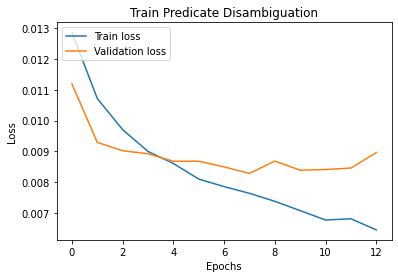

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelArgIdentES.pt"
torch.save(modelArgIdent, pth_model, pickle_protocol=4)

##Transfer learning for French

In [ ]:
#Duplicate data for each predciate in evry sentence
new_words, new_pred, new_roles = duplicate_data(wordsFR, predFR, rolFR)
new_words_dev, new_pred_dev, new_roles_dev = duplicate_data(words_devFR, pred_devFR, rol_devFR)

In [ ]:
#process data
data, labels = encode_data(new_words, new_roles, new_pred, BERT)
data_dev, labels_dev = encode_data(new_words_dev, new_roles_dev, new_pred_dev, BERT)

In [ ]:
#define datasets with its batch size

BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = 1
EPOCHS = 20
LOSS = nn.MSELoss()

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
modelArgIdent = torch.load("/content/drive/MyDrive/modelArgIdent.pt")
modelArgIdent.to(device)
optimizer = torch.optim.Adam(modelArgIdent.parameters())

In [ ]:
#Train the model
modelArgIdent.train()
loss_train, loss_val = train(modelArgIdent, optimizer, dataset_train, dataset_val, LOSS, EPOCHS)


epoch: 1/20
Training...
Train Loss: 0.010948628623737022
Validating...
Validation Loss: 0.00993939652107656


epoch: 2/20
Training...
Train Loss: 0.008973024217993952
Validating...
Validation Loss: 0.008711010217666626


epoch: 3/20
Training...
Train Loss: 0.008034675047383644
Validating...
Validation Loss: 0.008323376532644033


epoch: 4/20
Training...
Train Loss: 0.007695102569414303
Validating...
Validation Loss: 0.008472678135149181


epoch: 5/20
Training...
Train Loss: 0.007131581733119674
Validating...
Validation Loss: 0.0074672059854492545


epoch: 6/20
Training...
Train Loss: 0.006911459189723246
Validating...
Validation Loss: 0.008159241173416376


epoch: 7/20
Training...
Train Loss: 0.006699938690871932
Validating...
Validation Loss: 0.007711222278885543


epoch: 8/20
Training...
Train Loss: 0.006239545225980692
Validating...
Validation Loss: 0.007967678597196937


epoch: 9/20
Training...
Train Loss: 0.005958379595540464
Validating...
Validation Loss: 0.00786197790876031


e

In [ ]:
#Test the model
modelArgIdent.eval()
true, predictions = test(modelArgIdent, dataset_dev)

Correctly classified: 2825
Predicted: 3451
Gold: 4855
# Precision: 0.82
# Recall: 0.58
# F1: 0.68


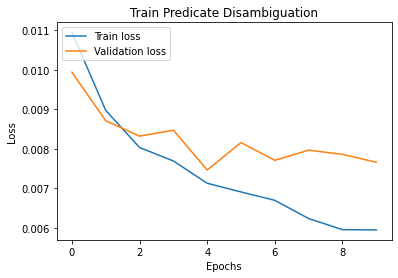

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Predicate Disambiguation")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelArgIdentFR.pt"
torch.save(modelArgIdent, pth_model, pickle_protocol=4)

#**Argument Classification**

##Process data and prepare dataset

In [ ]:
#process data

'''
- args:
  - sentences: list of strings ("lemmas" or "words")
  - roles: list of strings (roles)
  - predicates: list of string (predicates)

-output:
  -sentences_with_mask: list of dictionaries (each element has keys "input_ids" and "attention_mask")
  -labels: list tensor of tensors with all labels
'''

def encode_data(sentences: list, roles: list, predicates: list, language_model: str):

  #use the transformer tokanizer
  tokenizer = AutoTokenizer.from_pretrained(language_model)

  sent = sentences.copy()
  rol = roles.copy()
  pred = predicates.copy()

  #find max lenght between all data in dataset to add padding later
  max_len = 0
  for s in sent:
      max_len = max(max_len, len(s))

  #convert tokens into ids with the tokanizer
  tokens_list = []
  for s in sent:
    si = s.copy()
    tokens = []
    for i in si:
      tokens.append(tokenizer(i)[0].ids[1])
    #add padding
    while len(tokens)<max_len:
      tokens.append(0)

    tokens_list.append(tokens)

  #create a mask to divide useful tokens from padding
  masks = []
  for ti in tokens_list:
    mask = []
    for tj in ti:
      if tj!=0:
        mask.append(1)
      else:
        mask.append(0)
        
    masks.append(mask)

  assert len(tokens_list)==len(masks)

  #create a list of predicates with "0" if there are not predicate, "1" otherwise
  new_pred = []
  for p in pred:
    l = []
    for pi in p:
      if pi=="_":
        l.append(0)
      else:
        l.append(1)
    while len(l)<max_len:
      l.append(0)
    new_pred.append(l)
  
  #store ids and mask into a dictionary
  sentences_with_masks = []
  for t,m,p in zip(tokens_list,masks,new_pred):
    ti = torch.tensor(t)
    mi = torch.tensor(m)
    pi = torch.tensor(p)
    sentences_with_masks.append({"input_ids":ti,"attention_mask":mi,"predicates":pi})

  #process labels indicating with "1" a predicate and with "0" other words
  labels = []

  for role in rol:
    r = role.copy()
    r = list(r.values())[0]

    label = []
    for ri in r:
      if ri =="_" or ri not in dict_argument_classes.keys():
        label.append(dict_argument_classes['_'])
      else:
        label.append(dict_argument_classes[ri])
    #add padding
    while len(label)<max_len:
      label.append(dict_argument_classes['PAD'])
          
    labels.append(label)

  labels = torch.tensor(labels)

  return sentences_with_masks, labels

In [ ]:
#process data

'''
- args:
  - sentences: list of strings ("lemmas" or "words")
  - roles: list of strings (roles)
  - predicates: list of string (predicates)

-output:
  -sentences_with_mask: list of dictionaries (each element has keys "input_ids" and "attention_mask")
  -labels: list tensor of tensors with all labels

OSS.: In this function 'encode2' with resect to prevoius 'encode', data are ecnoded with following pattern:
      '[CLS] tokens_sentence [PAD] token_predicate'
'''

def encode_data2(sentences: list, roles: list, predicates: list, language_model: str):

  #use the transformer tokanizer
  tokenizer = AutoTokenizer.from_pretrained(language_model)

  sent = sentences.copy()
  rol = roles.copy()
  pred = predicates.copy()

  #find max lenght between all data in dataset to add padding later
  max_len = 0
  for s in sent:
      max_len = max(max_len, len(s))
  max_len = max_len+3 #add CLS,SEP,prediacte

  #[CLS] sentence [SEP] predicate
  new_sent = []
  for s,p in zip(sent,pred):
    s = s.copy()
    p = p.copy()
    new_s = []
    new_s.insert(0, "[CLS]")
    for si,pi in zip(s,p):
      if pi!="_":
        target_predicate = si
      new_s.append(si)
    new_s.append("[SEP]")
    new_s.append(target_predicate)
    new_sent.append(new_s)

  #convert tokens into ids with the tokanizer
  tokens_list = []
  for s in new_sent:
    si = s.copy()
    tokens = []
    for i in si:
      tokens.append(tokenizer(i)[0].ids[1])
    #add padding
    while len(tokens)<max_len:
      tokens.append(0)

    tokens_list.append(tokens)

  #create a mask to divide useful tokens from padding
  masks = []
  for ti in tokens_list:
    mask = []
    for tj in ti:
      if tj!=0:
        mask.append(1)
      else:
        mask.append(0)
        
    masks.append(mask)

  assert len(tokens_list)==len(masks)

  new_pred = []
  for p in pred:
    l = []
    l.append(0)#CLS
    for pi in p:
      if pi=="_":
        l.append(0)
      else:
        l.append(1)
    l.append(0)#SEP
    l.append(0)#predicate
    while len(l)<max_len:
      l.append(0)
    new_pred.append(l)
  
  #store ids and mask into a dictionary
  sentences_with_masks = []
  for t,m,p in zip(tokens_list,masks,new_pred):
    ti = torch.tensor(t)
    mi = torch.tensor(m)
    pi = torch.tensor(p)
    sentences_with_masks.append({"input_ids":ti,"attention_mask":mi,"predicates":pi})

  #process labels indicating with "1" a predicate and with "0" other words
  labels = []

  for role in rol:
    r = role.copy()
    r = list(r.values())[0]

    label = []
    label.append(dict_argument_classes['_'])#CLS
    for ri in r:
      if ri =="_" or ri not in dict_argument_classes.keys():
        label.append(dict_argument_classes['_'])
      else:
        label.append(dict_argument_classes[ri])
    label.append(dict_argument_classes['_'])#SEP
    label.append(dict_argument_classes['_'])#predicate
    #add padding
    while len(label)<max_len:
      label.append(dict_argument_classes['PAD'])
          
    labels.append(label)

  labels = torch.tensor(labels)

  return sentences_with_masks, labels

In [ ]:
#Duplicate data for each predciate in every sentence
new_words, new_pred, new_roles = duplicate_data(words, pred, rol)
new_words_dev, new_pred_dev, new_roles_dev = duplicate_data(words_dev, pred_dev, rol_dev)

In [ ]:
#process data
data, labels = encode_data(new_words, new_roles, new_pred, BERT)
data_dev, labels_dev = encode_data(new_words_dev, new_roles_dev, new_pred_dev, BERT)

In [ ]:
#organize dataset with batches

BATCH = 32
#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

In [ ]:
#process data with pattern '[CLS] tokens_sentence [PAD] token_predicate'
data2, labels2 = encode_data2(new_words, new_roles, new_pred, BERT)
data_dev2, labels_dev2 = encode_data2(new_words_dev, new_roles_dev, new_pred_dev, BERT)

In [ ]:
#organize dataset with batches with data with pattern '[CLS] tokens_sentence [PAD] token_predicate'

BATCH = 32
#split training set into train and validation to train and to evaluate the model
x_train2, x_val2, y_train2, y_val2 = train_test_split(data2, labels2, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train2 = create_dataset(x_train2, y_train2, BATCH)
dataset_val2 = create_dataset(x_val2, y_val2, BATCH)
dataset_dev2 = create_dataset(data_dev2, labels_dev2, BATCH)

##Train and test functions

In [ ]:
#train function

'''
- args:
  - model: an instance eof the model
  - optimizer: an instance of the optimizer
  - data_train: dataset for train 
  - data_val: dataset for validation
  - loss_f: loss function
  - epochs: (int) numer of epochs (default is 10)
  - train_loss: list of train losses if the training continue from previous one, None otherwise
  - val_loss: list of validation losses if the training continue from previous one, None otherwise

-output:
  - tot_loss_train: list of train losses
  - tot_loss_val: list of validation losses
'''

def train(model, optimizer, data_train, data_val, n_classes, loss_f, epochs: int = 10, train_loss = None, val_loss = None):

    #To store losses if call the train to continue a previous training or start new one
    if train_loss == None and val_loss == None: 
      tot_loss_train = []
      tot_loss_val = []
      epochs_done = 0
    else:
      tot_loss_train = train_loss
      tot_loss_val = val_loss
      assert len(tot_loss_train) == len(tot_loss_val)
      epochs_done = len(tot_loss_train)

    #Variables for early stopping
    best_validation_loss = float('inf')
    counter = 0
    patience = 5
    
    #main loop
    for epoch in range(epochs):

        print("\nepoch: "+str(epoch+1+epochs_done)+"/"+str(epochs+epochs_done))

        #training loop
        print("Training...")
        loss_train = []

        #process data
        for x, y in data_train:
            optimizer.zero_grad()
            x.update({"roles":y})
            input = {k: v.to(device) for k, v in x.items()}
            out = model(**input)
            out = out.to(device)
            y = y.to(device)
            loss = loss = loss_f(out.view(-1, n_classes),y.view(-1), ignore_index=-100)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

        #loss of the batch
        lt = sum(loss_train)/len(loss_train)

        tot_loss_train.append(lt)
        print("Train Loss: "+str(lt))

        #validation loop
        print("Validating...")
        loss_val = []

        #process data
        for x, y in data_val:

          with torch.no_grad():
            x.update({"roles":y})
            input = {k: v.to(device) for k, v in x.items()}
            out = model(**input)
            out = out.to(device)
            y = y.to(device)
            loss = loss = loss_f(out.view(-1, n_classes),y.view(-1), ignore_index=-100)
            loss_val.append(loss.item())

        #loss of the batch
        lv = sum(loss_val)/len(loss_val)

        tot_loss_val.append(lv)
        print("Validation Loss: "+str(lv)+"\n")

        #Early Stopping
        if lv < best_validation_loss:
          best_validation_loss = lv
          counter = 0
        else:
          counter = counter+1
        if counter >= patience:
          break

    return tot_loss_train, tot_loss_val

In [ ]:
def test(model: nn.Module, dataloader: DataLoader):

  num_correctly = 0   #number of correctly predicted (true positives)
  false_positives=0   #number of false positives predicted
  false_negatives=0   #number of false negatives predicted
  pred = []           #list of predictions
  true = []           #list of true labels

  for x, y in dataloader:

      #predict data
      with torch.no_grad():
          x.update({"roles":y})
          input = {k: v.to(device) for k, v in x.items()}
          out = model(**input)
          out = F.log_softmax(out,-1)
          out = torch.argmax(out, -1)

      #check the predictions with true labels to compute F1 metric
      for elem_pred,elem_true in zip(out, y):

          for e_pred,e_true in zip(elem_pred,elem_true):

              e_pred = e_pred.item()
              e_true = e_true.item()
                  
              if e_pred != 0 and e_true!=0 and e_true!=-100:
                if e_pred == e_true: 
                  num_correctly += 1
                else:
                  false_positives +=1
                  false_negatives +=1
              elif e_pred!=0 and e_true==0:
                  false_positives+=1
              elif e_pred==0 and e_true!=0 and e_true!=-100:
                  false_negatives+=1
              true.append(e_true)
              pred.append(e_pred)

  print("Correctly classified: "+str(num_correctly))
  print("False Positives: "+str(false_positives))
  print("False Negatives: "+str(false_negatives))

  precision = num_correctly/(num_correctly+false_positives)
  recall = num_correctly/(num_correctly+false_negatives)
  F1 = 2*(precision*recall)/(precision+recall)

  print(f'# Precision: {precision:.2f}')
  print(f'# Recall: {recall:.2f}')
  print(f'# F1: {F1:.2f}')
  
  return true, pred

##Model

In [ ]:
class ArgumentClassification(torch.nn.Module):

    def __init__(self, n_hidden, classes, device, language_model_name="bert-base-cased"):
        super(ArgumentClassification, self).__init__()

        #Transformer model
        self.transformer_model = AutoModel.from_pretrained(language_model_name, output_hidden_states=True)

        #Freeze Transformer
        for param in self.transformer_model.parameters():
          param.requires_grad = False

        #Number of features in output from the transformer
        self.embedding_dim = self.transformer_model.config.hidden_size

        #Additive feature to represent where is a predicate
        self.add_features = 2
        
        #BiLSTM layer
        self.lstm = nn.LSTM(self.embedding_dim+self.add_features, n_hidden, bidirectional = True, num_layers = 2, dropout=0.3, batch_first = True)


        #Linear classifier
        self.hidden1 = torch.nn.Linear(2*n_hidden, classes)
        #self.hidden2 = torch.nn.Linear(n_hidden, classes)

    def forward(self, 
                input_ids: torch.Tensor = None,
                attention_mask: torch.Tensor = None,
                roles: torch.Tensor = None,
                predicates: torch.Tensor = None):
      
        dict_input = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }

        out = self.transformer_model(**dict_input)
        out = torch.stack(out.hidden_states[-4:], dim=0).mean(dim=0)

        '''
        Associate a tensor of shape (2):
        -First element: '1' in correspondence with the arguments and '0' otherwise
        -Second element: mean(features(token[i])) - mean(features(predicate)) for all i
        '''
        o = []

        for oi,rol,pred in zip(out, roles, predicates):
          index_pred = torch.argmax(pred).item()
          mean_token_pred = torch.mean(oi[index_pred,:])
          new_tensor = []
          for oii,r in zip(oi,rol):
            mean_token_word = torch.mean(oii)
            new_mean = (mean_token_word-mean_token_pred).item()
            r = r.item()
            if r!=0 and r!=-100:
              new_tensor.append(torch.tensor((new_mean,1), dtype=torch.float32))
            else:
              new_tensor.append(torch.tensor((new_mean,0), dtype=torch.float32))
          new_tensor = torch.stack(new_tensor).to(device)
          o.append(torch.cat((oi,new_tensor),dim=1))
        
        out = torch.stack(o).to(device)
        
        out, _ = self.lstm(out)
        out = self.hidden1(out)
        #out = torch.relu(out)
        #out = nn.Dropout(0.3)(out)
        #out = self.hidden2(out)

        return out

###Training and test 1

* Batch size used: 32
* Epochs of training: 10
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* In the model predicates are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of predicates, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ArgumentClassification(N_HIDDEN, N_CLASSES, device, BERT)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model.train()
loss_train, loss_val = train(model, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.22351591472150917
Validating...
Validation Loss: 0.1252994043752551


epoch: 2/10
Training...
Train Loss: 0.11144627325531453
Validating...
Validation Loss: 0.10132295712828636


epoch: 3/10
Training...
Train Loss: 0.09224718869111295
Validating...
Validation Loss: 0.08948950804769992


epoch: 4/10
Training...
Train Loss: 0.07987126883771797
Validating...
Validation Loss: 0.08400658955797553


epoch: 5/10
Training...
Train Loss: 0.07069834211241391
Validating...
Validation Loss: 0.07919528167694807


epoch: 6/10
Training...
Train Loss: 0.06369007167295884
Validating...
Validation Loss: 0.07877467358484865


epoch: 7/10
Training...
Train Loss: 0.056784443115278825
Validating...
Validation Loss: 0.07755127670243382


epoch: 8/10
Training...
Train Loss: 0.05118826658880643
Validating...
Validation Loss: 0.07649722220376134


epoch: 9/10
Training...
Train Loss: 0.046276221704264146
Validating...
Validation Loss: 0.07479588221758604


epoch: 10/10
Trai

In [ ]:
#Test the model
model.eval()
true, predictions = test(model, dataset_dev)

Correctly classified: 3645
False Positives: 1100
False Negatives: 1368
# Precision: 0.77
# Recall: 0.73
# F1: 0.75


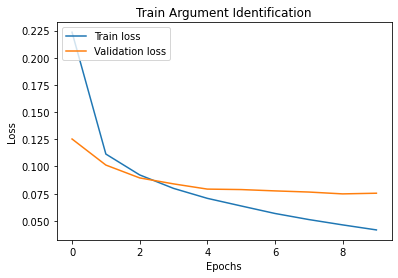

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

###Training and test 2

* Batch size used: 32
* Epochs of training: 10 and 20
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" finetuned
* Adam Optimizer with lr=0.0001 and weight_decay=0.001
* In the model arguments are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of arguments, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_FEATURES = 768
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = ArgumentClassification(N_HIDDEN, N_CLASSES, device, BERT)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001, weight_decay=0.001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.27947247075706216
Validating...
Validation Loss: 0.11605831347405911


epoch: 2/10
Training...
Train Loss: 0.10556388692667255
Validating...
Validation Loss: 0.09375942153856158


epoch: 3/10
Training...
Train Loss: 0.09153406672432261
Validating...
Validation Loss: 0.08510346515104175


epoch: 4/10
Training...
Train Loss: 0.08285757145807568
Validating...
Validation Loss: 0.07671341309323906


epoch: 5/10
Training...
Train Loss: 0.07371431205021796
Validating...
Validation Loss: 0.07022239277139306


epoch: 6/10
Training...
Train Loss: 0.06590452569268518
Validating...
Validation Loss: 0.06396318431943655


epoch: 7/10
Training...
Train Loss: 0.06019574714203676
Validating...
Validation Loss: 0.06611769432201982


epoch: 8/10
Training...
Train Loss: 0.05770180799530051
Validating...
Validation Loss: 0.06186437224969268


epoch: 9/10
Training...
Train Loss: 0.0535758553220138
Validating...
Validation Loss: 0.05886894958093762


epoch: 10/10
Traini

In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev)

Correctly classified: 3571
False Positives: 1437
False Negatives: 1442
# Precision: 0.71
# Recall: 0.71
# F1: 0.71


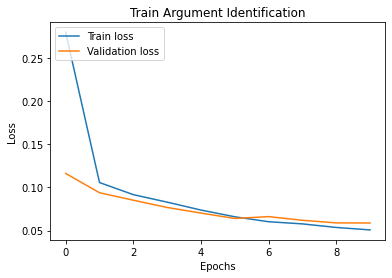

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelArgClass.pt"
torch.save(model3, pth_model, pickle_protocol=4)

Add 10 epochs

In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, EPOCHS, loss_train, loss_val)


epoch: 11/20
Training...
Train Loss: 0.0482852135043023
Validating...
Validation Loss: 0.061654725670814516


epoch: 12/20
Training...
Train Loss: 0.04684871060005521
Validating...
Validation Loss: 0.05951060559600592


epoch: 13/20
Training...
Train Loss: 0.045879956661055314
Validating...
Validation Loss: 0.05969866262748837


epoch: 14/20
Training...
Train Loss: 0.044653456863331595
Validating...
Validation Loss: 0.05684649818576872


epoch: 15/20
Training...
Train Loss: 0.043289813113077884
Validating...
Validation Loss: 0.05826272871345282


epoch: 16/20
Training...
Train Loss: 0.04290392111965829
Validating...
Validation Loss: 0.06017664587125182


epoch: 17/20
Training...
Train Loss: 0.04137519523922333
Validating...
Validation Loss: 0.059944492671638726


epoch: 18/20
Training...
Train Loss: 0.040979298952398664
Validating...
Validation Loss: 0.058615795243531464


epoch: 19/20
Training...
Train Loss: 0.039433567916269355
Validating...
Validation Loss: 0.058813161915168166


e

In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev)

Correctly classified: 3649
False Positives: 1360
False Negatives: 1364
# Precision: 0.73
# Recall: 0.73
# F1: 0.73


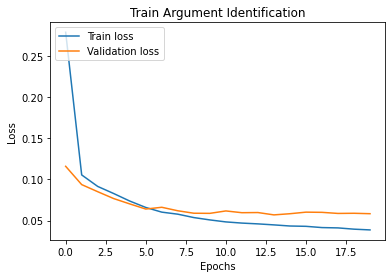

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Identification")

###Training and test 3

* Batch size used: 32
* Epochs of training: 100 (stopped at 43)
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer with lr = 0.0001 and weight_decay=0.001
* In the model arguments are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of arguments, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model3 = ArgumentClassification(N_HIDDEN, N_CLASSES, device, BERT)
model3.to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0001, weight_decay=0.001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model3.train()
loss_train, loss_val = train(model3, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, 100)


epoch: 1/100
Training...
Train Loss: 0.38079304319653806
Validating...
Validation Loss: 0.12247757501900196


epoch: 2/100
Training...
Train Loss: 0.1117798758428649
Validating...
Validation Loss: 0.10196055565029383


epoch: 3/100
Training...
Train Loss: 0.09846874225442692
Validating...
Validation Loss: 0.09526734948158264


epoch: 4/100
Training...
Train Loss: 0.0920613259603243
Validating...
Validation Loss: 0.08706127107143402


epoch: 5/100
Training...
Train Loss: 0.08623935782092776
Validating...
Validation Loss: 0.08091290621086955


epoch: 6/100
Training...
Train Loss: 0.08092636681335458
Validating...
Validation Loss: 0.07646499471738935


epoch: 7/100
Training...
Train Loss: 0.07693114883061182
Validating...
Validation Loss: 0.07330552646890283


epoch: 8/100
Training...
Train Loss: 0.07355647923498504
Validating...
Validation Loss: 0.07120048515498638


epoch: 9/100
Training...
Train Loss: 0.07080371319026933
Validating...
Validation Loss: 0.06876591611653567


epoch: 10/1

In [ ]:
#Test the model
model3.eval()
true, predictions = test(model3, dataset_dev)

Correctly classified: 3646
False Positives: 1367
False Negatives: 1367
# Precision: 0.73
# Recall: 0.73
# F1: 0.73


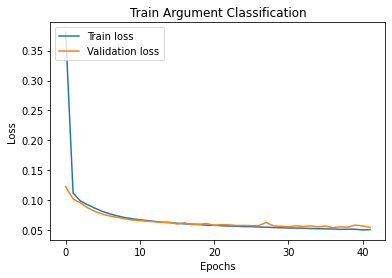

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

###Training and test 4

* Batch size used: 32
* Epochs of training: 100 (stopped at 17)
* Loss function: cross_entropy
* Activation function: softmax
* 2 linear layer and 1 Dropout(0.3) of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" finetuned
* Adam Optimizer
* In the model arguments are tagged: concatenate 1 feature with all '1' in corrispondence of tokens of arguments, '0' otherwise

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model4 = ArgumentClassification(N_HIDDEN, N_CLASSES, device, BERT)
model4.to(device)
optimizer = torch.optim.Adam(model4.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model4.train()
loss_train, loss_val = train(model4, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, 100)


epoch: 1/100
Training...
Train Loss: 0.3167351946487265
Validating...
Validation Loss: 0.09517946988344192


epoch: 2/100
Training...
Train Loss: 0.09426203158573579
Validating...
Validation Loss: 0.09080985337495803


epoch: 3/100
Training...
Train Loss: 0.0914875365014972
Validating...
Validation Loss: 0.08909628912806511


epoch: 4/100
Training...
Train Loss: 0.09029299644805953
Validating...
Validation Loss: 0.0872910076752305


epoch: 5/100
Training...
Train Loss: 0.08931436191844401
Validating...
Validation Loss: 0.08739324696362019


epoch: 6/100
Training...
Train Loss: 0.08864017437070103
Validating...
Validation Loss: 0.08559509823098779


epoch: 7/100
Training...
Train Loss: 0.08808342573669671
Validating...
Validation Loss: 0.08644162397831678


epoch: 8/100
Training...
Train Loss: 0.08792861066969102
Validating...
Validation Loss: 0.08625203818082809


epoch: 9/100
Training...
Train Loss: 0.08765144840851005
Validating...
Validation Loss: 0.085957748349756


epoch: 10/100


In [ ]:
#Test the model
model4.eval()
true, predictions = test(model4, dataset_dev)

Correctly classified: 2689
False Positives: 2324
False Negatives: 2324
# Precision: 0.54
# Recall: 0.54
# F1: 0.54


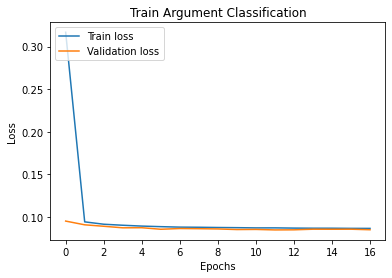

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

###Training and test 5

* Batch size used: 32
* Epochs of training: 10 and 18
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* In the model arguments are tagged: concatenate 2 features: one with '1' in corrispondence of tokens of arguments, '0' otherwise; the other with the difference between the mean of the features of a word and the mean of the features of the predicate

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model5 = ArgumentClassification(N_HIDDEN, N_CLASSES, device, BERT)
model5.to(device)
optimizer = torch.optim.Adam(model5.parameters())

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model5.train()
loss_train, loss_val = train(model5, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.20985796759273373
Validating...
Validation Loss: 0.07881780108436942


epoch: 2/10
Training...
Train Loss: 0.06883373556627055
Validating...
Validation Loss: 0.05968233216553927


epoch: 3/10
Training...
Train Loss: 0.05723362515475285
Validating...
Validation Loss: 0.05292089697904885


epoch: 4/10
Training...
Train Loss: 0.04909593409379828
Validating...
Validation Loss: 0.04721014820970595


epoch: 5/10
Training...
Train Loss: 0.04207831432800845
Validating...
Validation Loss: 0.045894930977374314


epoch: 6/10
Training...
Train Loss: 0.0367600685827392
Validating...
Validation Loss: 0.0431588402017951


epoch: 7/10
Training...
Train Loss: 0.032420586150055386
Validating...
Validation Loss: 0.04185765092261136


epoch: 8/10
Training...
Train Loss: 0.02867480302966163
Validating...
Validation Loss: 0.04107333375141024


epoch: 9/10
Training...
Train Loss: 0.02501117842703384
Validating...
Validation Loss: 0.041571747767739


epoch: 10/10
Trainin

In [ ]:
#Test the model
model5.eval()
true, predictions = test(model5, dataset_dev)

Correctly classified: 4074
False Positives: 939
False Negatives: 939
# Precision: 0.81
# Recall: 0.81
# F1: 0.81


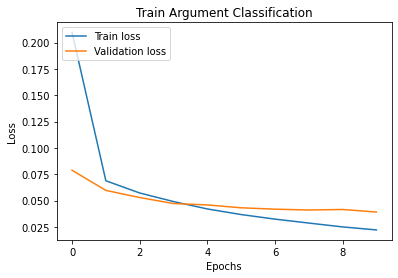

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

Add 10 epochs (stopped after 8)

In [ ]:
#Train the model
model2.train()
loss_train, loss_val = train(model5, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, EPOCHS, loss_train, loss_val)


epoch: 11/20
Training...
Train Loss: 0.019658315133587536
Validating...
Validation Loss: 0.04184476612135768


epoch: 12/20
Training...
Train Loss: 0.017613393519636728
Validating...
Validation Loss: 0.041648572171106936


epoch: 13/20
Training...
Train Loss: 0.015462264736935412
Validating...
Validation Loss: 0.041607311740517613


epoch: 14/20
Training...
Train Loss: 0.014204973431230433
Validating...
Validation Loss: 0.04184082834981382


epoch: 15/20
Training...
Train Loss: 0.012904893480948998
Validating...
Validation Loss: 0.04344532343093306


epoch: 16/20
Training...
Train Loss: 0.01160753874494931
Validating...
Validation Loss: 0.043153900746256114


epoch: 17/20
Training...
Train Loss: 0.011478494053659171
Validating...
Validation Loss: 0.044072933169081806


epoch: 18/20
Training...
Train Loss: 0.010554188048193431
Validating...
Validation Loss: 0.045046095503494143



In [ ]:
#Test the model
model5.eval()
true, predictions = test(model5, dataset_dev)

Correctly classified: 4216
False Positives: 797
False Negatives: 797
# Precision: 0.84
# Recall: 0.84
# F1: 0.84


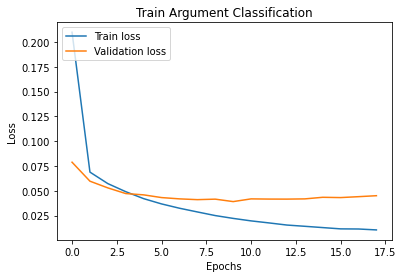

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelArgClass.pt"
torch.save(model5, pth_model, pickle_protocol=4)

###Training and test 6

* Batch size used: 32
* Epochs of training: 100 (stopped at 25)
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" finetuned
* Adam Optimizer with lr=0.0001 and weight_decay=0.001
* In the model arguments are tagged: concatenate 2 features: one with '1' in corrispondence of tokens of arguments, '0' otherwise; the other with the difference between the mean of the features of a word and the mean of the features of the predicate

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model6 = ArgumentClassification(N_HIDDEN, N_CLASSES, device, BERT)
model6.to(device)
optimizer = torch.optim.Adam(model6.parameters(), lr=0.0001, weight_decay=0.001)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model6.train()
loss_train, loss_val = train(model6, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, 100)


epoch: 1/100
Training...
Train Loss: 0.3761195342166949
Validating...
Validation Loss: 0.2359163098037243


epoch: 2/100
Training...
Train Loss: 0.21437292478683978
Validating...
Validation Loss: 0.18889091424643994


epoch: 3/100
Training...
Train Loss: 0.1500976324333983
Validating...
Validation Loss: 0.11380387786775828


epoch: 4/100
Training...
Train Loss: 0.10384619036047472
Validating...
Validation Loss: 0.0945205083116889


epoch: 5/100
Training...
Train Loss: 0.09110671186051462
Validating...
Validation Loss: 0.08565366007387638


epoch: 6/100
Training...
Train Loss: 0.08228605571018774
Validating...
Validation Loss: 0.07636218834668398


epoch: 7/100
Training...
Train Loss: 0.07328119995019867
Validating...
Validation Loss: 0.07457714267075062


epoch: 8/100
Training...
Train Loss: 0.06684143274054352
Validating...
Validation Loss: 0.06817494705319405


epoch: 9/100
Training...
Train Loss: 0.0616772770986887
Validating...
Validation Loss: 0.06461718557402492


epoch: 10/100


In [ ]:
#Test the model
model6.eval()
true, predictions = test(model6, dataset_dev)

Correctly classified: 3600
False Positives: 1377
False Negatives: 1413
# Precision: 0.72
# Recall: 0.72
# F1: 0.72


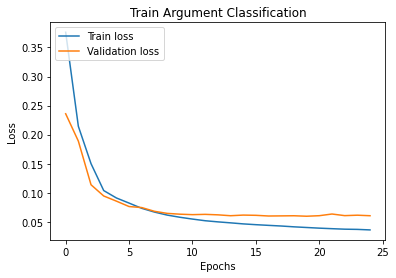

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

###Training and test 7

* Batch size used: 32
* Epochs of training: 100 (stopped at 15)
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* In the model arguments are tagged: concatenate 2 features: one with '1' in corrispondence of tokens of arguments, '0' otherwise; the other with the difference between the mean of the features of a word and the mean of the features of the predicate
* The model is trained in two steps: first with the follow pattern of data: "[CLS]" tokens sentence [SEP] predicate", then with [list of sentence's tokens]
***OSS.:** this section contains a ***confusion matrix***

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model7 = ArgumentClassification(N_HIDDEN, N_CLASSES, device, BERT)
model7.to(device)
optimizer = torch.optim.Adam(model7.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train2, dataset_val2, N_CLASSES, LOSS, 15)


epoch: 1/15
Training...
Train Loss: 0.18926194200744736
Validating...
Validation Loss: 0.06772827235981822


epoch: 2/15
Training...
Train Loss: 0.05915757645931789
Validating...
Validation Loss: 0.05173844201490283


epoch: 3/15
Training...
Train Loss: 0.04711207170776055
Validating...
Validation Loss: 0.04403910581022501


epoch: 4/15
Training...
Train Loss: 0.03844480581139609
Validating...
Validation Loss: 0.04105086475610733


epoch: 5/15
Training...
Train Loss: 0.031795098851461194
Validating...
Validation Loss: 0.03735520630143583


epoch: 6/15
Training...
Train Loss: 0.026356917100900646
Validating...
Validation Loss: 0.035193814896047115


epoch: 7/15
Training...
Train Loss: 0.020985937393191507
Validating...
Validation Loss: 0.03340046228840947


epoch: 8/15
Training...
Train Loss: 0.017187411660107517
Validating...
Validation Loss: 0.03168393271043897


epoch: 9/15
Training...
Train Loss: 0.013854920801622424
Validating...
Validation Loss: 0.032719043712131676


epoch: 10/1

In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev2)

Correctly classified: 4306
False Positives: 706
False Negatives: 707
# Precision: 0.86
# Recall: 0.86
# F1: 0.86


In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, 5, loss_train, loss_val)


epoch: 19/23
Training...
Train Loss: 0.011233651895131284
Validating...
Validation Loss: 0.04521872382611036


epoch: 20/23
Training...
Train Loss: 0.010257068939906898
Validating...
Validation Loss: 0.04140999843366444


epoch: 21/23
Training...
Train Loss: 0.009215795276831246
Validating...
Validation Loss: 0.04481816780753434


epoch: 22/23
Training...
Train Loss: 0.008460442257366316
Validating...
Validation Loss: 0.042899409198435025


epoch: 23/23
Training...
Train Loss: 0.008563674219139446
Validating...
Validation Loss: 0.040821923641487956



In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev)

Correctly classified: 4193
False Positives: 820
False Negatives: 820
# Precision: 0.84
# Recall: 0.84
# F1: 0.84


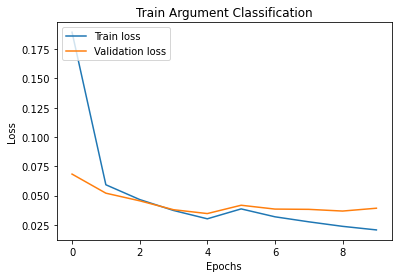

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelArgClass.pt"
torch.save(model7, pth_model, pickle_protocol=4)

In [ ]:
with open("/content/drive/MyDrive/argumentclasses.json", "r") as input_file:
  argument_classes = json.load(input_file)

In [ ]:
new_predictions = []
new_true = []
for p,t in zip(predictions,true):
  if t!=-100:
    new_predictions.append(argument_classes[str(p)])
    new_true.append(argument_classes[str(t)])

In [ ]:
roles_list.append("_")

Confusion Matrix


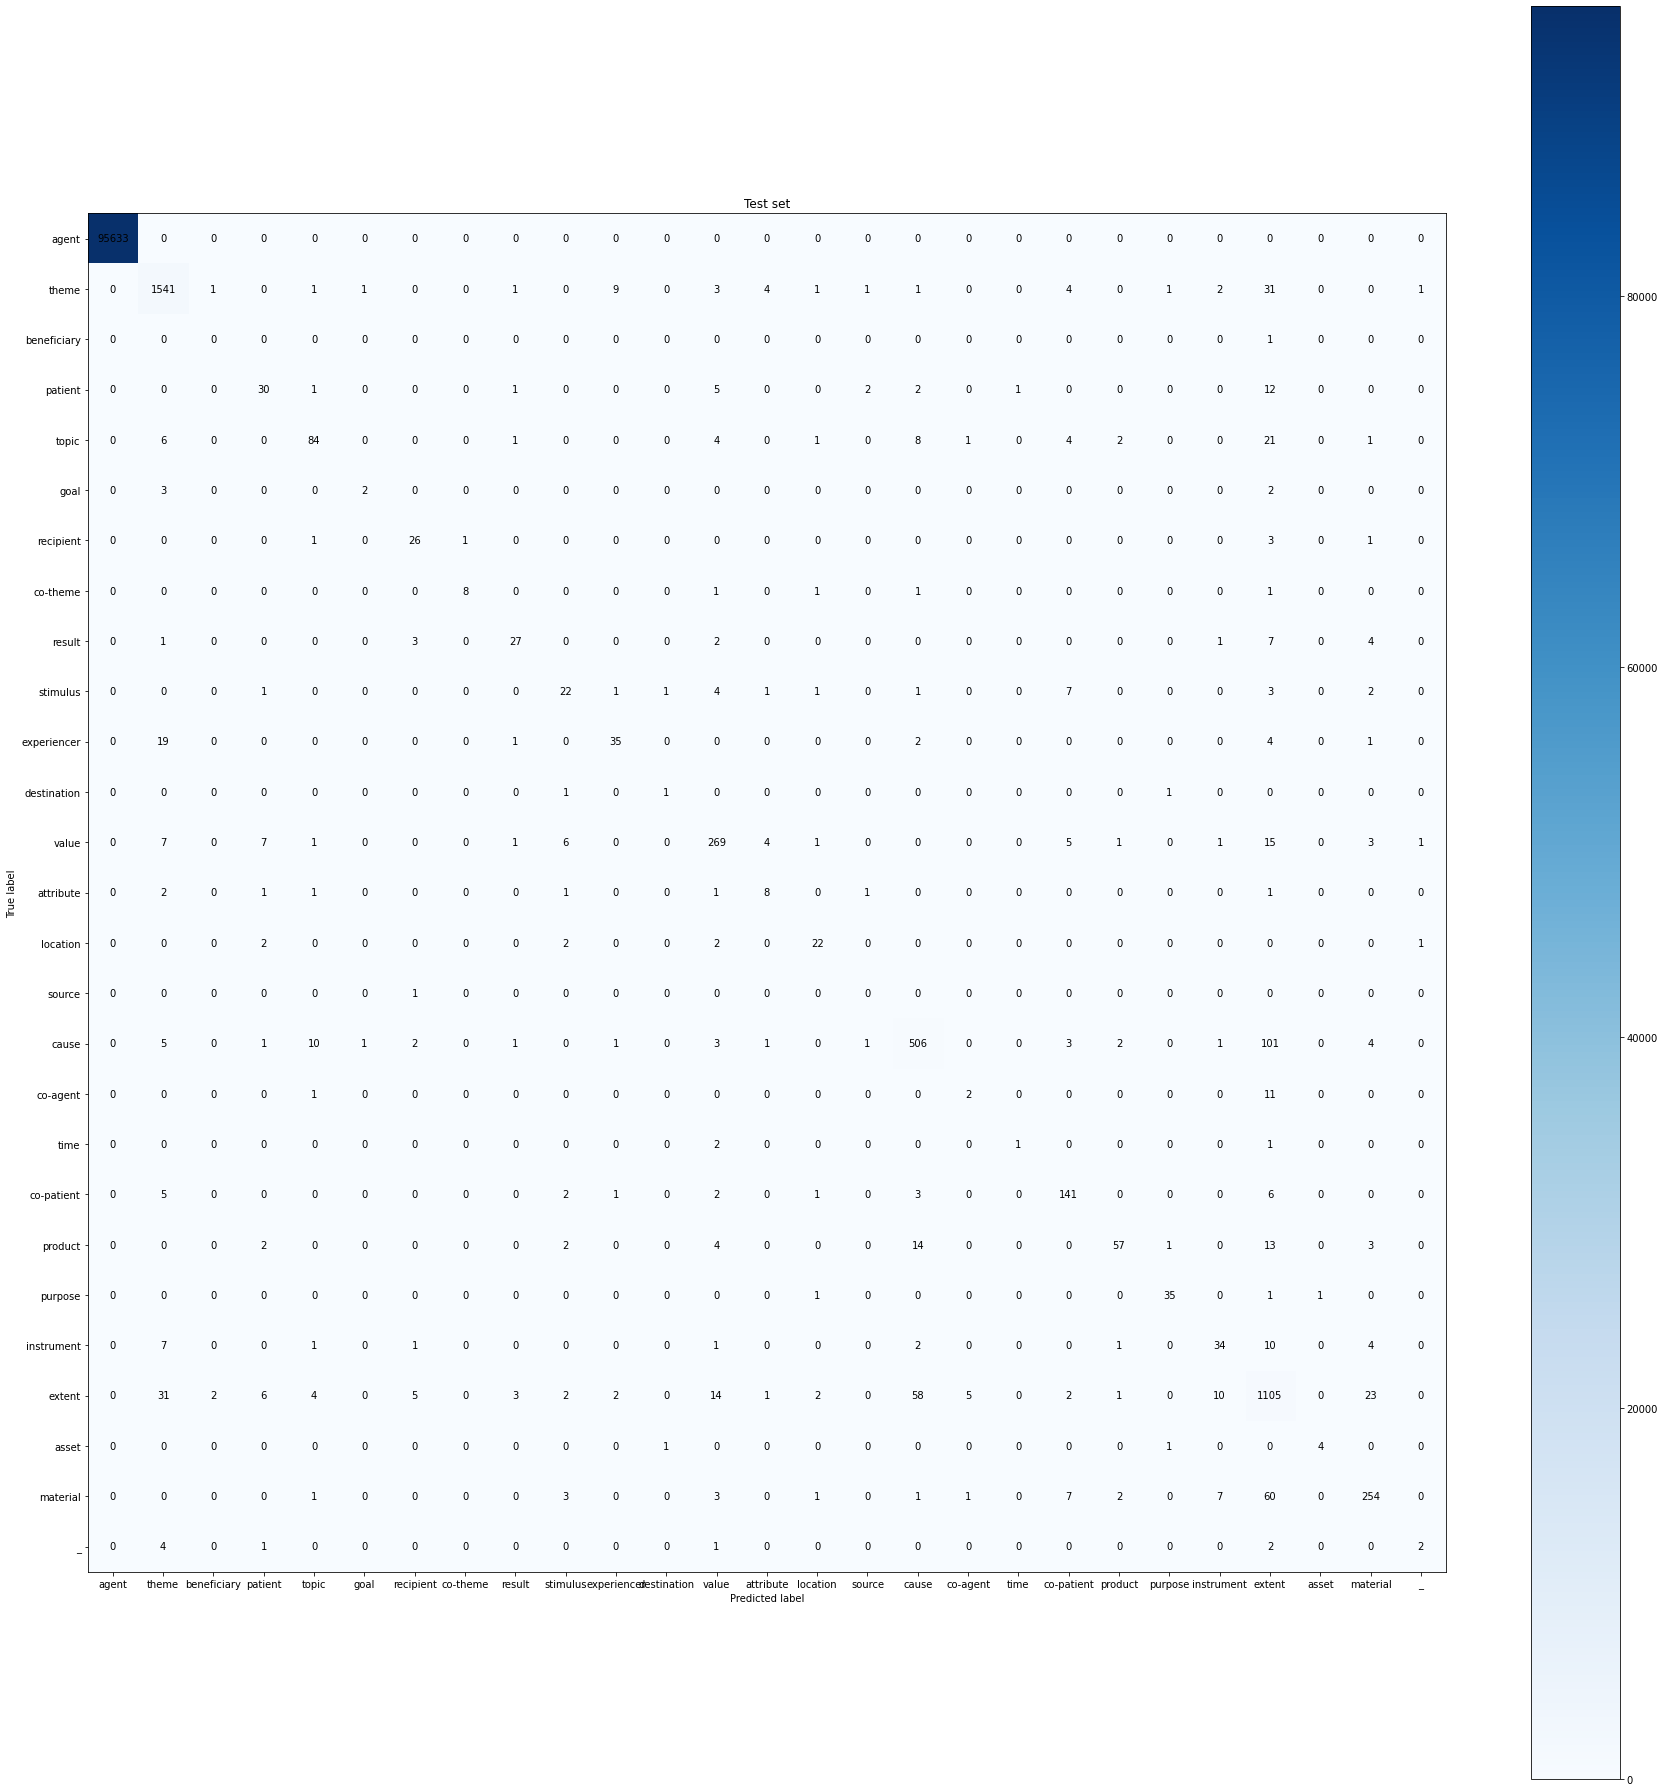

In [ ]:
#confusion matrix
plot_confusion_matrix(np.array(new_true), np.array(new_predictions), roles_list)

With transformer finetuning 

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model7 = ArgumentClassification(N_HIDDEN, N_CLASSES, device, BERT)
model7.to(device)
optimizer = torch.optim.Adam(model7.parameters())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train2, dataset_val2, N_CLASSES, LOSS, 5)


epoch: 1/5
Training...
Train Loss: 0.3174700305539336
Validating...
Validation Loss: 0.14095723833888768


epoch: 2/5
Training...
Train Loss: 0.09946326775697328
Validating...
Validation Loss: 0.088380544539541


epoch: 3/5
Training...
Train Loss: 0.0887167868599043
Validating...
Validation Loss: 0.0841055417433381


epoch: 4/5
Training...
Train Loss: 0.08548288139919777
Validating...
Validation Loss: 0.08332967143505812


epoch: 5/5
Training...
Train Loss: 0.08295092659102658
Validating...
Validation Loss: 0.0809645464643836



In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev2)

Correctly classified: 2651
False Positives: 2362
False Negatives: 2362
# Precision: 0.53
# Recall: 0.53
# F1: 0.53


In [ ]:
#Train the model
model7.train()
loss_train, loss_val = train(model7, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, 5, loss_train, loss_val)


epoch: 6/10
Training...
Train Loss: 0.08908381316242582
Validating...
Validation Loss: 0.087069396302104


epoch: 7/10
Training...
Train Loss: 0.08845388148464052
Validating...
Validation Loss: 0.08565944228321314


epoch: 8/10
Training...
Train Loss: 0.08797921558136994
Validating...
Validation Loss: 0.08640432981774211


epoch: 9/10
Training...
Train Loss: 0.08769263436565292
Validating...
Validation Loss: 0.08622157704085112


epoch: 10/10
Training...
Train Loss: 0.08747701802538277
Validating...
Validation Loss: 0.08567158095538616



In [ ]:
#Test the model
model7.eval()
true, predictions = test(model7, dataset_dev)

Correctly classified: 2688
False Positives: 2325
False Negatives: 2325
# Precision: 0.54
# Recall: 0.54
# F1: 0.54


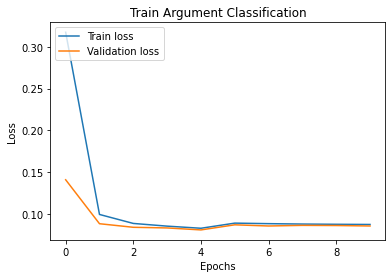

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

###Training and test 8

* Batch size used: 32
* Epochs of training: 20
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* In the model arguments are tagged: concatenate 2 features: one with '1' in corrispondence of tokens of arguments, '0' otherwise; the other with the difference between the mean of the features of a word and the mean of the features of the predicate
* The model is trained in two steps: first with the follow pattern of data: "[CLS]" tokens sentence [SEP] predicate", then with [list of sentence's tokens]

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model8 = ArgumentClassification(N_HIDDEN, N_CLASSES, device, ALBERT)
model8.to(device)
optimizer = torch.optim.Adam(model8.parameters())

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model8.train()
loss_train, loss_val = train(model8, optimizer, dataset_train2, dataset_val2, N_CLASSES, LOSS, 5)


epoch: 1/5
Training...
Train Loss: 0.185227732852859
Validating...
Validation Loss: 0.06787683870643377


epoch: 2/5
Training...
Train Loss: 0.059108220272313404
Validating...
Validation Loss: 0.053824703907594085


epoch: 3/5
Training...
Train Loss: 0.045159309639432335
Validating...
Validation Loss: 0.04302750872448087


epoch: 4/5
Training...
Train Loss: 0.03577557226674537
Validating...
Validation Loss: 0.038018620247021316


epoch: 5/5
Training...
Train Loss: 0.028760686846934048
Validating...
Validation Loss: 0.03519429303705692



In [ ]:
#Test the model
model8.eval()
true, predictions = test(model8, dataset_dev2)

Correctly classified: 4049
False Positives: 965
False Negatives: 964
# Precision: 0.81
# Recall: 0.81
# F1: 0.81


In [ ]:
#Train the model
model8.train()
loss_train, loss_val = train(model8, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, 5)


epoch: 1/5
Training...
Train Loss: 0.0885475567715653
Validating...
Validation Loss: 0.07260228134691715


epoch: 2/5
Training...
Train Loss: 0.06929218698566579
Validating...
Validation Loss: 0.0663215315900743


epoch: 3/5
Training...
Train Loss: 0.06308710484602358
Validating...
Validation Loss: 0.062217400223016736


epoch: 4/5
Training...
Train Loss: 0.05916228162198417
Validating...
Validation Loss: 0.06124692661687732


epoch: 5/5
Training...
Train Loss: 0.05585779970522318
Validating...
Validation Loss: 0.05780130955390632



In [ ]:
#Test the model
model8.eval()
true, predictions = test(model8, dataset_dev)

Correctly classified: 3388
False Positives: 1625
False Negatives: 1625
# Precision: 0.68
# Recall: 0.68
# F1: 0.68


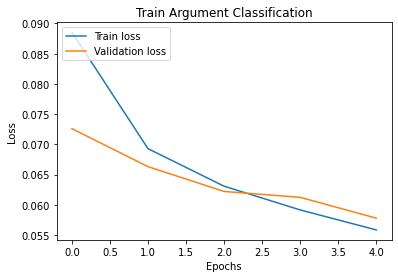

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

###Training and test 9

* Batch size used: 32
* Epochs of training: 20
* Loss function: cross_entropy
* Activation function: softmax
* 1 linear layer of the classifier
* 2 layers BiLSTM
* Transformer "bert-base-cased" not finetuned
* Adam Optimizer
* In the model arguments are tagged: concatenate 2 features: one with '1' in corrispondence of tokens of arguments, '0' otherwise; the other with the difference between the mean of the features of a word and the mean of the features of the predicate
* The model is trained in two steps: first with the follow pattern of data: "[CLS]" tokens sentence [SEP] predicate", then with [list of sentence's tokens]

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 10
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model9 = ArgumentClassification(N_HIDDEN, N_CLASSES, device, RoBERTa)
model9.to(device)
optimizer = torch.optim.Adam(model9.parameters())

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Train the model
model9.train()
loss_train, loss_val = train(model9, optimizer, dataset_train2, dataset_val2, N_CLASSES, LOSS, 5)


epoch: 1/5
Training...
Train Loss: 0.19126443849024127
Validating...
Validation Loss: 0.07729352191090584


epoch: 2/5
Training...
Train Loss: 0.0689391299008818
Validating...
Validation Loss: 0.06004240103065968


epoch: 3/5
Training...
Train Loss: 0.0577082114010039
Validating...
Validation Loss: 0.05348241571336985


epoch: 4/5
Training...
Train Loss: 0.05021622671224808
Validating...
Validation Loss: 0.04736848189495504


epoch: 5/5
Training...
Train Loss: 0.044403939965670394
Validating...
Validation Loss: 0.0454176370985806



In [ ]:
#Test the model
model9.eval()
true, predictions = test(model9, dataset_dev2)

Correctly classified: 3803
False Positives: 1207
False Negatives: 1210
# Precision: 0.76
# Recall: 0.76
# F1: 0.76


In [ ]:
#Train the model
model9.train()
loss_train, loss_val = train(model9, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, 5)


epoch: 1/5
Training...
Train Loss: 0.046477754063651726
Validating...
Validation Loss: 0.05049873311072588


epoch: 2/5
Training...
Train Loss: 0.040877605846288516
Validating...
Validation Loss: 0.048380639776587485


epoch: 3/5
Training...
Train Loss: 0.03661202409930822
Validating...
Validation Loss: 0.045081759244203566


epoch: 4/5
Training...
Train Loss: 0.03281207362947575
Validating...
Validation Loss: 0.04551140279509127


epoch: 5/5
Training...
Train Loss: 0.029064250636403843
Validating...
Validation Loss: 0.04311755574308336



In [ ]:
#Test the model
model9.eval()
true, predictions = test(model9, dataset_dev)

Correctly classified: 3980
False Positives: 1033
False Negatives: 1033
# Precision: 0.79
# Recall: 0.79
# F1: 0.79


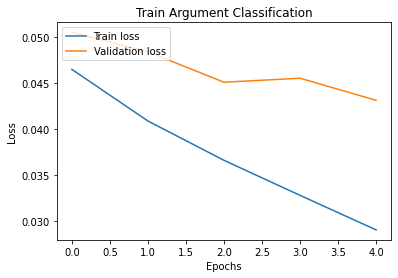

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

##Transfer learning on Spanish

In [ ]:
#Duplicate data for each predciate in evry sentence
new_words, new_pred, new_roles = duplicate_data(wordsES, predES, rolES)
new_words_dev, new_pred_dev, new_roles_dev = duplicate_data(words_devES, pred_devES, rol_devES)

In [ ]:
#process data
data, labels = encode_data(new_words, new_roles, new_pred, BERT)
data_dev, labels_dev = encode_data(new_words_dev, new_roles_dev, new_pred_dev, BERT)

In [ ]:
#define datasets with its batch size

BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 20
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
modelArgClass = torch.load("/content/drive/MyDrive/modelArgumentClassProvaNotturna.pt")
modelArgClass.to(device)
optimizer = torch.optim.Adam(modelArgClass.parameters())

In [ ]:
#Train the model
modelArgClass.train()
loss_train, loss_val = train(modelArgClass, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, EPOCHS)


epoch: 1/10
Training...
Train Loss: 0.09635401733459965
Validating...
Validation Loss: 0.06353991664946079


epoch: 2/10
Training...
Train Loss: 0.07319969335390676
Validating...
Validation Loss: 0.06630953401327133


epoch: 3/10
Training...
Train Loss: 0.06790306611407187
Validating...
Validation Loss: 0.06599067617207766


epoch: 4/10
Training...
Train Loss: 0.06428861533922534
Validating...
Validation Loss: 0.06138662528246641


epoch: 5/10
Training...
Train Loss: 0.059422659176972606
Validating...
Validation Loss: 0.05877369735389948


epoch: 6/10
Training...
Train Loss: 0.05633330549443922
Validating...
Validation Loss: 0.07131598051637411


epoch: 7/10
Training...
Train Loss: 0.05376533539064469
Validating...
Validation Loss: 0.06071539130061865


epoch: 8/10
Training...
Train Loss: 0.05039648104819559
Validating...
Validation Loss: 0.07764378748834133


epoch: 9/10
Training...
Train Loss: 0.04684233136715427
Validating...
Validation Loss: 0.062014796771109104


epoch: 10/10
Tra

In [ ]:
#Test the model
modelArgClass.eval()
true, predictions = test(modelArgClass, dataset_dev)

Correctly classified: 2951
False Positives: 1798
False Negatives: 1799
# Precision: 0.62
# Recall: 0.62
# F1: 0.62


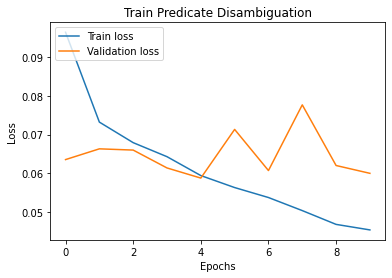

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelArgClassES.pt"
torch.save(modelArgClass, pth_model, pickle_protocol=4)

##Transfer learning on French

In [ ]:
#Duplicate data for each predciate in evry sentence
new_words, new_pred, new_roles = duplicate_data(wordsFR, predFR, rolFR)
new_words_dev, new_pred_dev, new_roles_dev = duplicate_data(words_devFR, pred_devFR, rol_devFR)

In [ ]:
#process data
data, labels = encode_data(new_words, new_roles, new_pred, BERT)
data_dev, labels_dev = encode_data(new_words_dev, new_roles_dev, new_pred_dev, BERT)

In [ ]:
#define datasets with its batch size

BATCH = 32

#split training set into train and validation to train and to evaluate the model
x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.1, random_state = 43)

#Define dataset from data for the input of the model
dataset_train = create_dataset(x_train, y_train, BATCH)
dataset_val = create_dataset(x_val, y_val, BATCH)
dataset_dev = create_dataset(data_dev, labels_dev, BATCH)

In [ ]:
#HYPERPARAMETERS
N_HIDDEN = 200
N_CLASSES = len(roles_list)+2
EPOCHS = 20
LOSS = F.cross_entropy

In [ ]:
#Model Instance
device = "cuda" if torch.cuda.is_available() else "cpu"
modelArgClass = torch.load("/content/drive/MyDrive/modelArgumentClassProvaNotturna.pt")
modelArgClass.to(device)
optimizer = torch.optim.Adam(modelArgClass.parameters(), lr=0.0001, weight_decay=0.0001)

In [ ]:
#Train the model
modelArgClass.train()
loss_train, loss_val = train(modelArgClass, optimizer, dataset_train, dataset_val, N_CLASSES, LOSS, EPOCHS)


epoch: 1/20
Training...
Train Loss: 0.08607984462287277
Validating...
Validation Loss: 0.07509853225201368


epoch: 2/20
Training...
Train Loss: 0.06556366675067693
Validating...
Validation Loss: 0.07375176064670086


epoch: 3/20
Training...
Train Loss: 0.060867289430461824
Validating...
Validation Loss: 0.07186742965131998


epoch: 4/20
Training...
Train Loss: 0.056832693866454065
Validating...
Validation Loss: 0.07002326287329197


epoch: 5/20
Training...
Train Loss: 0.053315854514949024
Validating...
Validation Loss: 0.07092481385916471


epoch: 6/20
Training...
Train Loss: 0.05039086111355573
Validating...
Validation Loss: 0.0699497452005744


epoch: 7/20
Training...
Train Loss: 0.04651044134516269
Validating...
Validation Loss: 0.0681188078597188


epoch: 8/20
Training...
Train Loss: 0.04360653006006032
Validating...
Validation Loss: 0.07234670035541058


epoch: 9/20
Training...
Train Loss: 0.0403477480285801
Validating...
Validation Loss: 0.07045630551874638


epoch: 10/20
Train

In [ ]:
#Test the model
modelArgClass.eval()
true, predictions = test(modelArgClass, dataset_dev)

Correctly classified: 2847
False Positives: 2156
False Negatives: 2156
# Precision: 0.57
# Recall: 0.57
# F1: 0.57


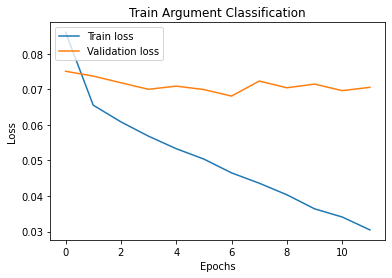

In [ ]:
plot_train_trend(loss_train, loss_val, "Train Argument Classification")

In [ ]:
#TO SAVE A MODEL
pth_model = "/content/drive/MyDrive/modelArgClassFR.pt"
torch.save(modelArgClass, pth_model, pickle_protocol=4)